# Advanced Lane Finding Project 

By Pablo Sauras Perez

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## 1. Compute the camera calibration using chessboard images
This code is was available in 'examples/example.ipynb'

In [111]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [112]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# chessboard
ny = 6
nx = 9

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'output_images/calibration_corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow(write_name,img)
        cv2.waitKey(50)
        
cv2.destroyAllWindows()

### Calibrate, Calculate Distortion Coefficients and test undistorsion on an image
This code is from 'CarND-Camera-Calibration'

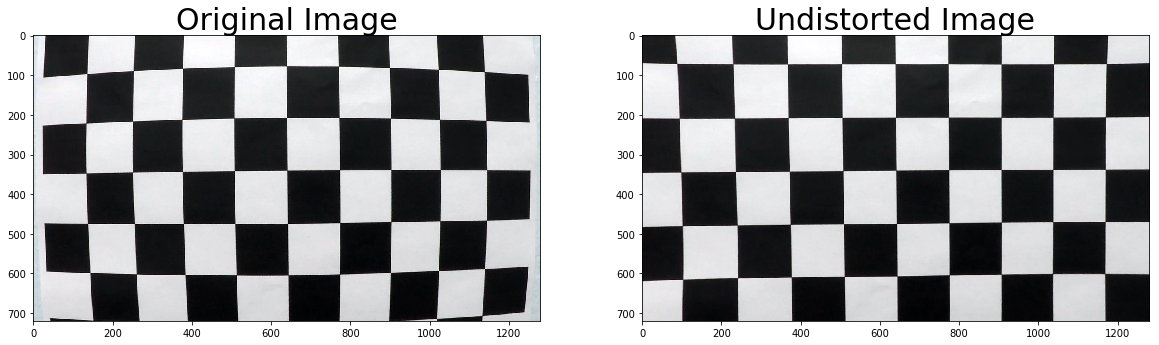

In [113]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undistorded_calibration.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#I apply mtx and dist to each new frame
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)

## 2. Apply a distortion correction to raw images

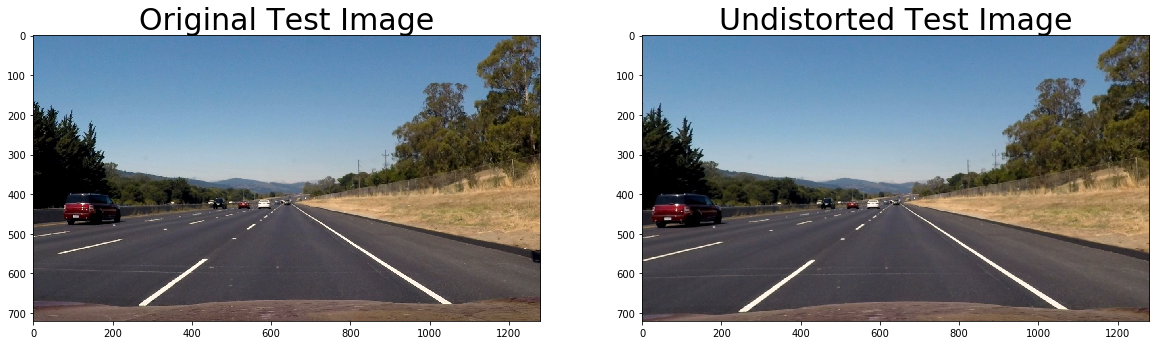

In [114]:
# Test undistortion on an image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('output_images/undistorded_test.jpg',cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Test Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

This is the Thresholding step. Here I want to use various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

In [115]:
# Edit this function to create your own pipeline.
def pipeline_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    
    
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel_mag = np.uint8(255*gradmag/np.max(gradmag))
    
    thresh_d=(0.5, 1.3)
    
    #direction of the gradient
    direction =  np.arctan2(abs_sobely, abs_sobelx)
        
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    
    # Threshold magnitude
    s_mag_binary = np.zeros_like(scaled_sobel_mag)
    s_mag_binary[((scaled_sobel_mag >= sx_thresh[0]) & (scaled_sobel_mag <= sx_thresh[1]))] = 1
    
    # Threshold x gradient
    s_dir_binary = np.zeros_like(scaled_sobel)
    s_dir_binary[((direction >= thresh_d[0]) & (direction <=  thresh_d[1]))] = 1
    
    #sxbinary[(sxbinary == 1) | ((s_mag_binary == 1) & (s_dir_binary == 1))] = 1
    
    #binary_output_direction = np.zeros_like(direction)
    #binary_output_direction[(direction_direction >= thresh_d[0]) & (direction_direction <=  thresh_d[1])] = 1
    
    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (s_dir_binary == 1) & (s_mag_binary == 1)) | (sxbinary == 1)] = 1
    color_binary = combined_binary
    
    
    return color_binary

Apply threshold pipeline and show one of the test results

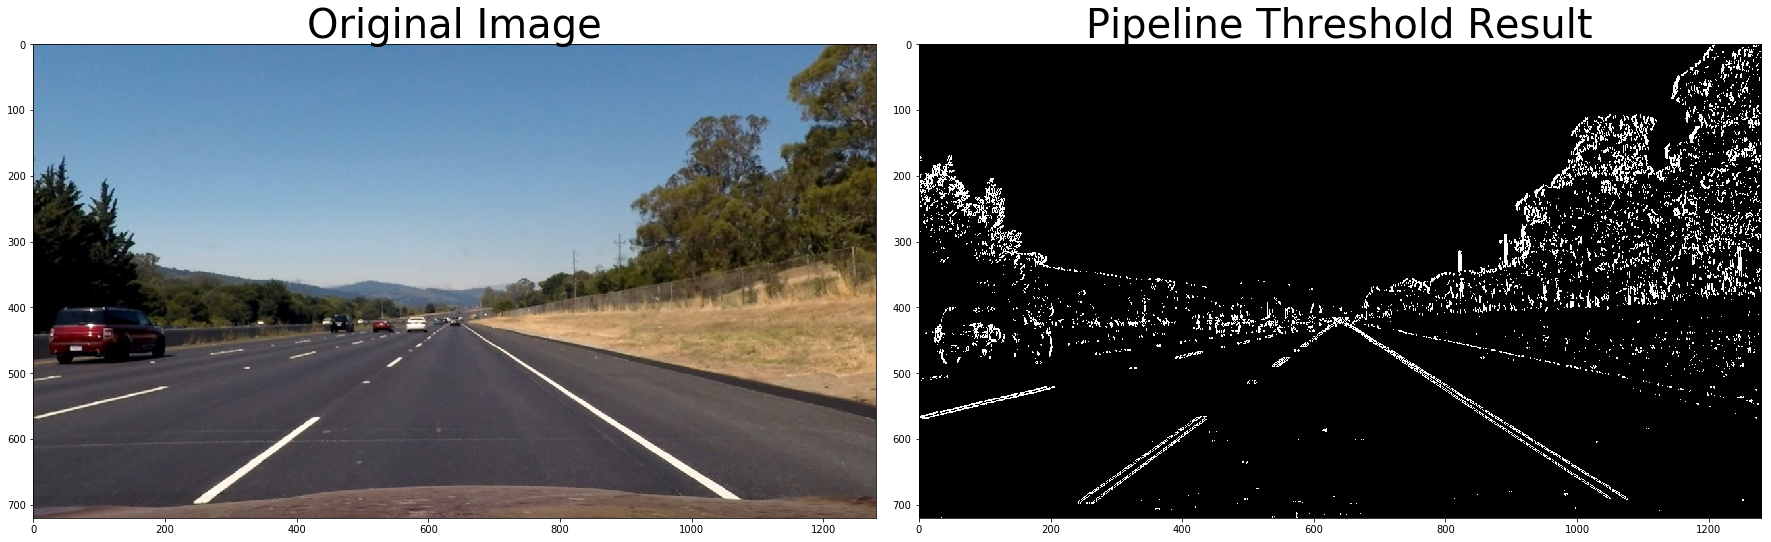

In [116]:
image = dst
undst = dst
color_binary = pipeline_threshold(image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary, cmap = 'gray')
ax2.set_title('Pipeline Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [117]:
#I already have mtx --> Calibration Matrix
# and dist --> Distortion Coeficients
#from the camera calibration of step 1... so I use them

def corners_unwarp(img, mtx, dist):

    # Undistort using mtx and dist   
    undst = cv2.undistort(img, mtx, dist, None, mtx)  
    img_size =(undst.shape[1], undst.shape[0])
    
    #top-right
    #bottom-right
    #bottom-left
    #top-left
    
    #source points (trapezoid)  
    src = np.float32(
    [[580, 460],
     [195, 720],
     [1127, 720],
     [705, 460]])
    
   
    #destination points (a rectangle)        
    dst = np.float32(
    [[320, 0],
     [320, 720],
     [960, 720], 
     [960, 0]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #calculate the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)
 
    return warped, M, Minv, src, dst

Apply it the perspective transform

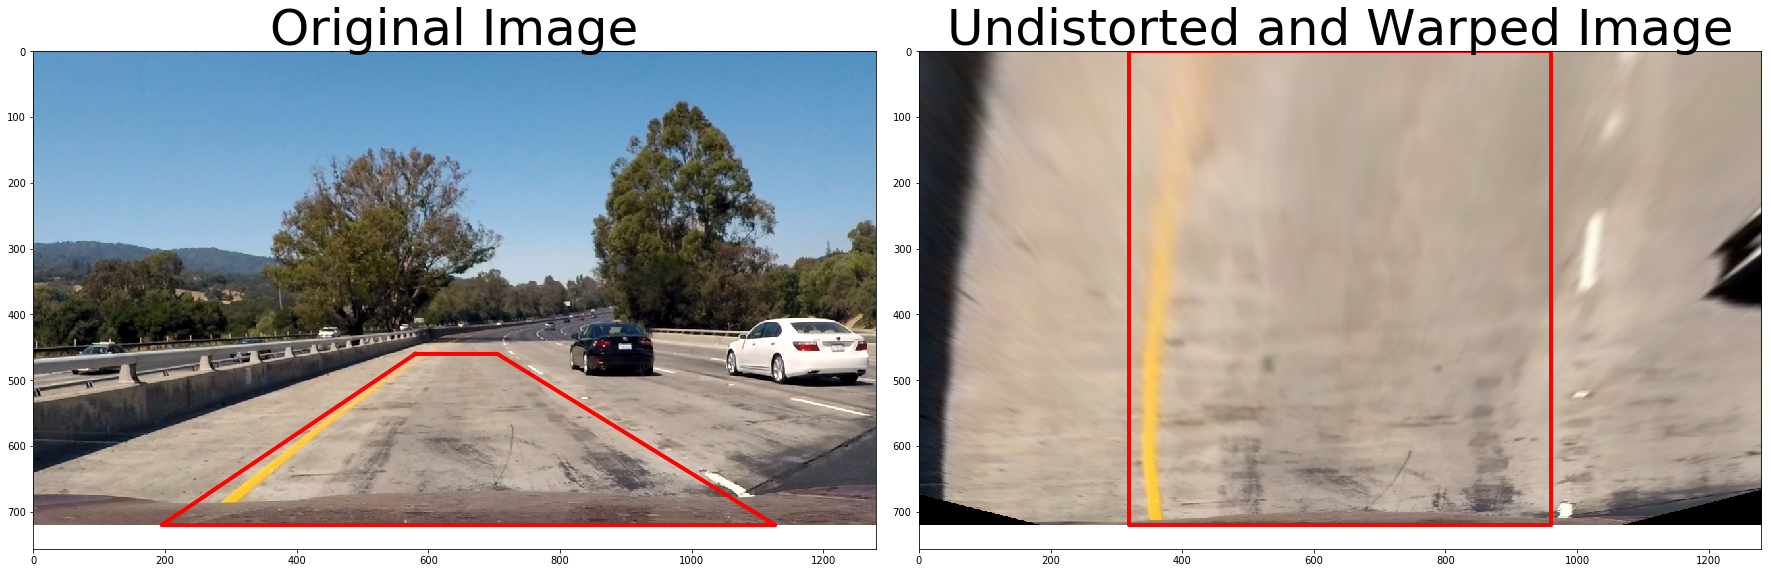

In [118]:
# Test on an image where lines are straight
img = cv2.imread('test_images/test1.jpg')

top_down, perspective_M, perspective_Minv, src, dst = corners_unwarp(img, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now I apply perspective transform to rectify binary image

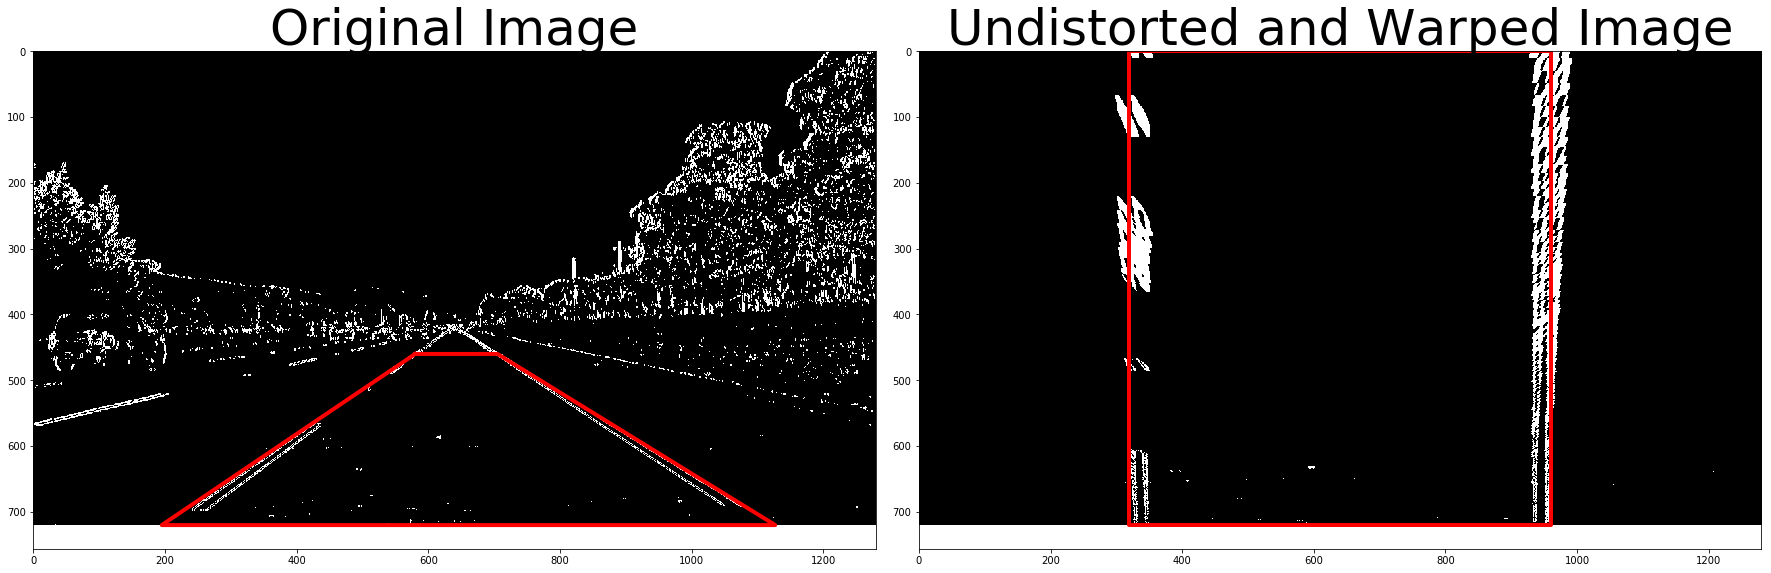

In [119]:
binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary.

In [120]:
def lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix):
    
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit

### Call the function

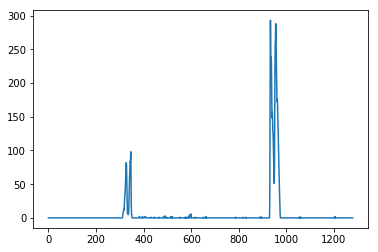

In [121]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#Call the function
nwindows = 9
margin = 100
minpix = 50

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
    
left_lane_inds, left_fit, right_lane_inds, right_fit = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)

### Visualization


(720, 0)

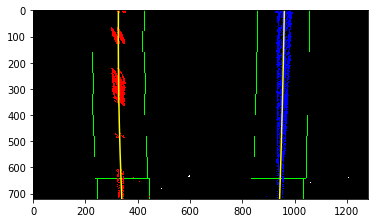

In [122]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skip the sliding windows step once you know where the lines are

In [123]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty

### Call the function

In [124]:
#Call to the function
margin = 100
left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty = next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin)

## Visualize as well

(720, 0)

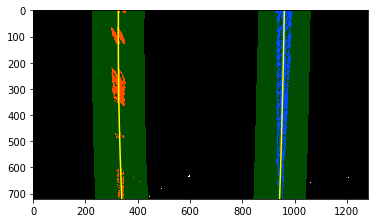

In [125]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Determine the curvature of the lane and vehicle position with respect to center

First I do Radius in Pixels

In [126]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def rad_cur_px(ploty, y_eval, left_fit, right_fit):
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('Left Radius: ', left_curverad)
    print('Right Radius: ', right_curverad)
    
    return left_curverad, right_curverad

Call the function

In [127]:
y_eval = np.max(ploty)
left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

Left Radius:  14080.4017731
Right Radius:  43815.2561385


Now we have to convert this to the real world space. 
Assume (as indicated in the lesson) hat if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [128]:
def rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix):


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Left curvature: ', left_curverad, 'm')
    print('Right curvature: ', right_curverad, 'm')

    R_avg = (left_curverad + right_curverad)/2

    curv_str = "Radius of Curvature: %im" % abs(R_avg)
    print(curv_str)
    
    return curv_str, left_fit_cr, right_fit_cr

Call the function

In [129]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension
curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)

Left curvature:  4300.4328909 m
Right curvature:  13136.2824305 m
Radius of Curvature: 8718m


## Offset calculation

In [157]:
def lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    
    #Calculate distance at the bottom of the image
    left_fit_cr_eval = left_fit_cr[0]*y_eval*ym_per_pix**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_fit_cr_eval = right_fit_cr[0]*y_eval*ym_per_pix**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]

    image_center = (binary_warped.shape[1]/2)*xm_per_pix #Convert to m
    lane_center = (right_fit_cr_eval + left_fit_cr_eval)/2 #Already in m

    offset = image_center - lane_center

    if offset > 0:
        offset_str = "Vehicle is %.2fm left of center" % abs(offset)
        print(offset_str)
    elif offset < 0:
        offset_str = "Vehicle is %.2fm right of center" % abs(offset)
        print(offset_str)
    else:
        offset_str = "Vehicle is at center"
        print(offset_str)   
        
    return offset_str

Call the function

In [158]:
offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)

Vehicle is 0.03m left of center


## 7. Warp the detected lane boundaries back onto the original image.

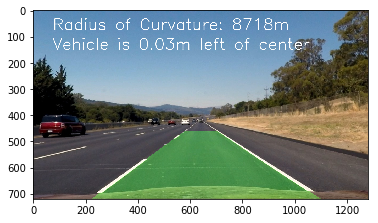

In [159]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
plt.imshow(result)

## Pipeline (Video)

In [133]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [163]:
#Image
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
def process_image(image):
    #TODO: my code here
    #result = image
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    img = image
    #1 . Distortion correction on images
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Calculate distortion coefficients
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #2. Color / Gradient thresholding
    color_binary = pipeline_threshold(undst)
    
    #3. Unwrap  
    binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)
    
    #4. detect lane pixels to find lane boundary
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    #Call the function
    nwindows = 9
    margin = 100
    minpix = 50

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    
    left_lane_inds, left_fit, right_lane_inds, right_fit = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)
    
    #5. Skip Slidding Window once I know where the lanes are
    margin = 100
    left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty = next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin)
    
    #6. Determine Rad Curvature
    # In pixels
    y_eval = np.max(ploty)
    left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

    #In meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    #7. Calculate lateral offset
    offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)
    
    #Plot results
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    #plt.text(100, 75, curv_str, color='white')
    #plt.text(100, 150, offset_str, color='white')
    #plt.imshow(result)
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
    return result

In [164]:
output_clip = "output_images/project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")

clip_result = clip.fl_image(process_image)

%time clip_result.write_videofile(output_clip, audio=False)

Left Radius:  2649.09991384
Right Radius:  2654.5035681
Left curvature:  811.793001055 m
Right curvature:  809.092850774 m
Radius of Curvature: 810m
Vehicle is 0.85m right of center
[MoviePy] >>>> Building video output_images/project_video_result.mp4
[MoviePy] Writing video output_images/project_video_result.mp4


  0%|          | 1/1261 [00:00<05:04,  4.14it/s]

Left Radius:  2649.09991384
Right Radius:  2654.5035681
Left curvature:  811.793001055 m
Right curvature:  809.092850774 m
Radius of Curvature: 810m
Vehicle is 0.85m right of center


  0%|          | 2/1261 [00:00<05:11,  4.04it/s]

Left Radius:  2228.13916002
Right Radius:  2939.81211498
Left curvature:  673.795474532 m
Right curvature:  881.644339991 m
Radius of Curvature: 777m
Vehicle is 0.88m right of center


  0%|          | 3/1261 [00:00<04:55,  4.25it/s]

Left Radius:  2302.10564121
Right Radius:  1834.55722214
Left curvature:  674.361520145 m
Right curvature:  550.602790182 m
Radius of Curvature: 612m
Vehicle is 1.02m right of center


  0%|          | 4/1261 [00:00<04:42,  4.44it/s]

Left Radius:  2067.41264712
Right Radius:  1739.63578233
Left curvature:  621.741035186 m
Right curvature:  522.25532203 m
Radius of Curvature: 571m
Vehicle is 1.08m right of center


  0%|          | 5/1261 [00:01<04:38,  4.51it/s]

Left Radius:  2395.41436436
Right Radius:  1905.518662
Left curvature:  734.374379634 m
Right curvature:  572.223744189 m
Radius of Curvature: 653m
Vehicle is 1.01m right of center
Left Radius:  2061.2325286
Right Radius:  2755.26902779


  0%|          | 6/1261 [00:01<04:31,  4.63it/s]

Left curvature:  623.023816498 m
Right curvature:  822.624029247 m
Radius of Curvature: 722m
Vehicle is 0.95m right of center


  1%|          | 7/1261 [00:01<04:30,  4.64it/s]

Left Radius:  1849.764093
Right Radius:  3106.03212871
Left curvature:  559.085526752 m
Right curvature:  925.783459944 m
Radius of Curvature: 742m
Vehicle is 0.96m right of center


  1%|          | 8/1261 [00:01<04:30,  4.63it/s]

Left Radius:  2102.37101853
Right Radius:  20193.5545244
Left curvature:  650.530159963 m
Right curvature:  141261.895264 m
Radius of Curvature: 70956m
Vehicle is 0.75m right of center


  1%|          | 9/1261 [00:01<04:28,  4.67it/s]

Left Radius:  2275.30542449
Right Radius:  17308.7412238
Left curvature:  699.402720227 m
Right curvature:  3426.91112467 m
Radius of Curvature: 2063m
Vehicle is 0.68m right of center


  1%|          | 10/1261 [00:02<04:29,  4.63it/s]

Left Radius:  2038.25398826
Right Radius:  31519.2441061
Left curvature:  617.397555563 m
Right curvature:  8855.08824752 m
Radius of Curvature: 4736m
Vehicle is 0.73m right of center
Left Radius:  2373.13690365
Right Radius:  3799.55199648
Left curvature:  725.729140086 m
Right curvature:  1123.6621485 m
Radius of Curvature: 924m
Vehicle is 0.85m right of center


  1%|          | 12/1261 [00:02<04:18,  4.83it/s]

Left Radius:  2501.67454134
Right Radius:  4928.5751965
Left curvature:  765.422574701 m
Right curvature:  1460.32391315 m
Radius of Curvature: 1112m
Vehicle is 0.79m right of center


  1%|          | 13/1261 [00:02<04:27,  4.67it/s]

Left Radius:  2936.39001938
Right Radius:  4584.31518393
Left curvature:  932.583986353 m
Right curvature:  1379.44193898 m
Radius of Curvature: 1156m
Vehicle is 0.75m right of center


  1%|          | 14/1261 [00:03<04:37,  4.50it/s]

Left Radius:  3047.61179088
Right Radius:  8716.21238233
Left curvature:  925.641070524 m
Right curvature:  2549.11157603 m
Radius of Curvature: 1737m
Vehicle is 0.68m right of center


  1%|          | 15/1261 [00:03<04:31,  4.60it/s]

Left Radius:  3554.13089975
Right Radius:  2179.91862181
Left curvature:  1103.76927431 m
Right curvature:  652.882892094 m
Radius of Curvature: 878m
Vehicle is 0.86m right of center


  1%|▏         | 16/1261 [00:03<04:28,  4.63it/s]

Left Radius:  4517.55226488
Right Radius:  1974.33154504
Left curvature:  1415.81577924 m
Right curvature:  591.24584466 m
Radius of Curvature: 1003m
Vehicle is 0.85m right of center
Left Radius:  3670.42448433
Right Radius:  2571.99193771
Left curvature:  1129.15001867 m
Right curvature:  764.711349581 m
Radius of Curvature: 946m
Vehicle is 0.81m right of center


  1%|▏         | 18/1261 [00:03<04:16,  4.85it/s]

Left Radius:  4496.54904368
Right Radius:  3199.22939912
Left curvature:  1401.56279294 m
Right curvature:  950.079014282 m
Radius of Curvature: 1175m
Vehicle is 0.71m right of center
Left Radius:  5398.85979233
Right Radius:  3918.76013955
Left curvature:  1671.73905306 m
Right curvature:  1153.16091 m
Radius of Curvature: 1412m
Vehicle is 0.65m right of center


  2%|▏         | 20/1261 [00:04<04:21,  4.74it/s]

Left Radius:  5650.96237486
Right Radius:  3775.15572773
Left curvature:  1733.38304306 m
Right curvature:  1156.36182903 m
Radius of Curvature: 1444m
Vehicle is 0.64m right of center


  2%|▏         | 21/1261 [00:04<04:14,  4.87it/s]

Left Radius:  4239.61452016
Right Radius:  5373.35250684
Left curvature:  1285.1559627 m
Right curvature:  1718.2905132 m
Radius of Curvature: 1501m
Vehicle is 0.63m right of center
Left Radius:  4042.84332256
Right Radius:  16815.6126918
Left curvature:  1212.08269519 m
Right curvature:  4843.67909846 m
Radius of Curvature: 3027m
Vehicle is 0.57m right of center


  2%|▏         | 23/1261 [00:04<04:12,  4.91it/s]

Left Radius:  3094.74111433
Right Radius:  18028.9126216
Left curvature:  931.112564783 m
Right curvature:  5233.47837512 m
Radius of Curvature: 3082m
Vehicle is 0.60m right of center
Left Radius:  2919.15538603
Right Radius:  3337.63965384
Left curvature:  883.89576677 m
Right curvature:  997.073887459 m
Radius of Curvature: 940m
Vehicle is 0.74m right of center


  2%|▏         | 25/1261 [00:05<04:08,  4.96it/s]

Left Radius:  2900.64336445
Right Radius:  2611.30147994
Left curvature:  871.924561878 m
Right curvature:  782.110767664 m
Radius of Curvature: 827m
Vehicle is 0.80m right of center
Left Radius:  3304.34724016
Right Radius:  3124.18565071
Left curvature:  1027.11072379 m
Right curvature:  944.854021951 m
Radius of Curvature: 985m
Vehicle is 0.72m right of center


  2%|▏         | 27/1261 [00:05<04:10,  4.93it/s]

Left Radius:  2696.72742749
Right Radius:  4170.13613314
Left curvature:  810.648503973 m
Right curvature:  1258.26922588 m
Radius of Curvature: 1034m
Vehicle is 0.72m right of center


  2%|▏         | 28/1261 [00:05<04:12,  4.89it/s]

Left Radius:  3190.47498333
Right Radius:  4438.93209435
Left curvature:  957.106286106 m
Right curvature:  1326.78187354 m
Radius of Curvature: 1141m
Vehicle is 0.66m right of center
Left Radius:  3031.53626139
Right Radius:  2590.49083401
Left curvature:  939.404878406 m
Right curvature:  780.952068644 

  2%|▏         | 30/1261 [00:06<04:15,  4.82it/s]

m
Radius of Curvature: 860m
Vehicle is 0.78m right of center
Left Radius:  3886.78483593
Right Radius:  1818.05172737
Left curvature:  1187.19819672 m
Right curvature:  545.771273137 m
Radius of Curvature: 866m
Vehicle is 0.85m right of center


  2%|▏         | 31/1261 [00:06<04:14,  4.83it/s]

Left Radius:  3047.51182478
Right Radius:  2054.49421414
Left curvature:  921.543934249 m
Right curvature:  616.737316641 m
Radius of Curvature: 769m
Vehicle is 0.86m right of center


  3%|▎         | 32/1261 [00:06<04:18,  4.76it/s]

Left Radius:  2484.48102915
Right Radius:  2608.12747115
Left curvature:  749.276931916 m
Right curvature:  793.398981741 m
Radius of Curvature: 771m
Vehicle is 0.84m right of center
Left Radius:  

  3%|▎         | 33/1261 [00:06<04:12,  4.87it/s]

2753.91954596
Right Radius:  3887.20313432
Left curvature:  830.407476032 m
Right curvature:  1149.26880582 m
Radius of Curvature: 989m
Vehicle is 0.74m right of center


  3%|▎         | 34/1261 [00:07<04:14,  4.83it/s]

Left Radius:  2356.45539898
Right Radius:  10085.0936226
Left curvature:  708.976288423 m
Right curvature:  3263.49291463 m
Radius of Curvature: 1986m
Vehicle is 0.71m right of center


  3%|▎         | 35/1261 [00:07<04:10,  4.90it/s]

Left Radius:  2201.76305728
Right Radius:  5049.1048452
Left curvature:  662.263317757 m
Right curvature:  1737.11089575 m
Radius of Curvature: 1199m
Vehicle is 0.77m right of center


  3%|▎         | 36/1261 [00:07<04:16,  4.77it/s]

Left Radius:  1976.31417517
Right Radius:  2149.88611687
Left curvature:  593.924465306 m
Right curvature:  644.134145476 m
Radius of Curvature: 619m
Vehicle is 0.97m right of center


  3%|▎         | 37/1261 [00:07<04:11,  4.87it/s]

Left Radius:  1782.69509004
Right Radius:  2472.55349425
Left curvature:  535.459651807 m
Right curvature:  738.09045827 m
Radius of Curvature: 636m
Vehicle is 0.97m right of center
Left Radius:  1661.57901347
Right Radius:  4200.30049691
Left curvature:  495.11271594 m
Right curvature:  1231.7404549 m
Radius of Curvature: 863m
Vehicle is 0.91m right of center


  3%|▎         | 39/1261 [00:08<04:06,  4.96it/s]

Left Radius:  1668.01511334
Right Radius:  1626.12816449
Left curvature:  498.06725057 m
Right curvature:  488.232421125 m
Radius of Curvature: 493m
Vehicle is 1.13m right of center
Left Radius:  1657.3129634
Right Radius:  1510.65707834
Left curvature:  497.62277659 m
Right curvature:  453.64759214 m
Radius of Curvature: 475m
Vehicle is 1.17m right of center


  3%|▎         | 41/1261 [00:08<04:05,  4.97it/s]

Left Radius:  1795.48865383
Right Radius:  1641.24734946
Left curvature:  540.353082634 m
Right curvature:  492.597844938 m
Radius of Curvature: 516m
Vehicle is 1.11m right of center
Left Radius:  1942.0693699
Right Radius:  1720.88368691
Left curvature:  583.149509988 m
Right curvature:  516.175346223 m
Radius of Curvature: 549m
Vehicle is 1.08m right of center


  3%|▎         | 43/1261 [00:08<04:10,  4.86it/s]

Left Radius:  2003.25752152
Right Radius:  1846.63777654
Left curvature:  605.181191325 m
Right curvature:  553.398968088 m
Radius of Curvature: 579m
Vehicle is 1.05m right of center
Left Radius: 

  3%|▎         | 44/1261 [00:09<04:11,  4.83it/s]

 2283.14194176
Right Radius:  1978.76450249
Left curvature:  687.806925293 m
Right curvature:  593.139107833 m
Radius of Curvature: 640m
Vehicle is 0.98m right of center
Left Radius:  2321.18088283
Right Radius:  2425.19212871


  4%|▎         | 45/1261 [00:09<04:07,  4.92it/s]

Left curvature:  698.023515111 m
Right curvature:  724.423246386 m
Radius of Curvature: 711m
Vehicle is 0.92m right of center


  4%|▎         | 46/1261 [00:09<04:11,  4.84it/s]

Left Radius:  2042.14874514
Right Radius:  3896.09320534
Left curvature:  617.020929957 m
Right curvature:  1181.74356289 m
Radius of Curvature: 899m
Vehicle is 0.87m right of center


  4%|▎         | 47/1261 [00:09<04:10,  4.84it/s]

Left Radius:  1934.83503913
Right Radius:  5405.77037521
Left curvature:  584.176659357 m
Right curvature:  1573.46650862 m
Radius of Curvature: 1078m
Vehicle is 0.85m right of center


  4%|▍         | 48/1261 [00:10<04:14,  4.77it/s]

Left Radius:  1854.37578131
Right Radius:  6170.04713433
Left curvature:  558.329125428 m
Right curvature:  1785.74503207 m
Radius of Curvature: 1172m
Vehicle is 0.85m right of center


  4%|▍         | 49/1261 [00:10<04:15,  4.74it/s]

Left Radius:  2080.67626324
Right Radius:  2880.16459994
Left curvature:  626.305722489 m
Right curvature:  858.117438742 m
Radius of Curvature: 742m
Vehicle is 0.91m right of center


  4%|▍         | 50/1261 [00:10<04:16,  4.71it/s]

Left Radius:  2012.37569282
Right Radius:  2178.6583233
Left curvature:  607.263819829 m
Right curvature:  652.84428726 m
Radius of Curvature: 630m
Vehicle is 0.98m right of center


  4%|▍         | 51/1261 [00:10<04:23,  4.60it/s]

Left Radius:  2139.56170433
Right Radius:  3255.29608666
Left curvature:  644.838387656 m
Right curvature:  964.594666928 m
Radius of Curvature: 804m
Vehicle is 0.88m right of center


  4%|▍         | 52/1261 [00:10<04:26,  4.53it/s]

Left Radius:  2432.85977158
Right Radius:  3150.40368224
Left curvature:  728.812676111 m
Right curvature:  932.793379854 m
Radius of Curvature: 830m
Vehicle is 0.84m right of center


  4%|▍         | 53/1261 [00:11<04:26,  4.53it/s]

Left Radius:  2912.03602538
Right Radius:  1628.61096836
Left curvature:  886.22639296 m
Right curvature:  488.994582835 m
Radius of Curvature: 687m
Vehicle is 0.98m right of center


  4%|▍         | 54/1261 [00:11<04:25,  4.55it/s]

Left Radius:  3232.49729116
Right Radius:  1628.9368655
Left curvature:  962.826697878 m
Right curvature:  488.861350784 m
Radius of Curvature: 725m
Vehicle is 0.96m right of center


  4%|▍         | 55/1261 [00:11<04:18,  4.66it/s]

Left Radius:  3675.37773278
Right Radius:  1761.43476199
Left curvature:  1097.34501512 m
Right curvature:  528.084169282 m
Radius of Curvature: 812m
Vehicle is 0.91m right of center


  4%|▍         | 56/1261 [00:11<04:27,  4.50it/s]

Left Radius:  3783.97242887
Right Radius:  1916.8040447
Left curvature:  1130.27175601 m
Right curvature:  582.388367333 m
Radius of Curvature: 856m
Vehicle is 0.87m right of center


  5%|▍         | 57/1261 [00:12<04:23,  4.56it/s]

Left Radius:  4956.3078065
Right Radius:  2403.87394744
Left curvature:  1474.6884865 m
Right curvature:  726.644771619 m
Radius of Curvature: 1100m
Vehicle is 0.76m right of center


  5%|▍         | 58/1261 [00:12<04:23,  4.56it/s]

Left Radius:  3860.39560809
Right Radius:  3189.36370601
Left curvature:  1158.77059438 m
Right curvature:  995.979468709 m
Radius of Curvature: 1077m
Vehicle is 0.72m right of center


  5%|▍         | 59/1261 [00:12<04:25,  4.53it/s]

Left Radius:  2788.16045595
Right Radius:  5935.7012028
Left curvature:  836.787629624 m
Right curvature:  1691.989833 m
Radius of Curvature: 1264m
Vehicle is 0.72m right of center


  5%|▍         | 60/1261 [00:12<04:30,  4.44it/s]

Left Radius:  3030.73157921
Right Radius:  3096.36089631
Left curvature:  909.855481495 m
Right curvature:  927.410325435 m
Radius of Curvature: 918m
Vehicle is 0.76m right of center


  5%|▍         | 61/1261 [00:12<04:32,  4.40it/s]

Left Radius:  2343.71801701
Right Radius:  4945.51830012
Left curvature:  704.488498931 m
Right curvature:  1488.12210146 m
Radius of Curvature: 1096m
Vehicle is 0.75m right of center


  5%|▍         | 62/1261 [00:13<04:32,  4.40it/s]

Left Radius:  2263.03258013
Right Radius:  2173.40890594
Left curvature:  680.618394292 m
Right curvature:  643.686929633 m
Radius of Curvature: 662m
Vehicle is 0.91m right of center


  5%|▍         | 63/1261 [00:13<04:24,  4.53it/s]

Left Radius:  2437.34528728
Right Radius:  3029.53740784
Left curvature:  733.84550927 m
Right curvature:  888.280703522 m
Radius of Curvature: 811m
Vehicle is 0.80m right of center


  5%|▌         | 64/1261 [00:13<04:28,  4.45it/s]

Left Radius:  2455.32793286
Right Radius:  1814.83375507
Left curvature:  739.548303545 m
Right curvature:  542.409130009 m
Radius of Curvature: 640m
Vehicle is 0.92m right of center


  5%|▌         | 65/1261 [00:13<04:26,  4.49it/s]

Left Radius:  2326.02799912
Right Radius:  1916.84489293
Left curvature:  703.730470153 m
Right curvature:  574.83739923 m
Radius of Curvature: 639m
Vehicle is 0.91m right of center


  5%|▌         | 66/1261 [00:14<04:20,  4.59it/s]

Left Radius:  2477.10262924
Right Radius:  2461.44000833
Left curvature:  745.042651262 m
Right curvature:  728.665234929 m
Radius of Curvature: 736m
Vehicle is 0.82m right of center


  5%|▌         | 67/1261 [00:14<04:15,  4.68it/s]

Left Radius:  2753.03711371
Right Radius:  2698.45433616
Left curvature:  830.167304031 m
Right curvature:  798.208958057 m
Radius of Curvature: 814m
Vehicle is 0.76m right of center


  5%|▌         | 68/1261 [00:14<04:23,  4.53it/s]

Left Radius:  3044.30834768
Right Radius:  3172.87891622
Left curvature:  914.01367422 m
Right curvature:  942.297646984 m
Radius of Curvature: 928m
Vehicle is 0.70m right of center


  5%|▌         | 69/1261 [00:14<04:22,  4.54it/s]

Left Radius:  2774.06628052
Right Radius:  4280.32038114
Left curvature:  834.179610861 m
Right curvature:  1266.64549705 m
Radius of Curvature: 1050m
Vehicle is 0.66m right of center


  6%|▌         | 70/1261 [00:14<04:18,  4.60it/s]

Left Radius:  3359.74428259
Right Radius:  5140.49581807
Left curvature:  1003.72565229 m
Right curvature:  1549.74958918 m
Radius of Curvature: 1276m
Vehicle is 0.59m right of center


  6%|▌         | 71/1261 [00:15<04:12,  4.71it/s]

Left Radius:  3478.91978699
Right Radius:  3323.01742093
Left curvature:  1043.20561068 m
Right curvature:  1032.69752321 m
Radius of Curvature: 1037m
Vehicle is 0.63m right of center


  6%|▌         | 72/1261 [00:15<04:21,  4.55it/s]

Left Radius:  4244.79965217
Right Radius:  2286.92340642
Left curvature:  1269.98688578 m
Right curvature:  685.181242989 m
Radius of Curvature: 977m
Vehicle is 0.67m right of center


  6%|▌         | 73/1261 [00:15<04:18,  4.60it/s]

Left Radius:  4205.96445894
Right Radius:  2438.70714238
Left curvature:  1255.04263336 m
Right curvature:  730.203649498 m
Radius of Curvature: 992m
Vehicle is 0.65m right of center


  6%|▌         | 74/1261 [00:15<04:16,  4.62it/s]

Left Radius:  4826.22444237
Right Radius:  2955.11530713
Left curvature:  1436.82754821 m
Right curvature:  880.174871588 m
Radius of Curvature: 1158m
Vehicle is 0.59m right of center


  6%|▌         | 75/1261 [00:15<04:12,  4.69it/s]

Left Radius:  5842.06042986
Right Radius:  3513.92073556
Left curvature:  1733.64501072 m
Right curvature:  1044.76668025 m
Radius of Curvature: 1389m
Vehicle is 0.53m right of center


  6%|▌         | 76/1261 [00:16<04:18,  4.58it/s]

Left Radius:  6341.45593222
Right Radius:  2313.57333609
Left curvature:  1887.27775 m
Right curvature:  693.578359931 m
Radius of Curvature: 1290m
Vehicle is 0.61m right of center


  6%|▌         | 77/1261 [00:16<04:22,  4.51it/s]

Left Radius:  6621.3949333
Right Radius:  2531.71153709
Left curvature:  1959.20938912 m
Right curvature:  759.4635241 m
Radius of Curvature: 1359m
Vehicle is 0.58m right of center


  6%|▌         | 78/1261 [00:16<04:18,  4.57it/s]

Left Radius:  8278.76291495
Right Radius:  2277.58050694
Left curvature:  2441.75757819 m
Right curvature:  683.88452498 m
Radius of Curvature: 1562m
Vehicle is 0.58m right of center


  6%|▋         | 79/1261 [00:16<04:18,  4.57it/s]

Left Radius:  7174.58483411
Right Radius:  1764.97437008
Left curvature:  2150.68139246 m
Right curvature:  529.258972995 m
Radius of Curvature: 1339m
Vehicle is 0.67m right of center


  6%|▋         | 80/1261 [00:17<04:20,  4.53it/s]

Left Radius:  11888.4018414
Right Radius:  1695.50050996
Left curvature:  3548.26956208 m
Right curvature:  508.032798561 m
Radius of Curvature: 2028m
Vehicle is 0.65m right of center


  6%|▋         | 81/1261 [00:17<04:23,  4.48it/s]

Left Radius:  7064.66627943
Right Radius:  2147.05312143
Left curvature:  2104.53010447 m
Right curvature:  644.559000848 m
Radius of Curvature: 1374m
Vehicle is 0.60m right of center


  7%|▋         | 82/1261 [00:17<04:22,  4.50it/s]

Left Radius:  8287.29145099
Right Radius:  2260.07066612
Left curvature:  2484.58327784 m
Right curvature:  678.391348482 m
Radius of Curvature: 1581m
Vehicle is 0.57m right of center


  7%|▋         | 83/1261 [00:17<04:20,  4.52it/s]

Left Radius:  5491.84738197
Right Radius:  2997.2096812
Left curvature:  1642.33822347 m
Right curvature:  911.113898832 m
Radius of Curvature: 1276m
Vehicle is 0.53m right of center


  7%|▋         | 84/1261 [00:17<04:23,  4.47it/s]

Left Radius:  6459.57202654
Right Radius:  7500.80031998
Left curvature:  1881.74770511 m
Right curvature:  2202.67540012 m
Radius of Curvature: 2042m
Vehicle is 0.41m right of center


  7%|▋         | 85/1261 [00:18<04:20,  4.51it/s]

Left Radius:  4057.29801807
Right Radius:  17992.458358
Left curvature:  1205.46064476 m
Right curvature:  5229.61277666 m
Radius of Curvature: 3217m
Vehicle is 0.41m right of center


  7%|▋         | 86/1261 [00:18<04:24,  4.44it/s]

Left Radius:  3466.91539801
Right Radius:  14990.3767739
Left curvature:  1039.91022842 m
Right curvature:  4370.59396017 m
Radius of Curvature: 2705m
Vehicle is 0.44m right of center


  7%|▋         | 87/1261 [00:18<04:15,  4.59it/s]

Left Radius:  2344.33578625
Right Radius:  3332.8485143
Left curvature:  703.995288752 m
Right curvature:  994.749537308 m
Radius of Curvature: 849m
Vehicle is 0.65m right of center


  7%|▋         | 88/1261 [00:18<04:20,  4.50it/s]

Left Radius:  2133.46097404
Right Radius:  7408.1113022
Left curvature:  638.225697776 m
Right curvature:  2164.98720236 m
Radius of Curvature: 1401m
Vehicle is 0.59m right of center


  7%|▋         | 89/1261 [00:19<04:18,  4.53it/s]

Left Radius:  2029.4778892
Right Radius:  2821.20482467
Left curvature:  603.965296276 m
Right curvature:  851.311819867 m
Radius of Curvature: 727m
Vehicle is 0.74m right of center


  7%|▋         | 90/1261 [00:19<04:18,  4.53it/s]

Left Radius:  2216.45416092
Right Radius:  1954.85601974
Left curvature:  663.062260034 m
Right curvature:  585.984706592 m
Radius of Curvature: 624m
Vehicle is 0.82m right of center


  7%|▋         | 91/1261 [00:19<04:31,  4.31it/s]

Left Radius:  2618.29535154
Right Radius:  2066.32029261
Left curvature:  785.429227595 m
Right curvature:  619.638751751 m
Radius of Curvature: 702m
Vehicle is 0.76m right of center


  7%|▋         | 92/1261 [00:19<04:33,  4.27it/s]

Left Radius:  2614.29304879
Right Radius:  2184.11422931
Left curvature:  784.363079089 m
Right curvature:  654.619400371 m
Radius of Curvature: 719m
Vehicle is 0.74m right of center


  7%|▋         | 93/1261 [00:20<04:26,  4.38it/s]

Left Radius:  2492.65590217
Right Radius:  2627.85521771
Left curvature:  747.637728203 m
Right curvature:  784.474049601 m
Radius of Curvature: 766m
Vehicle is 0.71m right of center


  7%|▋         | 94/1261 [00:20<04:25,  4.40it/s]

Left Radius:  2307.56005461
Right Radius:  2990.354122
Left curvature:  691.341266517 m
Right curvature:  889.670434249 m
Radius of Curvature: 790m
Vehicle is 0.70m right of center


  8%|▊         | 95/1261 [00:20<04:18,  4.51it/s]

Left Radius:  2268.06485418
Right Radius:  3841.79694236
Left curvature:  679.779121221 m
Right curvature:  1139.31138449 m
Radius of Curvature: 909m
Vehicle is 0.66m right of center


  8%|▊         | 96/1261 [00:20<04:23,  4.43it/s]

Left Radius:  2300.02840805
Right Radius:  5121.71941805
Left curvature:  689.713309344 m
Right curvature:  1504.56277554 m
Radius of Curvature: 1097m
Vehicle is 0.63m right of center


  8%|▊         | 97/1261 [00:20<04:23,  4.43it/s]

Left Radius:  2305.20722197
Right Radius:  7806.03443201
Left curvature:  691.405200753 m
Right curvature:  2274.10470404 m
Radius of Curvature: 1482m
Vehicle is 0.59m right of center


  8%|▊         | 98/1261 [00:21<04:18,  4.49it/s]

Left Radius:  2288.79393988
Right Radius:  2830.30467973
Left curvature:  686.586376408 m
Right curvature:  847.908239184 m
Radius of Curvature: 767m
Vehicle is 0.71m right of center


  8%|▊         | 99/1261 [00:21<04:17,  4.51it/s]

Left Radius:  2340.57853668
Right Radius:  2681.20768519
Left curvature:  702.240190983 m
Right curvature:  803.046609479 m
Radius of Curvature: 752m
Vehicle is 0.72m right of center


  8%|▊         | 100/1261 [00:21<04:10,  4.63it/s]

Left Radius:  2286.69643063
Right Radius:  3283.80541285
Left curvature:  685.921198986 m
Right curvature:  981.683153558 m
Radius of Curvature: 833m
Vehicle is 0.68m right of center


  8%|▊         | 101/1261 [00:21<04:13,  4.58it/s]

Left Radius:  2339.87581521
Right Radius:  2891.8752127
Left curvature:  701.442084947 m
Right curvature:  865.954136476 m
Radius of Curvature: 783m
Vehicle is 0.71m right of center


  8%|▊         | 102/1261 [00:21<04:15,  4.53it/s]

Left Radius:  2486.35705235
Right Radius:  2178.06735293
Left curvature:  745.575008365 m
Right curvature:  653.986808317 m
Radius of Curvature: 699m
Vehicle is 0.76m right of center


  8%|▊         | 103/1261 [00:22<04:14,  4.54it/s]

Left Radius:  2652.05101364
Right Radius:  1640.80359354
Left curvature:  796.315408985 m
Right curvature:  491.718024898 m
Radius of Curvature: 644m
Vehicle is 0.85m right of center


  8%|▊         | 104/1261 [00:22<04:21,  4.42it/s]

Left Radius:  2955.65329604
Right Radius:  1867.20519591
Left curvature:  885.810798807 m
Right curvature:  560.623280786 m
Radius of Curvature: 723m
Vehicle is 0.79m right of center


  8%|▊         | 105/1261 [00:22<04:20,  4.43it/s]

Left Radius:  3593.92051144
Right Radius:  2026.49438878
Left curvature:  1075.22437758 m
Right curvature:  608.447617729 m
Radius of Curvature: 841m
Vehicle is 0.73m right of center


  8%|▊         | 106/1261 [00:22<04:15,  4.51it/s]

Left Radius:  3034.41904114
Right Radius:  2101.83009862
Left curvature:  910.851001656 m
Right curvature:  631.022518179 m
Radius of Curvature: 770m
Vehicle is 0.75m right of center


  8%|▊         | 107/1261 [00:23<04:16,  4.50it/s]

Left Radius:  2818.06072801
Right Radius:  2167.73888219
Left curvature:  846.155944305 m
Right curvature:  650.677634266 m
Radius of Curvature: 748m
Vehicle is 0.77m right of center


  9%|▊         | 108/1261 [00:23<04:22,  4.40it/s]

Left Radius:  2356.56649942
Right Radius:  2607.25190884
Left curvature:  707.360751199 m
Right curvature:  782.604226526 m
Radius of Curvature: 744m
Vehicle is 0.77m right of center


  9%|▊         | 109/1261 [00:23<04:17,  4.47it/s]

Left Radius:  2525.60788128
Right Radius:  4732.51668764
Left curvature:  758.336591587 m
Right curvature:  1404.9043782 m
Radius of Curvature: 1081m
Vehicle is 0.66m right of center


  9%|▊         | 110/1261 [00:23<04:20,  4.42it/s]

Left Radius:  2071.08735259
Right Radius:  17301.2950406
Left curvature:  619.598688218 m
Right curvature:  5692.68479023 m
Radius of Curvature: 3156m
Vehicle is 0.64m right of center


  9%|▉         | 111/1261 [00:24<04:18,  4.45it/s]

Left Radius:  2209.87645136
Right Radius:  5397.48056612
Left curvature:  661.807995479 m
Right curvature:  1600.35228097 m
Radius of Curvature: 1131m
Vehicle is 0.69m right of center


  9%|▉         | 112/1261 [00:24<04:16,  4.48it/s]

Left Radius:  2108.85764835
Right Radius:  3221.03987174
Left curvature:  632.278609377 m
Right curvature:  966.123480741 m
Radius of Curvature: 799m
Vehicle is 0.77m right of center


  9%|▉         | 113/1261 [00:24<04:15,  4.50it/s]

Left Radius:  2088.89379596
Right Radius:  2044.35242615
Left curvature:  626.030525447 m
Right curvature:  613.454935559 m
Radius of Curvature: 619m
Vehicle is 0.89m right of center


  9%|▉         | 114/1261 [00:24<04:11,  4.56it/s]

Left Radius:  1990.05696644
Right Radius:  2457.97079811
Left curvature:  595.858723966 m
Right curvature:  738.04142369 m
Radius of Curvature: 666m
Vehicle is 0.86m right of center


  9%|▉         | 115/1261 [00:24<04:05,  4.67it/s]

Left Radius:  1915.88460968
Right Radius:  1733.22944811
Left curvature:  572.957686945 m
Right curvature:  519.662348639 m
Radius of Curvature: 546m
Vehicle is 0.99m right of center


  9%|▉         | 116/1261 [00:25<04:08,  4.61it/s]

Left Radius:  2138.14083446
Right Radius:  1516.98905077
Left curvature:  642.626798746 m
Right curvature:  454.079831751 m
Radius of Curvature: 548m
Vehicle is 1.02m right of center


  9%|▉         | 117/1261 [00:25<04:07,  4.62it/s]

Left Radius:  2143.95698822
Right Radius:  1589.9281731
Left curvature:  642.845964034 m
Right curvature:  476.59043804 m
Radius of Curvature: 559m
Vehicle is 1.00m right of center


  9%|▉         | 118/1261 [00:25<04:04,  4.67it/s]

Left Radius:  2315.5408662
Right Radius:  1781.68908003
Left curvature:  695.149757955 m
Right curvature:  534.982835451 m
Radius of Curvature: 615m
Vehicle is 0.94m right of center


  9%|▉         | 119/1261 [00:25<04:03,  4.68it/s]

Left Radius:  2534.72355441
Right Radius:  1964.01681181
Left curvature:  760.188607855 m
Right curvature:  589.695274491 m
Radius of Curvature: 674m
Vehicle is 0.89m right of center


 10%|▉         | 120/1261 [00:25<04:06,  4.63it/s]

Left Radius:  2157.85924892
Right Radius:  2163.19005381
Left curvature:  647.455784859 m
Right curvature:  648.167610278 m
Radius of Curvature: 647m
Vehicle is 0.91m right of center


 10%|▉         | 121/1261 [00:26<04:05,  4.64it/s]

Left Radius:  2040.6526103
Right Radius:  2645.9705613
Left curvature:  614.300908034 m
Right curvature:  788.944271357 m
Radius of Curvature: 701m
Vehicle is 0.89m right of center


 10%|▉         | 122/1261 [00:26<04:06,  4.62it/s]

Left Radius:  1992.88008503
Right Radius:  1988.23912253
Left curvature:  598.004566262 m
Right curvature:  596.487302936 m
Radius of Curvature: 597m
Vehicle is 0.97m right of center
Left Radius:  1798.17622641
Right Radius:  

 10%|▉         | 123/1261 [00:26<04:00,  4.74it/s]

1866.6346608
Left curvature:  538.375763141 m
Right curvature:  560.202404699 m
Radius of Curvature: 549m
Vehicle is 1.03m right of center


 10%|▉         | 124/1261 [00:26<04:06,  4.62it/s]

Left Radius:  1732.68704065
Right Radius:  3411.95331222
Left curvature:  519.098341521 m
Right curvature:  1005.33888193 m
Radius of Curvature: 762m
Vehicle is 0.91m right of center


 10%|▉         | 125/1261 [00:27<04:01,  4.71it/s]

Left Radius:  1791.16704969
Right Radius:  2539.70697943
Left curvature:  535.683139082 m
Right curvature:  755.515352439 m
Radius of Curvature: 645m
Vehicle is 0.96m right of center


 10%|▉         | 126/1261 [00:27<04:00,  4.72it/s]

Left Radius:  1925.80827011
Right Radius:  3561.01017345
Left curvature:  577.317712136 m
Right curvature:  1052.98262384 m
Radius of Curvature: 815m
Vehicle is 0.86m right of center


 10%|█         | 127/1261 [00:27<04:01,  4.69it/s]

Left Radius:  1801.44047335
Right Radius:  1576.0679291
Left curvature:  540.687552036 m
Right curvature:  473.281982723 m
Radius of Curvature: 506m
Vehicle is 1.11m right of center


 10%|█         | 128/1261 [00:27<04:00,  4.71it/s]

Left Radius:  1912.08502339
Right Radius:  1571.15839202
Left curvature:  573.933041597 m
Right curvature:  471.749866878 m
Radius of Curvature: 522m
Vehicle is 1.10m right of center


 10%|█         | 129/1261 [00:27<03:59,  4.72it/s]

Left Radius:  1959.82007833
Right Radius:  1614.66051867
Left curvature:  587.975968256 m
Right curvature:  484.656162871 m
Radius of Curvature: 536m
Vehicle is 1.09m right of center


 10%|█         | 130/1261 [00:28<04:06,  4.58it/s]

Left Radius:  2161.28771947
Right Radius:  1876.5468445
Left curvature:  650.18615478 m
Right curvature:  562.200383476 m
Radius of Curvature: 606m
Vehicle is 1.00m right of center


 10%|█         | 131/1261 [00:28<04:03,  4.65it/s]

Left Radius:  2163.36324173
Right Radius:  2103.1990234
Left curvature:  650.950646215 m
Right curvature:  628.400566602 m
Radius of Curvature: 639m
Vehicle is 0.97m right of center


 10%|█         | 132/1261 [00:28<04:01,  4.68it/s]

Left Radius:  2008.98508265
Right Radius:  2216.2007525
Left curvature:  604.3679932 m
Right curvature:  660.739139397 m
Radius of Curvature: 632m
Vehicle is 0.98m right of center


 11%|█         | 133/1261 [00:28<04:04,  4.62it/s]

Left Radius:  1994.8312177
Right Radius:  2287.33611553
Left curvature:  600.176223367 m
Right curvature:  682.520344324 m
Radius of Curvature: 641m
Vehicle is 0.97m right of center


 11%|█         | 134/1261 [00:28<04:02,  4.65it/s]

Left Radius:  1929.49228437
Right Radius:  1994.47251049
Left curvature:  582.268449645 m
Right curvature:  596.799800776 m
Radius of Curvature: 589m
Vehicle is 1.03m right of center


 11%|█         | 135/1261 [00:29<03:57,  4.74it/s]

Left Radius:  1739.05771562
Right Radius:  1908.2062482
Left curvature:  522.509096837 m
Right curvature:  572.028839077 m
Radius of Curvature: 547m
Vehicle is 1.08m right of center


 11%|█         | 136/1261 [00:29<04:02,  4.65it/s]

Left Radius:  1830.80951073
Right Radius:  2609.06581766
Left curvature:  552.724048826 m
Right curvature:  776.320721222 m
Radius of Curvature: 664m
Vehicle is 0.98m right of center


 11%|█         | 137/1261 [00:29<04:02,  4.63it/s]

Left Radius:  2122.82844674
Right Radius:  3332.22151229
Left curvature:  639.078712729 m
Right curvature:  985.780381068 m
Radius of Curvature: 812m
Vehicle is 0.89m right of center


 11%|█         | 138/1261 [00:29<04:06,  4.55it/s]

Left Radius:  2144.27663742
Right Radius:  4230.64766635
Left curvature:  646.311252479 m
Right curvature:  1248.19949986 m
Radius of Curvature: 947m
Vehicle is 0.84m right of center


 11%|█         | 139/1261 [00:30<04:02,  4.62it/s]

Left Radius:  2312.77949966
Right Radius:  5547.95260095
Left curvature:  696.13911092 m
Right curvature:  1627.3821491 m
Radius of Curvature: 1161m
Vehicle is 0.79m right of center


 11%|█         | 140/1261 [00:30<04:05,  4.57it/s]

Left Radius:  2607.38678779
Right Radius:  4945.90290937
Left curvature:  785.641128666 m
Right curvature:  1462.08106176 m
Radius of Curvature: 1123m
Vehicle is 0.76m right of center


 11%|█         | 141/1261 [00:30<04:05,  4.56it/s]

Left Radius:  3277.39266306
Right Radius:  2382.72362959
Left curvature:  991.293554918 m
Right curvature:  714.089683558 m
Radius of Curvature: 852m
Vehicle is 0.84m right of center


 11%|█▏        | 142/1261 [00:30<04:10,  4.47it/s]

Left Radius:  3645.50366989
Right Radius:  2059.04108611
Left curvature:  1093.92495005 m
Right curvature:  618.000910527 m
Radius of Curvature: 855m
Vehicle is 0.86m right of center


 11%|█▏        | 143/1261 [00:30<04:04,  4.57it/s]

Left Radius:  3424.46454352
Right Radius:  2609.97896495
Left curvature:  1041.7472621 m
Right curvature:  779.430299174 m
Radius of Curvature: 910m
Vehicle is 0.81m right of center


 11%|█▏        | 144/1261 [00:31<04:09,  4.47it/s]

Left Radius:  3931.19792218
Right Radius:  2915.85846086
Left curvature:  1184.55094015 m
Right curvature:  868.768809793 m
Radius of Curvature: 1026m
Vehicle is 0.75m right of center


 11%|█▏        | 145/1261 [00:31<04:05,  4.55it/s]

Left Radius:  3606.30511827
Right Radius:  3367.42918604
Left curvature:  1080.0557891 m
Right curvature:  1001.17932791 m
Radius of Curvature: 1040m
Vehicle is 0.73m right of center


 12%|█▏        | 146/1261 [00:31<04:04,  4.55it/s]

Left Radius:  3569.81467481
Right Radius:  4142.16478565
Left curvature:  1082.97319515 m
Right curvature:  1257.01864529 m
Radius of Curvature: 1169m
Vehicle is 0.69m right of center


 12%|█▏        | 147/1261 [00:31<03:59,  4.66it/s]

Left Radius:  3158.05101814
Right Radius:  5333.30175905
Left curvature:  955.774595918 m
Right curvature:  1687.21299941 m
Radius of Curvature: 1321m
Vehicle is 0.68m right of center


 12%|█▏        | 148/1261 [00:32<04:00,  4.63it/s]

Left Radius:  2718.83121848
Right Radius:  2323.8177834
Left curvature:  820.495577182 m
Right curvature:  695.648812617 m
Radius of Curvature: 758m
Vehicle is 0.86m right of center


 12%|█▏        | 149/1261 [00:32<03:59,  4.65it/s]

Left Radius:  2597.19477403
Right Radius:  2807.25869757
Left curvature:  784.392263834 m
Right curvature:  836.087298366 m
Radius of Curvature: 810m
Vehicle is 0.83m right of center


 12%|█▏        | 150/1261 [00:32<04:03,  4.55it/s]

Left Radius:  2861.78439359
Right Radius:  2781.08181136
Left curvature:  860.089525687 m
Right curvature:  830.380228371 m
Radius of Curvature: 845m
Vehicle is 0.80m right of center


 12%|█▏        | 151/1261 [00:32<04:08,  4.47it/s]

Left Radius:  2872.16230505
Right Radius:  1744.79531406
Left curvature:  863.211265799 m
Right curvature:  526.867713983 m
Radius of Curvature: 695m
Vehicle is 0.92m right of center


 12%|█▏        | 152/1261 [00:32<04:06,  4.50it/s]

Left Radius:  3245.49129893
Right Radius:  1812.5422589
Left curvature:  983.963575163 m
Right curvature:  544.163451423 m
Radius of Curvature: 764m
Vehicle is 0.88m right of center


 12%|█▏        | 153/1261 [00:33<04:04,  4.53it/s]

Left Radius:  3357.78841394
Right Radius:  1675.88124875
Left curvature:  1011.52494984 m
Right curvature:  503.18775455 m
Radius of Curvature: 757m
Vehicle is 0.91m right of center


 12%|█▏        | 154/1261 [00:33<04:03,  4.55it/s]

Left Radius:  3916.64462147
Right Radius:  1792.21710338
Left curvature:  1175.40454169 m
Right curvature:  538.15808468 m
Radius of Curvature: 856m
Vehicle is 0.86m right of center
Left Radius:  4326.06193701
Right Radius:  1983.083988
Left curvature:  1295.54850787 

 12%|█▏        | 156/1261 [00:33<03:56,  4.68it/s]

m
Right curvature:  595.463500079 m
Radius of Curvature: 945m
Vehicle is 0.81m right of center
Left Radius:  3672.35225794
Right Radius:  2213.93727665
Left curvature:  1105.4199939 m
Right curvature:  664.029190329 m
Radius of Curvature: 884m
Vehicle is 0.80m right of center


 12%|█▏        | 157/1261 [00:33<03:58,  4.64it/s]

Left Radius:  3315.76631605
Right Radius:  2378.00752084
Left curvature:  998.559157062 m
Right curvature:  712.450690393 m
Radius of Curvature: 855m
Vehicle is 0.80m right of center


 13%|█▎        | 158/1261 [00:34<03:56,  4.67it/s]

Left Radius:  3051.44359886
Right Radius:  3731.92448219
Left curvature:  915.088483845 m
Right curvature:  1101.69554588 m
Radius of Curvature: 1008m
Vehicle is 0.72m right of center


 13%|█▎        | 159/1261 [00:34<03:53,  4.71it/s]

Left Radius:  2763.4054407
Right Radius:  10695.2222333
Left curvature:  831.131318077 m
Right curvature:  3066.39148344 m
Radius of Curvature: 1948m
Vehicle is 0.64m right of center


 13%|█▎        | 160/1261 [00:34<03:58,  4.62it/s]

Left Radius:  2514.35761028
Right Radius:  4297.65436353
Left curvature:  755.011325138 m
Right curvature:  1260.70998857 m
Radius of Curvature: 1007m
Vehicle is 0.73m right of center


 13%|█▎        | 161/1261 [00:34<03:57,  4.62it/s]

Left Radius:  2412.11579221
Right Radius:  3084.29796532
Left curvature:  725.607989521 m
Right curvature:  916.780010024 m
Radius of Curvature: 821m
Vehicle is 0.80m right of center


 13%|█▎        | 162/1261 [00:35<03:55,  4.67it/s]

Left Radius:  2787.76233541
Right Radius:  3633.407654
Left curvature:  837.785016783 m
Right curvature:  1076.72011984 m
Radius of Curvature: 957m
Vehicle is 0.72m right of center


 13%|█▎        | 163/1261 [00:35<03:54,  4.68it/s]

Left Radius:  2725.0135243
Right Radius:  6511.86248828
Left curvature:  819.22189519 m
Right curvature:  1908.06126491 m
Radius of Curvature: 1363m
Vehicle is 0.65m right of center


 13%|█▎        | 164/1261 [00:35<03:57,  4.61it/s]

Left Radius:  2663.1215434
Right Radius:  10384.6031424
Left curvature:  801.443734607 m
Right curvature:  3003.20826212 m
Radius of Curvature: 1902m
Vehicle is 0.62m right of center


 13%|█▎        | 165/1261 [00:35<03:57,  4.61it/s]

Left Radius:  2716.85895347
Right Radius:  1876.9943194
Left curvature:  816.524998293 m
Right curvature:  562.830776078 m
Radius of Curvature: 689m
Vehicle is 0.88m right of center


 13%|█▎        | 166/1261 [00:35<03:56,  4.64it/s]

Left Radius:  2615.24054019
Right Radius:  2094.53260805
Left curvature:  786.136599779 m
Right curvature:  627.004380125 m
Radius of Curvature: 706m
Vehicle is 0.85m right of center


 13%|█▎        | 167/1261 [00:36<03:51,  4.73it/s]

Left Radius:  2980.05488449
Right Radius:  2425.02408556
Left curvature:  895.088232688 m
Right curvature:  721.827172199 m
Radius of Curvature: 808m
Vehicle is 0.79m right of center


 13%|█▎        | 168/1261 [00:36<03:58,  4.59it/s]

Left Radius:  2798.39923701
Right Radius:  2463.36679012
Left curvature:  840.384912103 m
Right curvature:  735.485097195 m
Radius of Curvature: 787m
Vehicle is 0.79m right of center


 13%|█▎        | 169/1261 [00:36<03:58,  4.57it/s]

Left Radius:  2975.75843053
Right Radius:  2489.74570524
Left curvature:  907.264415922 m
Right curvature:  747.944030124 m
Radius of Curvature: 827m
Vehicle is 0.77m right of center


 13%|█▎        | 170/1261 [00:36<03:55,  4.64it/s]

Left Radius:  3489.94428776
Right Radius:  2851.99008686
Left curvature:  1044.12864035 m
Right curvature:  860.008759374 m
Radius of Curvature: 952m
Vehicle is 0.69m right of center


 14%|█▎        | 171/1261 [00:36<03:54,  4.64it/s]

Left Radius:  3372.46401995
Right Radius:  2908.75093728
Left curvature:  1010.59022488 m
Right curvature:  869.897456061 m
Radius of Curvature: 940m
Vehicle is 0.69m right of center


 14%|█▎        | 172/1261 [00:37<03:59,  4.55it/s]

Left Radius:  3439.9121785
Right Radius:  3191.98435768
Left curvature:  1031.22098477 m
Right curvature:  952.737148621 m
Radius of Curvature: 991m
Vehicle is 0.66m right of center


 14%|█▎        | 173/1261 [00:37<03:59,  4.55it/s]

Left Radius:  3196.2816785
Right Radius:  1348.51864996
Left curvature:  961.056729639 m
Right curvature:  399.692373254 m
Radius of Curvature: 680m
Vehicle is 0.92m right of center
Left Radius:  2843.59386781
Right Radius:  1480.17815927
Left curvature:  853.896003105 m
Right curvature:  443.461182853 m
Radius of Curvature: 648m
Vehicle is 0.91m right of center


 14%|█▍        | 175/1261 [00:37<03:51,  4.68it/s]

Left Radius:  2560.6763182
Right Radius:  1232.0812046
Left curvature:  773.168335407 m
Right curvature:  367.072358852 m
Radius of Curvature: 570m
Vehicle is 1.03m right of center


 14%|█▍        | 176/1261 [00:38<03:53,  4.64it/s]

Left Radius:  2923.87715488
Right Radius:  999.750597496
Left curvature:  879.675376333 m
Right curvature:  292.455974091 m
Radius of Curvature: 586m
Vehicle is 1.13m right of center


 14%|█▍        | 177/1261 [00:38<03:52,  4.67it/s]

Left Radius:  2923.73162327
Right Radius:  1066.30909243
Left curvature:  875.505137133 m
Right curvature:  313.430463573 m
Radius of Curvature: 594m
Vehicle is 1.09m right of center


 14%|█▍        | 178/1261 [00:38<03:50,  4.70it/s]

Left Radius:  2862.1387843
Right Radius:  1154.82681425
Left curvature:  857.456037222 m
Right curvature:  342.921152356 m
Radius of Curvature: 600m
Vehicle is 1.05m right of center


 14%|█▍        | 179/1261 [00:38<03:53,  4.63it/s]

Left Radius:  2638.32464601
Right Radius:  1209.44888129
Left curvature:  791.203299621 m
Right curvature:  360.771717113 m
Radius of Curvature: 575m
Vehicle is 1.06m right of center


 14%|█▍        | 180/1261 [00:38<03:56,  4.58it/s]

Left Radius:  2841.43949998
Right Radius:  1281.04546778
Left curvature:  852.866750659 m
Right curvature:  383.04136801 m
Radius of Curvature: 617m
Vehicle is 1.02m right of center


 14%|█▍        | 181/1261 [00:39<03:55,  4.58it/s]

Left Radius:  2402.75139156
Right Radius:  1414.44107022
Left curvature:  721.436797155 m
Right curvature:  424.635103699 m
Radius of Curvature: 573m
Vehicle is 1.01m right of center


 14%|█▍        | 182/1261 [00:39<03:54,  4.59it/s]

Left Radius:  2414.52872695
Right Radius:  1617.0011231
Left curvature:  724.997588375 m
Right curvature:  485.562836818 m
Radius of Curvature: 605m
Vehicle is 0.95m right of center


 15%|█▍        | 183/1261 [00:39<03:50,  4.67it/s]

Left Radius:  2053.09655972
Right Radius:  1894.28408092
Left curvature:  616.156495988 m
Right curvature:  565.618883777 m
Radius of Curvature: 590m
Vehicle is 0.96m right of center


 15%|█▍        | 184/1261 [00:39<03:53,  4.62it/s]

Left Radius:  1769.69840994
Right Radius:  1885.71572185
Left curvature:  529.371368786 m
Right curvature:  561.77877386 m
Radius of Curvature: 545m
Vehicle is 1.02m right of center


 15%|█▍        | 185/1261 [00:40<03:55,  4.57it/s]

Left Radius:  1738.83570921
Right Radius:  2277.28412201
Left curvature:  519.609656439 m
Right curvature:  669.517202123 m
Radius of Curvature: 594m
Vehicle is 0.98m right of center


 15%|█▍        | 186/1261 [00:40<03:51,  4.64it/s]

Left Radius:  1603.60749577
Right Radius:  1276.7812009
Left curvature:  476.844610793 m
Right curvature:  377.084548783 m
Radius of Curvature: 426m
Vehicle is 1.22m right of center


 15%|█▍        | 187/1261 [00:40<03:52,  4.63it/s]

Left Radius:  1780.98237673
Right Radius:  1204.76148087
Left curvature:  532.139185253 m
Right curvature:  361.781380282 m
Radius of Curvature: 446m
Vehicle is 1.20m right of center


 15%|█▍        | 188/1261 [00:40<03:56,  4.54it/s]

Left Radius:  1631.03225036
Right Radius:  1369.97098068
Left curvature:  486.028199975 m
Right curvature:  409.84417317 m
Radius of Curvature: 447m
Vehicle is 1.19m right of center


 15%|█▍        | 189/1261 [00:40<03:51,  4.64it/s]

Left Radius:  1604.77836265
Right Radius:  1557.86832319
Left curvature:  477.266171587 m
Right curvature:  463.129902403 m
Radius of Curvature: 470m
Vehicle is 1.15m right of center


 15%|█▌        | 190/1261 [00:41<03:49,  4.66it/s]

Left Radius:  1651.74640018
Right Radius:  1740.26364093
Left curvature:  492.218059494 m
Right curvature:  515.222660354 m
Radius of Curvature: 503m
Vehicle is 1.09m right of center


 15%|█▌        | 191/1261 [00:41<03:50,  4.64it/s]

Left Radius:  1599.71132806
Right Radius:  2003.1707135
Left curvature:  476.988089681 m
Right curvature:  587.816611491 m
Radius of Curvature: 532m
Vehicle is 1.07m right of center


 15%|█▌        | 192/1261 [00:41<03:51,  4.62it/s]

Left Radius:  1714.80528313
Right Radius:  1947.44156846
Left curvature:  513.424820433 m
Right curvature:  574.257278405 m
Radius of Curvature: 543m
Vehicle is 1.05m right of center


 15%|█▌        | 193/1261 [00:41<03:51,  4.62it/s]

Left Radius:  1666.87688778
Right Radius:  1849.30259608
Left curvature:  500.055507917 m
Right curvature:  546.069900535 m
Radius of Curvature: 523m
Vehicle is 1.09m right of center


 15%|█▌        | 194/1261 [00:41<03:52,  4.58it/s]

Left Radius:  1787.19084412
Right Radius:  1602.84532593
Left curvature:  537.911519772 m
Right curvature:  483.283839783 m
Radius of Curvature: 510m
Vehicle is 1.10m right of center


 15%|█▌        | 195/1261 [00:42<03:49,  4.64it/s]

Left Radius:  1732.0084669
Right Radius:  1612.07837218
Left curvature:  519.23521763 m
Right curvature:  481.187176953 m
Radius of Curvature: 500m
Vehicle is 1.11m right of center


 16%|█▌        | 196/1261 [00:42<03:54,  4.53it/s]

Left Radius:  1966.16802452
Right Radius:  2240.37731823
Left curvature:  591.994920784 m
Right curvature:  665.711852451 m
Radius of Curvature: 628m
Vehicle is 0.95m right of center


 16%|█▌        | 197/1261 [00:42<03:51,  4.61it/s]

Left Radius:  2011.23102614
Right Radius:  9007.74632082
Left curvature:  604.881883715 m
Right curvature:  2565.76556541 m
Radius of Curvature: 1585m
Vehicle is 0.75m right of center


 16%|█▌        | 198/1261 [00:42<03:54,  4.54it/s]

Left Radius:  2167.11228393
Right Radius:  8410.33447052
Left curvature:  650.270361579 m
Right curvature:  2443.9635143 m
Radius of Curvature: 1547m
Vehicle is 0.71m right of center


 16%|█▌        | 199/1261 [00:43<03:55,  4.52it/s]

Left Radius:  2205.19371293
Right Radius:  6029.02562212
Left curvature:  663.477986269 m
Right curvature:  1781.6876663 m
Radius of Curvature: 1222m
Vehicle is 0.72m right of center


 16%|█▌        | 200/1261 [00:43<04:00,  4.41it/s]

Left Radius:  2393.6122881
Right Radius:  3582.99177203
Left curvature:  721.381547019 m
Right curvature:  1068.48595952 m
Radius of Curvature: 894m
Vehicle is 0.76m right of center


 16%|█▌        | 201/1261 [00:43<03:51,  4.57it/s]

Left Radius:  2610.66986322
Right Radius:  2363.74506192
Left curvature:  784.826878429 m
Right curvature:  709.654595518 m
Radius of Curvature: 747m
Vehicle is 0.82m right of center


 16%|█▌        | 202/1261 [00:43<03:52,  4.56it/s]

Left Radius:  2677.83117071
Right Radius:  3807.18431302
Left curvature:  808.562757479 m
Right curvature:  1131.82584164 m
Radius of Curvature: 970m
Vehicle is 0.71m right of center


 16%|█▌        | 203/1261 [00:43<03:49,  4.61it/s]

Left Radius:  3173.85807628
Right Radius:  2423.76026639
Left curvature:  957.227044348 m
Right curvature:  725.443378288 m
Radius of Curvature: 841m
Vehicle is 0.76m right of center


 16%|█▌        | 204/1261 [00:44<03:57,  4.46it/s]

Left Radius:  3847.2934609
Right Radius:  1703.90447158
Left curvature:  1141.54799161 m
Right curvature:  511.682943328 m
Radius of Curvature: 826m
Vehicle is 0.85m right of center


 16%|█▋        | 205/1261 [00:44<03:56,  4.46it/s]

Left Radius:  3100.01215617
Right Radius:  1808.40933779
Left curvature:  929.931365396 m
Right curvature:  542.414724993 m
Radius of Curvature: 736m
Vehicle is 0.86m right of center


 16%|█▋        | 206/1261 [00:44<03:54,  4.50it/s]

Left Radius:  2872.8245632
Right Radius:  2001.26855397
Left curvature:  863.750871256 m
Right curvature:  599.020435216 m
Radius of Curvature: 731m
Vehicle is 0.84m right of center


 16%|█▋        | 207/1261 [00:44<03:53,  4.51it/s]

Left Radius:  2568.16737563
Right Radius:  2284.82271539
Left curvature:  770.220159557 m
Right curvature:  677.562282847 m
Radius of Curvature: 723m
Vehicle is 0.83m right of center


 16%|█▋        | 208/1261 [00:45<03:58,  4.42it/s]

Left Radius:  2232.94292949
Right Radius:  2107.66645322
Left curvature:  670.516863822 m
Right curvature:  625.936581292 m
Radius of Curvature: 648m
Vehicle is 0.89m right of center


 17%|█▋        | 209/1261 [00:45<03:54,  4.48it/s]

Left Radius:  2186.70502328
Right Radius:  2008.44893083
Left curvature:  656.620133317 m
Right curvature:  599.196971917 m
Radius of Curvature: 627m
Vehicle is 0.91m right of center


 17%|█▋        | 210/1261 [00:45<03:50,  4.56it/s]

Left Radius:  2098.19893193
Right Radius:  1736.12518904
Left curvature:  630.085747593 m
Right curvature:  520.928850027 m
Radius of Curvature: 575m
Vehicle is 0.96m right of center


 17%|█▋        | 211/1261 [00:45<03:49,  4.57it/s]

Left Radius:  2433.04418862
Right Radius:  1958.09375819
Left curvature:  729.854369156 m
Right curvature:  587.509450818 m
Radius of Curvature: 658m
Vehicle is 0.87m right of center


 17%|█▋        | 212/1261 [00:45<03:52,  4.50it/s]

Left Radius:  2265.83411392
Right Radius:  2101.08087658
Left curvature:  680.148835972 m
Right curvature:  628.931133465 m
Radius of Curvature: 654m
Vehicle is 0.88m right of center


 17%|█▋        | 213/1261 [00:46<03:58,  4.40it/s]

Left Radius:  2118.480945
Right Radius:  3514.36196022
Left curvature:  636.120366151 m
Right curvature:  1034.05758054 m
Radius of Curvature: 835m
Vehicle is 0.78m right of center


 17%|█▋        | 214/1261 [00:46<03:55,  4.45it/s]

Left Radius:  2113.18082774
Right Radius:  2787.93877626
Left curvature:  636.653567978 m
Right curvature:  826.476821871 m
Radius of Curvature: 731m
Vehicle is 0.82m right of center


 17%|█▋        | 215/1261 [00:46<03:54,  4.46it/s]

Left Radius:  2473.24796158
Right Radius:  1758.73583927
Left curvature:  741.75905193 m
Right curvature:  527.180483842 m
Radius of Curvature: 634m
Vehicle is 0.91m right of center


 17%|█▋        | 216/1261 [00:46<03:57,  4.40it/s]

Left Radius:  2570.2274784
Right Radius:  1798.23996929
Left curvature:  771.114177394 m
Right curvature:  538.570015126 m
Radius of Curvature: 654m
Vehicle is 0.89m right of center


 17%|█▋        | 217/1261 [00:47<03:51,  4.50it/s]

Left Radius:  2473.65233268
Right Radius:  2084.14394168
Left curvature:  741.967353522 m
Right curvature:  621.27073816 m
Radius of Curvature: 681m
Vehicle is 0.85m right of center


 17%|█▋        | 218/1261 [00:47<03:49,  4.54it/s]

Left Radius:  2725.39820531
Right Radius:  2321.98536849
Left curvature:  819.824679534 m
Right curvature:  692.02875017 m
Radius of Curvature: 755m
Vehicle is 0.78m right of center


 17%|█▋        | 219/1261 [00:47<03:47,  4.59it/s]

Left Radius:  2410.46762441
Right Radius:  2861.53501187
Left curvature:  722.406384349 m
Right curvature:  850.981272008 m
Radius of Curvature: 786m
Vehicle is 0.75m right of center


 17%|█▋        | 220/1261 [00:47<03:46,  4.59it/s]

Left Radius:  2674.27773563
Right Radius:  4719.18538108
Left curvature:  799.554705619 m
Right curvature:  1374.21793572 m
Radius of Curvature: 1086m
Vehicle is 0.64m right of center


 18%|█▊        | 221/1261 [00:47<03:47,  4.56it/s]

Left Radius:  2662.90776954
Right Radius:  23578.7536171
Left curvature:  797.514712856 m
Right curvature:  6605.62119415 m
Radius of Curvature: 3701m
Vehicle is 0.55m right of center


 18%|█▊        | 222/1261 [00:48<03:50,  4.51it/s]

Left Radius:  2300.23976388
Right Radius:  7218.68785068
Left curvature:  689.28144344 m
Right curvature:  2080.38860824 m
Radius of Curvature: 1384m
Vehicle is 0.63m right of center


 18%|█▊        | 223/1261 [00:48<03:53,  4.45it/s]

Left Radius:  2527.31807287
Right Radius:  3236.5734368
Left curvature:  756.033460895 m
Right curvature:  958.560885096 m
Radius of Curvature: 857m
Vehicle is 0.69m right of center


 18%|█▊        | 224/1261 [00:48<03:54,  4.43it/s]

Left Radius:  2329.61447651
Right Radius:  3894.21583409
Left curvature:  698.119458317 m
Right curvature:  1139.02076596 m
Radius of Curvature: 918m
Vehicle is 0.69m right of center


 18%|█▊        | 225/1261 [00:48<03:52,  4.46it/s]

Left Radius:  2458.21888915
Right Radius:  5981.23509159
Left curvature:  737.923402027 m
Right curvature:  1734.62188277 m
Radius of Curvature: 1236m
Vehicle is 0.61m right of center


 18%|█▊        | 226/1261 [00:49<03:46,  4.56it/s]

Left Radius:  2956.20882238
Right Radius:  1918.09790744
Left curvature:  885.328740345 m
Right curvature:  576.853206949 m
Radius of Curvature: 731m
Vehicle is 0.78m right of center


 18%|█▊        | 227/1261 [00:49<03:46,  4.56it/s]

Left Radius:  3065.08041567
Right Radius:  1882.18170386
Left curvature:  921.870156142 m
Right curvature:  565.74013146 m
Radius of Curvature: 743m
Vehicle is 0.77m right of center


 18%|█▊        | 228/1261 [00:49<03:46,  4.55it/s]

Left Radius:  3196.81408858
Right Radius:  2017.41194618
Left curvature:  952.191189318 m
Right curvature:  603.848427286 m
Radius of Curvature: 778m
Vehicle is 0.74m right of center


 18%|█▊        | 229/1261 [00:49<03:44,  4.60it/s]

Left Radius:  3368.39926274
Right Radius:  2345.60893088
Left curvature:  1003.97343823 m
Right curvature:  699.911171842 m
Radius of Curvature: 851m
Vehicle is 0.68m right of center


 18%|█▊        | 230/1261 [00:49<03:44,  4.58it/s]

Left Radius:  3424.00303518
Right Radius:  2315.97777861
Left curvature:  1032.73337853 m
Right curvature:  699.01130563 m
Radius of Curvature: 865m
Vehicle is 0.66m right of center


 18%|█▊        | 231/1261 [00:50<03:49,  4.50it/s]

Left Radius:  3224.24102871
Right Radius:  2564.40149186
Left curvature:  959.296587431 m
Right curvature:  764.933976612 m
Radius of Curvature: 862m
Vehicle is 0.65m right of center


 18%|█▊        | 232/1261 [00:50<03:51,  4.45it/s]

Left Radius:  3344.35434289
Right Radius:  2912.0837275
Left curvature:  997.538816763 m
Right curvature:  868.047771661 m
Radius of Curvature: 932m
Vehicle is 0.59m right of center


 18%|█▊        | 233/1261 [00:50<03:47,  4.51it/s]

Left Radius:  3794.09474029
Right Radius:  4505.67871516
Left curvature:  1128.52787244 m
Right curvature:  1323.69233185 m
Radius of Curvature: 1226m
Vehicle is 0.50m right of center


 19%|█▊        | 234/1261 [00:50<03:49,  4.47it/s]

Left Radius:  4043.54433479
Right Radius:  3150.25446848
Left curvature:  1207.20781895 m
Right curvature:  936.551818959 m
Radius of Curvature: 1071m
Vehicle is 0.53m right of center


 19%|█▊        | 235/1261 [00:51<03:42,  4.61it/s]

Left Radius:  4164.65613686
Right Radius:  1762.89555835
Left curvature:  1235.90362812 m
Right curvature:  529.296334143 m
Radius of Curvature: 882m
Vehicle is 0.66m right of center


 19%|█▊        | 236/1261 [00:51<03:48,  4.50it/s]

Left Radius:  3654.53358201
Right Radius:  2601.87471874
Left curvature:  1091.39407643 m
Right curvature:  773.506938806 m
Radius of Curvature: 932m
Vehicle is 0.58m right of center


 19%|█▉        | 237/1261 [00:51<03:45,  4.54it/s]

Left Radius:  3414.07613548
Right Radius:  2445.07644475
Left curvature:  1020.68218008 m
Right curvature:  728.44107059 m
Radius of Curvature: 874m
Vehicle is 0.61m right of center


 19%|█▉        | 238/1261 [00:51<03:44,  4.56it/s]

Left Radius:  3298.34274723
Right Radius:  1339.10700915
Left curvature:  988.879150424 m
Right curvature:  401.568282902 m
Radius of Curvature: 695m
Vehicle is 0.82m right of center


 19%|█▉        | 239/1261 [00:51<03:40,  4.63it/s]

Left Radius:  2919.34029031
Right Radius:  1351.15655724
Left curvature:  880.692074807 m
Right curvature:  405.58667571 m
Radius of Curvature: 643m
Vehicle is 0.84m right of center


 19%|█▉        | 240/1261 [00:52<03:42,  4.60it/s]

Left Radius:  2881.96305983
Right Radius:  1484.55383693
Left curvature:  864.936617389 m
Right curvature:  445.764303354 m
Radius of Curvature: 655m
Vehicle is 0.80m right of center


 19%|█▉        | 241/1261 [00:52<03:42,  4.58it/s]

Left Radius:  3129.24791475
Right Radius:  1650.9546735
Left curvature:  941.993080424 m
Right curvature:  495.255822098 m
Radius of Curvature: 718m
Vehicle is 0.74m right of center


 19%|█▉        | 242/1261 [00:52<03:42,  4.58it/s]

Left Radius:  3069.05661473
Right Radius:  1713.67426646
Left curvature:  920.799721281 m
Right curvature:  514.263995624 m
Radius of Curvature: 717m
Vehicle is 0.73m right of center


 19%|█▉        | 243/1261 [00:52<03:41,  4.59it/s]

Left Radius:  2665.47971166
Right Radius:  1847.26876349
Left curvature:  800.06941913 m
Right curvature:  552.384297265 m
Radius of Curvature: 676m
Vehicle is 0.74m right of center


 19%|█▉        | 244/1261 [00:53<03:45,  4.52it/s]

Left Radius:  2543.30743727
Right Radius:  2081.20978402
Left curvature:  771.036686453 m
Right curvature:  621.073278073 m
Radius of Curvature: 696m
Vehicle is 0.70m right of center


 19%|█▉        | 245/1261 [00:53<03:49,  4.43it/s]

Left Radius:  2424.30408341
Right Radius:  1881.63824293
Left curvature:  727.827988974 m
Right curvature:  562.098351129 m
Radius of Curvature: 644m
Vehicle is 0.74m right of center


 20%|█▉        | 246/1261 [00:53<03:45,  4.49it/s]

Left Radius:  2225.53355433
Right Radius:  2059.13839534
Left curvature:  669.505987711 m
Right curvature:  612.974681205 m
Radius of Curvature: 641m
Vehicle is 0.73m right of center


 20%|█▉        | 247/1261 [00:53<03:43,  4.53it/s]

Left Radius:  2392.87204792
Right Radius:  2337.68158837
Left curvature:  721.705252588 m
Right curvature:  693.601395928 m
Radius of Curvature: 707m
Vehicle is 0.67m right of center


 20%|█▉        | 248/1261 [00:53<03:43,  4.53it/s]

Left Radius:  2290.63407994
Right Radius:  1456.23460875
Left curvature:  689.654951765 m
Right curvature:  437.204815442 m
Radius of Curvature: 563m
Vehicle is 0.84m right of center


 20%|█▉        | 249/1261 [00:54<03:40,  4.60it/s]

Left Radius:  2351.99773768
Right Radius:  1340.29974165
Left curvature:  708.689584384 m
Right curvature:  402.203829607 m
Radius of Curvature: 555m
Vehicle is 0.86m right of center


 20%|█▉        | 250/1261 [00:54<03:43,  4.53it/s]

Left Radius:  2367.05806991
Right Radius:  1425.38778378
Left curvature:  713.212344998 m
Right curvature:  428.040263586 m
Radius of Curvature: 570m
Vehicle is 0.84m right of center


 20%|█▉        | 251/1261 [00:54<03:43,  4.52it/s]

Left Radius:  2487.30822255
Right Radius:  1473.16893906
Left curvature:  749.482193874 m
Right curvature:  442.392973054 m
Radius of Curvature: 595m
Vehicle is 0.81m right of center


 20%|█▉        | 252/1261 [00:54<03:40,  4.58it/s]

Left Radius:  2312.46549194
Right Radius:  1767.60293081
Left curvature:  696.740988978 m
Right curvature:  530.023615169 m
Radius of Curvature: 613m
Vehicle is 0.76m right of center


 20%|██        | 253/1261 [00:54<03:36,  4.66it/s]

Left Radius:  2646.92942794
Right Radius:  1922.34614483
Left curvature:  797.621417536 m
Right curvature:  575.519470854 m
Radius of Curvature: 686m
Vehicle is 0.70m right of center


 20%|██        | 254/1261 [00:55<03:34,  4.70it/s]

Left Radius:  2687.92104491
Right Radius:  2002.91113613
Left curvature:  809.838236451 m
Right curvature:  600.154700893 m
Radius of Curvature: 704m
Vehicle is 0.68m right of center


 20%|██        | 255/1261 [00:55<03:34,  4.70it/s]

Left Radius:  2763.2010803
Right Radius:  2320.69673036
Left curvature:  830.989462282 m
Right curvature:  692.672818073 m
Radius of Curvature: 761m
Vehicle is 0.63m right of center


 20%|██        | 256/1261 [00:55<03:42,  4.52it/s]

Left Radius:  2715.3310042
Right Radius:  2219.50938556
Left curvature:  821.545723562 m
Right curvature:  664.449926758 m
Radius of Curvature: 742m
Vehicle is 0.63m right of center


 20%|██        | 257/1261 [00:55<03:40,  4.56it/s]

Left Radius:  2719.80807714
Right Radius:  1593.39525314
Left curvature:  819.055059084 m
Right curvature:  478.119776146 m
Radius of Curvature: 648m
Vehicle is 0.73m right of center


 20%|██        | 258/1261 [00:56<03:44,  4.46it/s]

Left Radius:  2747.73442078
Right Radius:  1583.88505802
Left curvature:  826.724722621 m
Right curvature:  475.274030464 m
Radius of Curvature: 650m
Vehicle is 0.73m right of center


 21%|██        | 259/1261 [00:56<03:45,  4.45it/s]

Left Radius:  2793.66530454
Right Radius:  1808.29569247
Left curvature:  838.867705688 m
Right curvature:  546.450031729 m
Radius of Curvature: 692m
Vehicle is 0.68m right of center


 21%|██        | 260/1261 [00:56<03:48,  4.39it/s]

Left Radius:  2703.49624291
Right Radius:  1463.71321984
Left curvature:  811.860661589 m
Right curvature:  431.37801008 m
Radius of Curvature: 621m
Vehicle is 0.79m right of center


 21%|██        | 261/1261 [00:56<03:47,  4.40it/s]

Left Radius:  2719.98061004
Right Radius:  2070.24259021
Left curvature:  818.394131767 m
Right curvature:  621.581694033 m
Radius of Curvature: 719m
Vehicle is 0.66m right of center


 21%|██        | 262/1261 [00:56<03:40,  4.53it/s]

Left Radius:  2904.4056176
Right Radius:  1367.06392201
Left curvature:  872.145742906 m
Right curvature:  407.820248948 m
Radius of Curvature: 639m
Vehicle is 0.81m right of center


 21%|██        | 263/1261 [00:57<03:40,  4.53it/s]

Left Radius:  3342.98932256
Right Radius:  1444.96969184
Left curvature:  1003.4649388 m
Right curvature:  432.154904051 m
Radius of Curvature: 717m
Vehicle is 0.76m right of center


 21%|██        | 264/1261 [00:57<03:41,  4.50it/s]

Left Radius:  3500.38287702
Right Radius:  1640.52910959
Left curvature:  1050.70784975 m
Right curvature:  492.104411838 m
Radius of Curvature: 771m
Vehicle is 0.70m right of center


 21%|██        | 265/1261 [00:57<03:41,  4.50it/s]

Left Radius:  3752.00119941
Right Radius:  1824.92688533
Left curvature:  1128.73367218 m
Right curvature:  547.961931483 m
Radius of Curvature: 838m
Vehicle is 0.66m right of center


 21%|██        | 266/1261 [00:57<03:39,  4.54it/s]

Left Radius:  3542.03789078
Right Radius:  1975.36069867
Left curvature:  1068.56120114 m
Right curvature:  593.147116935 m
Radius of Curvature: 830m
Vehicle is 0.64m right of center


 21%|██        | 267/1261 [00:58<03:37,  4.57it/s]

Left Radius:  3183.01944799
Right Radius:  2268.36289556
Left curvature:  958.084030892 m
Right curvature:  680.785020993 m
Radius of Curvature: 819m
Vehicle is 0.62m right of center


 21%|██▏       | 268/1261 [00:58<03:44,  4.41it/s]

Left Radius:  3105.95331899
Right Radius:  2619.4331833
Left curvature:  934.866501933 m
Right curvature:  785.442308654 m
Radius of Curvature: 860m
Vehicle is 0.59m right of center


 21%|██▏       | 269/1261 [00:58<03:42,  4.46it/s]

Left Radius:  3096.34737279
Right Radius:  3263.07159962
Left curvature:  930.88498552 m
Right curvature:  976.394924689 m
Radius of Curvature: 953m
Vehicle is 0.55m right of center


 21%|██▏       | 270/1261 [00:58<03:46,  4.38it/s]

Left Radius:  2950.02734188
Right Radius:  5340.07830566
Left curvature:  886.81134423 m
Right curvature:  1580.75655132 m
Radius of Curvature: 1233m
Vehicle is 0.49m right of center


 21%|██▏       | 271/1261 [00:59<03:44,  4.41it/s]

Left Radius:  2787.71002825
Right Radius:  2311.40176397
Left curvature:  835.826540092 m
Right curvature:  694.043952566 m
Radius of Curvature: 764m
Vehicle is 0.64m right of center


 22%|██▏       | 272/1261 [00:59<03:48,  4.33it/s]

Left Radius:  2477.08938925
Right Radius:  3142.38478854
Left curvature:  741.643144011 m
Right curvature:  936.672189083 m
Radius of Curvature: 839m
Vehicle is 0.62m right of center


 22%|██▏       | 273/1261 [00:59<03:40,  4.47it/s]

Left Radius:  2450.54769993
Right Radius:  2401.00506676
Left curvature:  733.423244386 m
Right curvature:  719.817443767 m
Radius of Curvature: 726m
Vehicle is 0.68m right of center


 22%|██▏       | 274/1261 [00:59<03:40,  4.48it/s]

Left Radius:  2379.56154259
Right Radius:  1773.24520832
Left curvature:  711.954806967 m
Right curvature:  532.503004504 m
Radius of Curvature: 622m
Vehicle is 0.79m right of center


 22%|██▏       | 275/1261 [00:59<03:37,  4.52it/s]

Left Radius:  2452.5178326
Right Radius:  1975.92604522
Left curvature:  734.43581709 m
Right curvature:  593.261576622 m
Radius of Curvature: 663m
Vehicle is 0.75m right of center


 22%|██▏       | 276/1261 [01:00<03:32,  4.64it/s]

Left Radius:  2804.638776
Right Radius:  2180.24210585
Left curvature:  841.578125471 m
Right curvature:  654.483991084 m
Radius of Curvature: 748m
Vehicle is 0.69m right of center


 22%|██▏       | 277/1261 [01:00<03:34,  4.58it/s]

Left Radius:  3035.00446641
Right Radius:  2516.08351011
Left curvature:  908.135303395 m
Right curvature:  754.622030287 m
Radius of Curvature: 831m
Vehicle is 0.63m right of center


 22%|██▏       | 278/1261 [01:00<03:35,  4.55it/s]

Left Radius:  3229.95731223
Right Radius:  2660.98605752
Left curvature:  965.388496172 m
Right curvature:  798.444958513 m
Radius of Curvature: 881m
Vehicle is 0.61m right of center


 22%|██▏       | 279/1261 [01:00<03:33,  4.61it/s]

Left Radius:  3154.07722113
Right Radius:  3318.62080196
Left curvature:  936.517700814 m
Right curvature:  992.810912232 m
Radius of Curvature: 964m
Vehicle is 0.57m right of center


 22%|██▏       | 280/1261 [01:00<03:33,  4.60it/s]

Left Radius:  3323.64876962
Right Radius:  3192.77794129
Left curvature:  998.022148307 m
Right curvature:  955.956577104 m
Radius of Curvature: 976m
Vehicle is 0.56m right of center


 22%|██▏       | 281/1261 [01:01<03:34,  4.57it/s]

Left Radius:  3537.15406773
Right Radius:  3600.59045283
Left curvature:  1062.20642276 m
Right curvature:  1076.59636466 m
Radius of Curvature: 1069m
Vehicle is 0.53m right of center


 22%|██▏       | 282/1261 [01:01<03:35,  4.54it/s]

Left Radius:  3749.26917373
Right Radius:  2690.90640432
Left curvature:  1125.88559217 m
Right curvature:  807.328713186 m
Radius of Curvature: 966m
Vehicle is 0.58m right of center


 22%|██▏       | 283/1261 [01:01<03:33,  4.57it/s]

Left Radius:  3658.33004416
Right Radius:  3165.21551632
Left curvature:  1098.56070894 m
Right curvature:  948.770350027 m
Radius of Curvature: 1023m
Vehicle is 0.56m right of center


 23%|██▎       | 284/1261 [01:01<03:34,  4.56it/s]

Left Radius:  3906.90078798
Right Radius:  4291.39606552
Left curvature:  1173.23687816 m
Right curvature:  1281.42727191 m
Radius of Curvature: 1227m
Vehicle is 0.50m right of center


 23%|██▎       | 285/1261 [01:02<03:36,  4.50it/s]

Left Radius:  4494.68097637
Right Radius:  3860.60566769
Left curvature:  1349.54169138 m
Right curvature:  1157.15625249 m
Radius of Curvature: 1253m
Vehicle is 0.49m right of center


 23%|██▎       | 286/1261 [01:02<03:35,  4.52it/s]

Left Radius:  3822.19755122
Right Radius:  5281.87670823
Left curvature:  1147.80418533 m
Right curvature:  1579.50149005 m
Radius of Curvature: 1363m
Vehicle is 0.49m right of center


 23%|██▎       | 287/1261 [01:02<03:34,  4.53it/s]

Left Radius:  5334.03482388
Right Radius:  2624.86973934
Left curvature:  1601.10826384 m
Right curvature:  788.004227215 m
Radius of Curvature: 1194m
Vehicle is 0.56m right of center


 23%|██▎       | 288/1261 [01:02<03:43,  4.35it/s]

Left Radius:  6143.57290669
Right Radius:  2432.34089945
Left curvature:  1843.38003992 m
Right curvature:  729.486225947 m
Radius of Curvature: 1286m
Vehicle is 0.57m right of center


 23%|██▎       | 289/1261 [01:03<03:40,  4.41it/s]

Left Radius:  5450.90282912
Right Radius:  2567.09641881
Left curvature:  1636.62374475 m
Right curvature:  770.64099825 m
Radius of Curvature: 1203m
Vehicle is 0.57m right of center


 23%|██▎       | 290/1261 [01:03<03:36,  4.48it/s]

Left Radius:  6989.60976283
Right Radius:  2945.5144262
Left curvature:  2097.56750037 m
Right curvature:  884.531283223 m
Radius of Curvature: 1491m
Vehicle is 0.52m right of center


 23%|██▎       | 291/1261 [01:03<03:33,  4.54it/s]

Left Radius:  5337.63921571
Right Radius:  3563.74839739
Left curvature:  1602.87812203 m
Right curvature:  1069.08779401 m
Radius of Curvature: 1335m
Vehicle is 0.51m right of center


 23%|██▎       | 292/1261 [01:03<03:35,  4.50it/s]

Left Radius:  4880.89613982
Right Radius:  4509.65495119
Left curvature:  1462.29208192 m
Right curvature:  1349.5289381 m
Radius of Curvature: 1405m
Vehicle is 0.49m right of center


 23%|██▎       | 293/1261 [01:03<03:35,  4.49it/s]

Left Radius:  5185.68149001
Right Radius:  5770.11341548
Left curvature:  1553.526255 m
Right curvature:  1721.52856047 m
Radius of Curvature: 1637m
Vehicle is 0.46m right of center


 23%|██▎       | 294/1261 [01:04<03:31,  4.57it/s]

Left Radius:  4752.86360005
Right Radius:  2480.62322119
Left curvature:  1420.72637747 m
Right curvature:  744.377745143 m
Radius of Curvature: 1082m
Vehicle is 0.60m right of center


 23%|██▎       | 295/1261 [01:04<03:29,  4.62it/s]

Left Radius:  4527.11901052
Right Radius:  2726.20957576
Left curvature:  1351.64564964 m
Right curvature:  818.553517483 m
Radius of Curvature: 1085m
Vehicle is 0.59m right of center


 23%|██▎       | 296/1261 [01:04<03:28,  4.63it/s]

Left Radius:  4480.16952881
Right Radius:  4421.31813675
Left curvature:  1344.51799217 m
Right curvature:  1323.03537912 m
Radius of Curvature: 1333m
Vehicle is 0.51m right of center


 24%|██▎       | 297/1261 [01:04<03:27,  4.65it/s]

Left Radius:  4784.85754149
Right Radius:  2996.18507862
Left curvature:  1428.7386468 m
Right curvature:  899.717278708 m
Radius of Curvature: 1164m
Vehicle is 0.57m right of center


 24%|██▎       | 298/1261 [01:04<03:32,  4.54it/s]

Left Radius:  5068.06364056
Right Radius:  2460.29243509
Left curvature:  1513.21049447 m
Right curvature:  738.529658126 m
Radius of Curvature: 1125m
Vehicle is 0.61m right of center


 24%|██▎       | 299/1261 [01:05<03:33,  4.51it/s]

Left Radius:  6260.2771147
Right Radius:  2231.87215531
Left curvature:  1875.11620965 m
Right curvature:  669.27160508 m
Radius of Curvature: 1272m
Vehicle is 0.61m right of center


 24%|██▍       | 300/1261 [01:05<03:29,  4.58it/s]

Left Radius:  6506.18287273
Right Radius:  2260.91071188
Left curvature:  1953.45014231 m
Right curvature:  677.931128545 m
Radius of Curvature: 1315m
Vehicle is 0.61m right of center


 24%|██▍       | 301/1261 [01:05<03:31,  4.54it/s]

Left Radius:  8599.47777179
Right Radius:  2953.95137887
Left curvature:  2579.21036988 m
Right curvature:  886.988957111 m
Radius of Curvature: 1733m
Vehicle is 0.53m right of center


 24%|██▍       | 302/1261 [01:05<03:31,  4.53it/s]

Left Radius:  9577.26306165
Right Radius:  3007.26169338
Left curvature:  2869.79377105 m
Right curvature:  903.079241545 m
Radius of Curvature: 1886m
Vehicle is 0.51m right of center


 24%|██▍       | 303/1261 [01:06<03:31,  4.53it/s]

Left Radius:  9544.99021081
Right Radius:  3598.03132617
Left curvature:  2861.25467794 m
Right curvature:  1079.83380192 m
Radius of Curvature: 1970m
Vehicle is 0.47m right of center


 24%|██▍       | 304/1261 [01:06<03:32,  4.50it/s]

Left Radius:  9535.52334297
Right Radius:  6418.71578024
Left curvature:  2859.25098666 m
Right curvature:  2116.42231997 m
Radius of Curvature: 2487m
Vehicle is 0.39m right of center


 24%|██▍       | 305/1261 [01:06<03:27,  4.61it/s]

Left Radius:  9437.9009099
Right Radius:  7646.78520532
Left curvature:  2829.22519613 m
Right curvature:  1425.04111282 m
Radius of Curvature: 2127m
Vehicle is 0.22m right of center


 24%|██▍       | 306/1261 [01:06<03:29,  4.55it/s]

Left Radius:  6332.99524216
Right Radius:  6793.10566426
Left curvature:  1901.71667433 m
Right curvature:  1924.47531312 m
Radius of Curvature: 1913m
Vehicle is 0.26m right of center


 24%|██▍       | 307/1261 [01:06<03:30,  4.54it/s]

Left Radius:  6941.26851399
Right Radius:  27815.716106
Left curvature:  2083.74878907 m
Right curvature:  8140.8890996 m
Radius of Curvature: 5112m
Vehicle is 0.31m right of center


 24%|██▍       | 308/1261 [01:07<03:29,  4.54it/s]

Left Radius:  6371.35081038
Right Radius:  14418.2830218
Left curvature:  1904.61084142 m
Right curvature:  4174.90345664 m
Radius of Curvature: 3039m
Vehicle is 0.30m right of center


 25%|██▍       | 309/1261 [01:07<03:27,  4.59it/s]

Left Radius:  6279.94157606
Right Radius:  26052.1441984
Left curvature:  1885.78932463 m
Right curvature:  7086.76079389 m
Radius of Curvature: 4486m
Vehicle is 0.31m right of center


 25%|██▍       | 310/1261 [01:07<03:27,  4.58it/s]

Left Radius:  6662.13339154
Right Radius:  43049.4817596
Left curvature:  2000.35257389 m
Right curvature:  12705.0301917 m
Radius of Curvature: 7352m
Vehicle is 0.34m right of center


 25%|██▍       | 311/1261 [01:07<03:28,  4.55it/s]

Left Radius:  10439.4968499
Right Radius:  6501.79132141
Left curvature:  3121.36572386 m
Right curvature:  1939.55628965 m
Radius of Curvature: 2530m
Vehicle is 0.38m right of center


 25%|██▍       | 312/1261 [01:08<03:25,  4.63it/s]

Left Radius:  19446.126192
Right Radius:  9378.88085517
Left curvature:  5838.87760958 m
Right curvature:  2790.20637111 m
Radius of Curvature: 4314m
Vehicle is 0.33m right of center


 25%|██▍       | 313/1261 [01:08<03:23,  4.65it/s]

Left Radius:  145305.749273
Right Radius:  34182.6923033
Left curvature:  46377.7078032 m
Right curvature:  10087.6294555 m
Radius of Curvature: 28232m
Vehicle is 0.24m right of center


 25%|██▍       | 314/1261 [01:08<03:26,  4.59it/s]

Left Radius:  68990.6309205
Right Radius:  52686.6948185
Left curvature:  20698.5377055 m
Right curvature:  15593.7529613 m
Radius of Curvature: 18146m
Vehicle is 0.22m right of center


 25%|██▍       | 315/1261 [01:08<03:29,  4.52it/s]

Left Radius:  58701.0989657
Right Radius:  474015.035903
Left curvature:  17614.221864 m
Right curvature:  140295.144418 m
Radius of Curvature: 78954m
Vehicle is 0.21m right of center


 25%|██▌       | 316/1261 [01:08<03:26,  4.57it/s]

Left Radius:  116840.530846
Right Radius:  99744.8951632
Left curvature:  35058.0946245 m
Right curvature:  29667.0532065 m
Radius of Curvature: 32362m
Vehicle is 0.21m right of center


 25%|██▌       | 317/1261 [01:09<03:27,  4.56it/s]

Left Radius:  139858.196815
Right Radius:  16195.208912
Left curvature:  41970.5310474 m
Right curvature:  4849.29584393 m
Radius of Curvature: 23409m
Vehicle is 0.24m right of center


 25%|██▌       | 318/1261 [01:09<03:32,  4.45it/s]

Left Radius:  82495.3240553
Right Radius:  5747.16243267
Left curvature:  24768.4219581 m
Right curvature:  1725.52409192 m
Radius of Curvature: 13246m
Vehicle is 0.30m right of center


 25%|██▌       | 319/1261 [01:09<03:36,  4.36it/s]

Left Radius:  80526.9221333
Right Radius:  6116.56200681
Left curvature:  21964.4122955 m
Right curvature:  1836.79801376 m
Radius of Curvature: 11900m
Vehicle is 0.30m right of center


 25%|██▌       | 320/1261 [01:09<03:33,  4.40it/s]

Left Radius:  68393.9609598
Right Radius:  3783.88399986
Left curvature:  19994.0923041 m
Right curvature:  1135.69507931 m
Radius of Curvature: 10564m
Vehicle is 0.38m right of center


 25%|██▌       | 321/1261 [01:10<03:31,  4.44it/s]

Left Radius:  50531.462363
Right Radius:  3199.60437209
Left curvature:  14867.8517186 m
Right curvature:  958.423051837 m
Radius of Curvature: 7913m
Vehicle is 0.41m right of center


 26%|██▌       | 322/1261 [01:10<03:33,  4.39it/s]

Left Radius:  55883.7668162
Right Radius:  2974.54633835
Left curvature:  17232.7830148 m
Right curvature:  890.521208398 m
Radius of Curvature: 9061m
Vehicle is 0.41m right of center


 26%|██▌       | 323/1261 [01:10<03:32,  4.41it/s]

Left Radius:  42002.8060139
Right Radius:  3507.96006657
Left curvature:  12613.128505 m
Right curvature:  1052.09800888 m
Radius of Curvature: 6832m
Vehicle is 0.37m right of center


 26%|██▌       | 324/1261 [01:10<03:29,  4.47it/s]

Left Radius:  25345.3488949
Right Radius:  3345.75659732
Left curvature:  7764.80106138 m
Right curvature:  1001.37692098 m
Radius of Curvature: 4383m
Vehicle is 0.38m right of center


 26%|██▌       | 325/1261 [01:10<03:27,  4.51it/s]

Left Radius:  19419.3684108
Right Radius:  4946.03474367
Left curvature:  5878.83636367 m
Right curvature:  1485.10478351 m
Radius of Curvature: 3681m
Vehicle is 0.31m right of center


 26%|██▌       | 326/1261 [01:11<03:25,  4.55it/s]

Left Radius:  20944.0985349
Right Radius:  5470.50118301
Left curvature:  6347.22254809 m
Right curvature:  1642.75658782 m
Radius of Curvature: 3994m
Vehicle is 0.30m right of center


 26%|██▌       | 327/1261 [01:11<03:27,  4.49it/s]

Left Radius:  19943.8600286
Right Radius:  7583.96650801
Left curvature:  5986.11697859 m
Right curvature:  2277.30328283 m
Radius of Curvature: 4131m
Vehicle is 0.27m right of center


 26%|██▌       | 328/1261 [01:11<03:22,  4.60it/s]

Left Radius:  32902.3470723
Right Radius:  11913.0853727
Left curvature:  9567.91116177 m
Right curvature:  3574.26836298 m
Radius of Curvature: 6571m
Vehicle is 0.25m right of center


 26%|██▌       | 329/1261 [01:11<03:23,  4.58it/s]

Left Radius:  62406.880298
Right Radius:  40699.9925555
Left curvature:  22534.7285715 m
Right curvature:  12199.5515382 m
Radius of Curvature: 17367m
Vehicle is 0.23m right of center


 26%|██▌       | 330/1261 [01:12<03:27,  4.48it/s]

Left Radius:  123471.490275
Right Radius:  10451.8015772
Left curvature:  37077.7813812 m
Right curvature:  3137.28574815 m
Radius of Curvature: 20107m
Vehicle is 0.28m right of center


 26%|██▌       | 331/1261 [01:12<03:26,  4.50it/s]

Left Radius:  274842.422246
Right Radius:  27684.0887966
Left curvature:  82523.902828 m
Right curvature:  8286.41444715 m
Radius of Curvature: 45405m
Vehicle is 0.25m right of center


 26%|██▋       | 332/1261 [01:12<03:22,  4.58it/s]

Left Radius:  942945.623583
Right Radius:  7182.48038769
Left curvature:  193433.086524 m
Right curvature:  2154.99189144 m
Radius of Curvature: 97794m
Vehicle is 0.30m right of center


 26%|██▋       | 333/1261 [01:12<03:25,  4.53it/s]

Left Radius:  79310.3745565
Right Radius:  4376.46759117
Left curvature:  23783.1280231 m
Right curvature:  1314.23661888 m
Radius of Curvature: 12548m
Vehicle is 0.36m right of center


 26%|██▋       | 334/1261 [01:12<03:30,  4.40it/s]

Left Radius:  38599.001338
Right Radius:  4097.89522639
Left curvature:  12056.5380953 m
Right curvature:  1230.35615133 m
Radius of Curvature: 6643m
Vehicle is 0.34m right of center


 27%|██▋       | 335/1261 [01:13<03:27,  4.47it/s]

Left Radius:  30947.7113726
Right Radius:  6231.05919996
Left curvature:  8665.80373485 m
Right curvature:  1869.99736037 m
Radius of Curvature: 5267m
Vehicle is 0.29m right of center


 27%|██▋       | 336/1261 [01:13<03:27,  4.46it/s]

Left Radius:  33026.6715795
Right Radius:  5427.34888603
Left curvature:  9917.91910717 m
Right curvature:  1640.9664458 m
Radius of Curvature: 5779m
Vehicle is 0.32m right of center


 27%|██▋       | 337/1261 [01:13<03:30,  4.38it/s]

Left Radius:  11457.3053908
Right Radius:  8716.20988365
Left curvature:  3439.03750504 m
Right curvature:  2616.87635177 m
Radius of Curvature: 3027m
Vehicle is 0.24m right of center


 27%|██▋       | 338/1261 [01:13<03:34,  4.30it/s]

Left Radius:  8947.21744676
Right Radius:  13656.6759029
Left curvature:  2671.62947653 m
Right curvature:  4098.37863235 m
Radius of Curvature: 3385m
Vehicle is 0.20m right of center


 27%|██▋       | 339/1261 [01:14<03:30,  4.39it/s]

Left Radius:  8779.50346106
Right Radius:  24172.5726419
Left curvature:  2622.31086654 m
Right curvature:  7248.49642557 m
Radius of Curvature: 4935m
Vehicle is 0.18m right of center


 27%|██▋       | 340/1261 [01:14<03:28,  4.41it/s]

Left Radius:  10375.9480093
Right Radius:  156561.702779
Left curvature:  3114.62959659 m
Right curvature:  46802.9409592 m
Radius of Curvature: 24958m
Vehicle is 0.16m right of center


 27%|██▋       | 341/1261 [01:14<03:26,  4.45it/s]

Left Radius:  19317.2446137
Right Radius:  16865.6143793
Left curvature:  5800.97435842 m
Right curvature:  5026.61046408 m
Radius of Curvature: 5413m
Vehicle is 0.15m right of center


 27%|██▋       | 342/1261 [01:14<03:25,  4.47it/s]

Left Radius:  13469.1353886
Right Radius:  34041.0640145
Left curvature:  4018.08393132 m
Right curvature:  10136.5558951 m
Radius of Curvature: 7077m
Vehicle is 0.16m right of center


 27%|██▋       | 343/1261 [01:14<03:22,  4.53it/s]

Left Radius:  12663.437124
Right Radius:  15463.9609295
Left curvature:  3754.80156789 m
Right curvature:  4259.53127204 m
Radius of Curvature: 4007m
Vehicle is 0.13m right of center


 27%|██▋       | 344/1261 [01:15<03:23,  4.51it/s]

Left Radius:  17912.7137266
Right Radius:  16840.3797678
Left curvature:  5331.90412478 m
Right curvature:  5022.60376661 m
Radius of Curvature: 5177m
Vehicle is 0.14m right of center


 27%|██▋       | 345/1261 [01:15<03:21,  4.55it/s]

Left Radius:  18487.7403811
Right Radius:  50828.7017701
Left curvature:  5551.80885584 m
Right curvature:  15217.2431451 m
Radius of Curvature: 10384m
Vehicle is 0.17m right of center


 27%|██▋       | 346/1261 [01:15<03:25,  4.45it/s]

Left Radius:  24567.4050641
Right Radius:  15255.5547317
Left curvature:  7462.43759729 m
Right curvature:  4580.950389 m
Radius of Curvature: 6021m
Vehicle is 0.23m right of center


 28%|██▊       | 347/1261 [01:15<03:21,  4.54it/s]

Left Radius:  20609.8713153
Right Radius:  5441.46365825
Left curvature:  6189.1495479 m
Right curvature:  1632.87258533 m
Radius of Curvature: 3911m
Vehicle is 0.30m right of center


 28%|██▊       | 348/1261 [01:16<03:20,  4.56it/s]

Left Radius:  17037.2332568
Right Radius:  7232.27185109
Left curvature:  5057.93165177 m
Right curvature:  2170.91043019 m
Radius of Curvature: 3614m
Vehicle is 0.27m right of center


 28%|██▊       | 349/1261 [01:16<03:20,  4.56it/s]

Left Radius:  13391.288544
Right Radius:  6213.38036137
Left curvature:  4020.78197479 m
Right curvature:  1865.26295412 m
Radius of Curvature: 2943m
Vehicle is 0.28m right of center


 28%|██▊       | 350/1261 [01:16<03:22,  4.49it/s]

Left Radius:  9524.84858997
Right Radius:  9032.31389143
Left curvature:  2857.00316266 m
Right curvature:  2711.80731781 m
Radius of Curvature: 2784m
Vehicle is 0.22m right of center


 28%|██▊       | 351/1261 [01:16<03:27,  4.39it/s]

Left Radius:  67323.9934913
Right Radius:  10340.9772188
Left curvature:  20216.2920991 m
Right curvature:  3105.27551536 m
Radius of Curvature: 11660m
Vehicle is 0.27m right of center


 28%|██▊       | 352/1261 [01:16<03:24,  4.45it/s]

Left Radius:  21490.5881186
Right Radius:  32490.396719
Left curvature:  6447.68633957 m
Right curvature:  9753.62991952 m
Radius of Curvature: 8100m
Vehicle is 0.26m right of center


 28%|██▊       | 353/1261 [01:17<03:20,  4.54it/s]

Left Radius:  32844.9722068
Right Radius:  112695.27695
Left curvature:  9859.15742126 m
Right curvature:  33838.8130272 m
Radius of Curvature: 21848m
Vehicle is 0.23m right of center


 28%|██▊       | 354/1261 [01:17<03:20,  4.53it/s]

Left Radius:  12478.257787
Right Radius:  10485.7945632
Left curvature:  3673.63431824 m
Right curvature:  3131.57573774 m
Radius of Curvature: 3402m
Vehicle is 0.21m right of center


 28%|██▊       | 355/1261 [01:17<03:19,  4.54it/s]

Left Radius:  7463.45537169
Right Radius:  30252.4014269
Left curvature:  2220.28671062 m
Right curvature:  9076.14193227 m
Radius of Curvature: 5648m
Vehicle is 0.28m right of center


 28%|██▊       | 356/1261 [01:17<03:17,  4.58it/s]

Left Radius:  6605.52604073
Right Radius:  25501.1344798
Left curvature:  1956.25914372 m
Right curvature:  7657.9964513 m
Radius of Curvature: 4807m
Vehicle is 0.33m right of center


 28%|██▊       | 357/1261 [01:18<03:16,  4.61it/s]

Left Radius:  6367.17937343
Right Radius:  13281.2845922
Left curvature:  1900.55271047 m
Right curvature:  3988.294008 m
Radius of Curvature: 2944m
Vehicle is 0.36m right of center


 28%|██▊       | 358/1261 [01:18<03:22,  4.45it/s]

Left Radius:  7259.36230264
Right Radius:  15430.5242519
Left curvature:  2172.0103464 m
Right curvature:  4633.78187712 m
Radius of Curvature: 3402m
Vehicle is 0.35m right of center


 28%|██▊       | 359/1261 [01:18<03:18,  4.54it/s]

Left Radius:  21371.7842519
Right Radius:  3598.38057352
Left curvature:  6357.17071866 m
Right curvature:  1075.32966844 m
Radius of Curvature: 3716m
Vehicle is 0.44m right of center


 29%|██▊       | 360/1261 [01:18<03:20,  4.50it/s]

Left Radius:  60558.4462371
Right Radius:  4329.34731272
Left curvature:  18184.7638904 m
Right curvature:  1295.86039089 m
Radius of Curvature: 9740m
Vehicle is 0.39m right of center


 29%|██▊       | 361/1261 [01:18<03:18,  4.54it/s]

Left Radius:  33347.1065171
Right Radius:  6000.59067799
Left curvature:  10012.0141268 m
Right curvature:  1800.45604476 m
Radius of Curvature: 5906m
Vehicle is 0.33m right of center


 29%|██▊       | 362/1261 [01:19<03:20,  4.49it/s]

Left Radius:  10059.6436527
Right Radius:  8296.95000508
Left curvature:  3016.25894787 m
Right curvature:  2491.4657437 m
Radius of Curvature: 2753m
Vehicle is 0.25m right of center


 29%|██▉       | 363/1261 [01:19<03:21,  4.45it/s]

Left Radius:  8019.46040033
Right Radius:  23002.3390878
Left curvature:  2401.41670767 m
Right curvature:  6905.50919944 m
Radius of Curvature: 4653m
Vehicle is 0.19m right of center


 29%|██▉       | 364/1261 [01:19<03:23,  4.41it/s]

Left Radius:  5935.40488064
Right Radius:  38530.8923812
Left curvature:  1777.28632271 m
Right curvature:  11550.185725 m
Radius of Curvature: 6663m
Vehicle is 0.14m right of center


 29%|██▉       | 365/1261 [01:19<03:20,  4.48it/s]

Left Radius:  5600.37225457
Right Radius:  24909.1068674
Left curvature:  1675.27389352 m
Right curvature:  7473.03261387 m
Radius of Curvature: 4574m
Vehicle is 0.15m right of center


 29%|██▉       | 366/1261 [01:20<03:22,  4.42it/s]

Left Radius:  4918.46677146
Right Radius:  16929.6455344
Left curvature:  1470.19525211 m
Right curvature:  5079.84808881 m
Radius of Curvature: 3275m
Vehicle is 0.15m right of center


 29%|██▉       | 367/1261 [01:20<03:25,  4.35it/s]

Left Radius:  4386.97299552
Right Radius:  37119.3240073
Left curvature:  1309.17170299 m
Right curvature:  11109.7580481 m
Radius of Curvature: 6209m
Vehicle is 0.08m right of center


 29%|██▉       | 368/1261 [01:20<03:22,  4.42it/s]

Left Radius:  4395.11314212
Right Radius:  18835.9648721
Left curvature:  1311.16174913 m
Right curvature:  5636.36478359 m
Radius of Curvature: 3473m
Vehicle is 0.06m right of center


 29%|██▉       | 369/1261 [01:20<03:18,  4.48it/s]

Left Radius:  4164.85459374
Right Radius:  8416.61656051
Left curvature:  1244.16519914 m
Right curvature:  2527.48559529 m
Radius of Curvature: 1885m
Vehicle is 0.14m right of center


 29%|██▉       | 370/1261 [01:20<03:15,  4.56it/s]

Left Radius:  4452.57634168
Right Radius:  7868.26834406
Left curvature:  1331.13892358 m
Right curvature:  2362.24662152 m
Radius of Curvature: 1846m
Vehicle is 0.16m right of center


 29%|██▉       | 371/1261 [01:21<03:12,  4.61it/s]

Left Radius:  4652.45557037
Right Radius:  6782.39909676
Left curvature:  1396.26308305 m
Right curvature:  2036.33856039 m
Radius of Curvature: 1716m
Vehicle is 0.17m right of center


 30%|██▉       | 372/1261 [01:21<03:16,  4.53it/s]

Left Radius:  4842.81448015
Right Radius:  7932.80379635
Left curvature:  1453.89166974 m
Right curvature:  2381.71030068 m
Radius of Curvature: 1917m
Vehicle is 0.15m right of center


 30%|██▉       | 373/1261 [01:21<03:13,  4.59it/s]

Left Radius:  4577.15080962
Right Radius:  9530.51792009
Left curvature:  1376.17336422 m
Right curvature:  2861.77215604 m
Radius of Curvature: 2118m
Vehicle is 0.13m right of center


 30%|██▉       | 374/1261 [01:21<03:17,  4.49it/s]

Left Radius:  5043.9711195
Right Radius:  63840.2431608
Left curvature:  1512.18622067 m
Right curvature:  19156.8828771 m
Radius of Curvature: 10334m
Vehicle is 0.07m right of center


 30%|██▉       | 375/1261 [01:22<03:16,  4.50it/s]

Left Radius:  7207.48398541
Right Radius:  23412.8324335
Left curvature:  2164.33937735 m
Right curvature:  7008.97323525 m
Radius of Curvature: 4586m
Vehicle is 0.06m right of center


 30%|██▉       | 376/1261 [01:22<03:19,  4.45it/s]

Left Radius:  19116.2303907
Right Radius:  41866.5141242
Left curvature:  5728.14044079 m
Right curvature:  12526.4746278 m
Radius of Curvature: 9127m
Vehicle is 0.12m right of center


 30%|██▉       | 377/1261 [01:22<03:19,  4.43it/s]

Left Radius:  31385.8071639
Right Radius:  22133.2112741
Left curvature:  9254.15161912 m
Right curvature:  6613.82113985 m
Radius of Curvature: 7933m
Vehicle is 0.12m right of center


 30%|██▉       | 378/1261 [01:22<03:23,  4.34it/s]

Left Radius:  49180.4520825
Right Radius:  95736.5450119
Left curvature:  14683.9399953 m
Right curvature:  28664.0487156 m
Radius of Curvature: 21673m
Vehicle is 0.18m right of center


 30%|███       | 379/1261 [01:22<03:21,  4.38it/s]

Left Radius:  18622.9137572
Right Radius:  79075.4312545
Left curvature:  5551.85377968 m
Right curvature:  23704.4676765 m
Radius of Curvature: 14628m
Vehicle is 0.20m right of center


 30%|███       | 380/1261 [01:23<03:19,  4.42it/s]

Left Radius:  11398.0214797
Right Radius:  69142.015963
Left curvature:  3412.11815717 m
Right curvature:  20736.3766782 m
Radius of Curvature: 12074m
Vehicle is 0.22m right of center


 30%|███       | 381/1261 [01:23<03:17,  4.46it/s]

Left Radius:  12235.752696
Right Radius:  21465.704599
Left curvature:  3584.90219293 m
Right curvature:  6446.14358713 m
Radius of Curvature: 5015m
Vehicle is 0.26m right of center


 30%|███       | 382/1261 [01:23<03:21,  4.36it/s]

Left Radius:  18654.5831343
Right Radius:  6720.16179169
Left curvature:  5677.51538681 m
Right curvature:  2013.86010264 m
Radius of Curvature: 3845m
Vehicle is 0.31m right of center


 30%|███       | 383/1261 [01:23<03:28,  4.21it/s]

Left Radius:  76354.5566109
Right Radius:  5000.88713523
Left curvature:  24238.0119339 m
Right curvature:  1497.72404231 m
Radius of Curvature: 12867m
Vehicle is 0.30m right of center


 30%|███       | 384/1261 [01:24<03:26,  4.26it/s]

Left Radius:  60093.3975263
Right Radius:  6166.84940438
Left curvature:  18794.1807992 m
Right curvature:  1849.5850015 m
Radius of Curvature: 10321m
Vehicle is 0.28m right of center


 31%|███       | 385/1261 [01:24<03:23,  4.30it/s]

Left Radius:  33046.7262664
Right Radius:  9941.29919593
Left curvature:  9914.76695933 m
Right curvature:  2985.29990338 m
Radius of Curvature: 6450m
Vehicle is 0.24m right of center


 31%|███       | 386/1261 [01:24<03:27,  4.22it/s]

Left Radius:  20746.8154008
Right Radius:  15300.7821046
Left curvature:  6167.17235061 m
Right curvature:  4594.82478074 m
Radius of Curvature: 5380m
Vehicle is 0.21m right of center


 31%|███       | 387/1261 [01:24<03:29,  4.18it/s]

Left Radius:  25327.2279539
Right Radius:  15530.1793514
Left curvature:  7605.5833642 m
Right curvature:  4663.1110795 m
Radius of Curvature: 6134m
Vehicle is 0.21m right of center


 31%|███       | 388/1261 [01:25<03:23,  4.29it/s]

Left Radius:  64960.0358114
Right Radius:  90828.5951227
Left curvature:  19494.122849 m
Right curvature:  27267.831455 m
Radius of Curvature: 23380m
Vehicle is 0.22m right of center


 31%|███       | 389/1261 [01:25<03:16,  4.43it/s]

Left Radius:  37870.8069758
Right Radius:  18877.386115
Left curvature:  11052.0889793 m
Right curvature:  5659.76833133 m
Radius of Curvature: 8355m
Vehicle is 0.18m right of center


 31%|███       | 390/1261 [01:25<03:11,  4.54it/s]

Left Radius:  29336.5709596
Right Radius:  13674.5379937
Left curvature:  8807.45550426 m
Right curvature:  4099.7364581 m
Radius of Curvature: 6453m
Vehicle is 0.17m right of center


 31%|███       | 391/1261 [01:25<03:14,  4.47it/s]

Left Radius:  19109.1899188
Right Radius:  18689.124142
Left curvature:  5652.63920363 m
Right curvature:  5604.03701715 m
Radius of Curvature: 5628m
Vehicle is 0.20m right of center


 31%|███       | 392/1261 [01:25<03:12,  4.51it/s]

Left Radius:  17610.7052061
Right Radius:  9633.97457284
Left curvature:  5287.54632092 m
Right curvature:  2882.61577329 m
Radius of Curvature: 4085m
Vehicle is 0.17m right of center


 31%|███       | 393/1261 [01:26<03:11,  4.52it/s]

Left Radius:  11732.5921231
Right Radius:  709590.460081
Left curvature:  3487.88173487 m
Right curvature:  212925.51112 m
Radius of Curvature: 108206m
Vehicle is 0.25m right of center


 31%|███       | 394/1261 [01:26<03:13,  4.48it/s]

Left Radius:  11639.6322724
Right Radius:  17420.5736989
Left curvature:  3462.79958168 m
Right curvature:  5218.9447779 m
Radius of Curvature: 4340m
Vehicle is 0.22m right of center


 31%|███▏      | 395/1261 [01:26<03:17,  4.38it/s]

Left Radius:  10064.0766148
Right Radius:  23658.3786342
Left curvature:  2998.20197283 m
Right curvature:  7090.9715896 m
Radius of Curvature: 5044m
Vehicle is 0.23m right of center


 31%|███▏      | 396/1261 [01:26<03:15,  4.42it/s]

Left Radius:  10889.6657504
Right Radius:  52583.8281179
Left curvature:  3242.45007918 m
Right curvature:  15774.7300403 m
Radius of Curvature: 9508m
Vehicle is 0.23m right of center


 31%|███▏      | 397/1261 [01:27<03:15,  4.41it/s]

Left Radius:  14589.8676919
Right Radius:  11946.768088
Left curvature:  4334.98212105 m
Right curvature:  3587.15471823 m
Radius of Curvature: 3961m
Vehicle is 0.28m right of center


 32%|███▏      | 398/1261 [01:27<03:14,  4.43it/s]

Left Radius:  18668.5541017
Right Radius:  10491.1617118
Left curvature:  5605.73180687 m
Right curvature:  3150.20459272 m
Radius of Curvature: 4377m
Vehicle is 0.28m right of center


 32%|███▏      | 399/1261 [01:27<03:09,  4.56it/s]

Left Radius:  27742.9323091
Right Radius:  15311.4756677
Left curvature:  8151.76835157 m
Right curvature:  4597.84921872 m
Radius of Curvature: 6374m
Vehicle is 0.25m right of center


 32%|███▏      | 400/1261 [01:27<03:09,  4.54it/s]

Left Radius:  25476.5410687
Right Radius:  54180.5492138
Left curvature:  7499.10769318 m
Right curvature:  16268.63541 m
Radius of Curvature: 11883m
Vehicle is 0.22m right of center


 32%|███▏      | 401/1261 [01:27<03:07,  4.58it/s]

Left Radius:  14476.6734006
Right Radius:  22497.1358848
Left curvature:  4347.1626993 m
Right curvature:  6748.06109417 m
Radius of Curvature: 5547m
Vehicle is 0.20m right of center


 32%|███▏      | 402/1261 [01:28<03:05,  4.63it/s]

Left Radius:  15922.5939502
Right Radius:  6775.65929404
Left curvature:  4781.00086065 m
Right curvature:  2022.03046278 m
Radius of Curvature: 3401m
Vehicle is 0.13m right of center


 32%|███▏      | 403/1261 [01:28<03:10,  4.50it/s]

Left Radius:  19803.2496799
Right Radius:  4623.14720134
Left curvature:  5847.04660738 m
Right curvature:  1370.03352335 m
Radius of Curvature: 3608m
Vehicle is 0.07m right of center


 32%|███▏      | 404/1261 [01:28<03:12,  4.46it/s]

Left Radius:  16216.3859771
Right Radius:  3767.79360248
Left curvature:  4836.37548705 m
Right curvature:  1113.80597728 m
Radius of Curvature: 2975m
Vehicle is 0.04m right of center


 32%|███▏      | 405/1261 [01:28<03:11,  4.47it/s]

Left Radius:  29432.6924931
Right Radius:  25425.128008
Left curvature:  8835.86369734 m
Right curvature:  7634.93892223 m
Radius of Curvature: 8235m
Vehicle is 0.20m right of center


 32%|███▏      | 406/1261 [01:29<03:12,  4.43it/s]

Left Radius:  124775.068353
Right Radius:  94246.3131394
Left curvature:  37424.5079486 m
Right curvature:  28298.8254088 m
Radius of Curvature: 32861m
Vehicle is 0.15m right of center


 32%|███▏      | 407/1261 [01:29<03:07,  4.55it/s]

Left Radius:  72031.8102678
Right Radius:  10519.9786021
Left curvature:  22314.9075306 m
Right curvature:  3152.83631255 m
Radius of Curvature: 12733m
Vehicle is 0.08m right of center


 32%|███▏      | 408/1261 [01:29<03:04,  4.61it/s]

Left Radius:  20565.3897617
Right Radius:  17410.1405487
Left curvature:  6212.45478056 m
Right curvature:  5224.58370244 m
Radius of Curvature: 5718m
Vehicle is 0.08m right of center


 32%|███▏      | 409/1261 [01:29<03:06,  4.58it/s]

Left Radius:  44717.3071727
Right Radius:  28930.1375418
Left curvature:  13398.3048131 m
Right curvature:  8686.6380736 m
Radius of Curvature: 11042m
Vehicle is 0.14m right of center


 33%|███▎      | 410/1261 [01:29<03:07,  4.53it/s]

Left Radius:  8364.26265579
Right Radius:  6438.88648902
Left curvature:  2494.98675284 m
Right curvature:  1930.08420197 m
Radius of Curvature: 2212m
Vehicle is 0.17m right of center


 33%|███▎      | 411/1261 [01:30<03:07,  4.53it/s]

Left Radius:  10225.886722
Right Radius:  6517.56820112
Left curvature:  3055.80975357 m
Right curvature:  1953.59226082 m
Radius of Curvature: 2504m
Vehicle is 0.17m right of center


 33%|███▎      | 412/1261 [01:30<03:07,  4.53it/s]

Left Radius:  26185.566424
Right Radius:  15275.8896152
Left curvature:  7850.78429127 m
Right curvature:  4587.04768327 m
Radius of Curvature: 6218m
Vehicle is 0.14m right of center


 33%|███▎      | 413/1261 [01:30<03:04,  4.59it/s]

Left Radius:  53545.8495878
Right Radius:  35821.5492584
Left curvature:  16066.0001886 m
Right curvature:  10756.9063711 m
Radius of Curvature: 13411m
Vehicle is 0.12m right of center


 33%|███▎      | 414/1261 [01:30<03:04,  4.60it/s]

Left Radius:  38282.3683757
Right Radius:  5898.48421751
Left curvature:  11495.6520789 m
Right curvature:  1753.53109577 m
Radius of Curvature: 6624m
Vehicle is 0.04m right of center


 33%|███▎      | 415/1261 [01:31<03:03,  4.61it/s]

Left Radius:  41315.3829235
Right Radius:  6092.64459184
Left curvature:  12406.6264981 m
Right curvature:  1809.09406943 m
Radius of Curvature: 7107m
Vehicle is 0.03m right of center


 33%|███▎      | 416/1261 [01:31<03:02,  4.63it/s]

Left Radius:  12503.253322
Right Radius:  4324.23564308
Left curvature:  3656.42452687 m
Right curvature:  1282.09457293 m
Radius of Curvature: 2469m
Vehicle is 0.02m right of center


 33%|███▎      | 417/1261 [01:31<03:00,  4.68it/s]

Left Radius:  10323.7654224
Right Radius:  19590.6774844
Left curvature:  3097.36212112 m
Right curvature:  5883.06768519 m
Radius of Curvature: 4490m
Vehicle is 0.19m right of center


 33%|███▎      | 418/1261 [01:31<03:03,  4.60it/s]

Left Radius:  9953.28587962
Right Radius:  102678.194122
Left curvature:  2986.60275057 m
Right curvature:  30827.3191463 m
Radius of Curvature: 16906m
Vehicle is 0.17m right of center


 33%|███▎      | 419/1261 [01:31<03:07,  4.50it/s]

Left Radius:  9501.10482367
Right Radius:  11042.249205
Left curvature:  2833.39470958 m
Right curvature:  3306.70181831 m
Radius of Curvature: 3070m
Vehicle is 0.11m right of center


 33%|███▎      | 420/1261 [01:32<03:11,  4.38it/s]

Left Radius:  14276.6823015
Right Radius:  31469.4443941
Left curvature:  4210.13254101 m
Right curvature:  9449.62691156 m
Radius of Curvature: 6829m
Vehicle is 0.17m right of center


 33%|███▎      | 421/1261 [01:32<03:12,  4.37it/s]

Left Radius:  172384.738133
Right Radius:  8774.66483194
Left curvature:  42462.1961806 m
Right curvature:  2633.77228406 m
Radius of Curvature: 22547m
Vehicle is 0.17m right of center


 33%|███▎      | 422/1261 [01:32<03:10,  4.40it/s]

Left Radius:  26147.8515863
Right Radius:  20120.9255668
Left curvature:  7585.94743341 m
Right curvature:  6040.08828869 m
Radius of Curvature: 6813m
Vehicle is 0.16m right of center


 34%|███▎      | 423/1261 [01:32<03:05,  4.52it/s]

Left Radius:  27306.2869955
Right Radius:  75811.0731908
Left curvature:  8054.94135913 m
Right curvature:  22758.9402565 m
Radius of Curvature: 15406m
Vehicle is 0.12m right of center


 34%|███▎      | 424/1261 [01:33<03:04,  4.54it/s]

Left Radius:  26322.3554702
Right Radius:  93536.0174564
Left curvature:  7801.95324186 m
Right curvature:  28065.9029739 m
Radius of Curvature: 17933m
Vehicle is 0.11m right of center


 34%|███▎      | 425/1261 [01:33<03:06,  4.48it/s]

Left Radius:  34442.7816132
Right Radius:  12805.3272581
Left curvature:  9495.5761275 m
Right curvature:  3831.07070019 m
Radius of Curvature: 6663m
Vehicle is 0.06m right of center


 34%|███▍      | 426/1261 [01:33<03:08,  4.42it/s]

Left Radius:  36962.5184343
Right Radius:  6902.80233171
Left curvature:  10570.2838345 m
Right curvature:  2059.41428085 m
Radius of Curvature: 6314m
Vehicle is 0.02m right of center


 34%|███▍      | 427/1261 [01:33<03:08,  4.43it/s]

Left Radius:  29683.3204279
Right Radius:  5920.63670957
Left curvature:  8911.9361687 m
Right curvature:  1762.53847701 m
Radius of Curvature: 5337m
Vehicle is 0.00m left of center


 34%|███▍      | 428/1261 [01:33<03:06,  4.47it/s]

Left Radius:  31482.4641398
Right Radius:  16849.1310005
Left curvature:  9451.93942746 m
Right curvature:  5051.0002949 m
Radius of Curvature: 7251m
Vehicle is 0.06m right of center


 34%|███▍      | 429/1261 [01:34<03:02,  4.56it/s]

Left Radius:  15953.7428683
Right Radius:  10725.8489304
Left curvature:  4692.13288042 m
Right curvature:  3219.36547552 m
Radius of Curvature: 3955m
Vehicle is 0.16m right of center


 34%|███▍      | 430/1261 [01:34<03:05,  4.49it/s]

Left Radius:  27633.5087126
Right Radius:  25016.3770719
Left curvature:  8148.8662863 m
Right curvature:  7505.51858427 m
Radius of Curvature: 7827m
Vehicle is 0.06m right of center


 34%|███▍      | 431/1261 [01:34<03:07,  4.43it/s]

Left Radius:  16161.9102934
Right Radius:  14493.3228678
Left curvature:  4852.85931656 m
Right curvature:  4348.8230556 m
Radius of Curvature: 4600m
Vehicle is 0.05m right of center


 34%|███▍      | 432/1261 [01:34<03:06,  4.45it/s]

Left Radius:  21237.7338431
Right Radius:  19862.4022289
Left curvature:  6376.14196088 m
Right curvature:  5960.70200134 m
Radius of Curvature: 6168m
Vehicle is 0.05m right of center


 34%|███▍      | 433/1261 [01:35<03:02,  4.54it/s]

Left Radius:  19991.3483675
Right Radius:  20981.6104374
Left curvature:  5999.77538627 m
Right curvature:  6300.63046959 m
Radius of Curvature: 6150m
Vehicle is 0.05m right of center


 34%|███▍      | 434/1261 [01:35<03:04,  4.48it/s]

Left Radius:  26553.8155528
Right Radius:  6517.48305276
Left curvature:  7948.21856911 m
Right curvature:  1951.59238222 m
Radius of Curvature: 4949m
Vehicle is 0.13m right of center


 34%|███▍      | 435/1261 [01:35<03:07,  4.41it/s]

Left Radius:  12912.415141
Right Radius:  8133.9425687
Left curvature:  3858.3465158 m
Right curvature:  2438.08764357 m
Radius of Curvature: 3148m
Vehicle is 0.08m right of center


 35%|███▍      | 436/1261 [01:35<03:08,  4.39it/s]

Left Radius:  15945.8706813
Right Radius:  14152.015444
Left curvature:  4773.04339077 m
Right curvature:  4248.5133953 m
Radius of Curvature: 4510m
Vehicle is 0.06m right of center


 35%|███▍      | 437/1261 [01:35<03:02,  4.50it/s]

Left Radius:  14652.8273587
Right Radius:  11694.0976695
Left curvature:  4433.49184259 m
Right curvature:  3494.4300926 m
Radius of Curvature: 3963m
Vehicle is 0.04m left of center


 35%|███▍      | 438/1261 [01:36<03:02,  4.50it/s]

Left Radius:  12504.652177
Right Radius:  10169.3238464
Left curvature:  3743.89414368 m
Right curvature:  3041.67272476 m
Radius of Curvature: 3392m
Vehicle is 0.07m left of center


 35%|███▍      | 439/1261 [01:36<03:04,  4.46it/s]

Left Radius:  12073.8207785
Right Radius:  19938.2524266
Left curvature:  3649.19286271 m
Right curvature:  5987.45319363 m
Radius of Curvature: 4818m
Vehicle is 0.01m right of center


 35%|███▍      | 440/1261 [01:36<03:02,  4.51it/s]

Left Radius:  11020.3222825
Right Radius:  31515.1762014
Left curvature:  3307.05802223 m
Right curvature:  9458.66402904 m
Radius of Curvature: 6382m
Vehicle is 0.01m left of center


 35%|███▍      | 441/1261 [01:36<03:00,  4.55it/s]

Left Radius:  10790.8323133
Right Radius:  17477.3262662
Left curvature:  3236.6901618 m
Right curvature:  5248.29037751 m
Radius of Curvature: 4242m
Vehicle is 0.01m right of center


 35%|███▌      | 442/1261 [01:37<02:58,  4.60it/s]

Left Radius:  16779.1793694
Right Radius:  41253.3832915
Left curvature:  5037.14261775 m
Right curvature:  12383.921632 m
Radius of Curvature: 8710m
Vehicle is 0.00m right of center


 35%|███▌      | 443/1261 [01:37<02:56,  4.65it/s]

Left Radius:  11397.0938149
Right Radius:  30407.6407573
Left curvature:  3414.79513726 m
Right curvature:  9130.19583214 m
Radius of Curvature: 6272m
Vehicle is 0.02m left of center


 35%|███▌      | 444/1261 [01:37<02:57,  4.60it/s]

Left Radius:  12342.8038159
Right Radius:  5830.67535242
Left curvature:  3730.27204147 m
Right curvature:  1744.61103773 m
Radius of Curvature: 2737m
Vehicle is 0.08m right of center


 35%|███▌      | 445/1261 [01:37<02:59,  4.54it/s]

Left Radius:  9988.08421159
Right Radius:  5469.4884266
Left curvature:  2991.23094508 m
Right curvature:  1636.09944866 m
Radius of Curvature: 2313m
Vehicle is 0.07m right of center


 35%|███▌      | 446/1261 [01:37<03:00,  4.51it/s]

Left Radius:  7990.59097095
Right Radius:  5849.57941907
Left curvature:  2392.42426171 m
Right curvature:  1751.62619136 m
Radius of Curvature: 2072m
Vehicle is 0.04m right of center


 35%|███▌      | 447/1261 [01:38<03:03,  4.44it/s]

Left Radius:  7860.32219572
Right Radius:  8871.42586419
Left curvature:  2356.75303117 m
Right curvature:  2663.04905714 m
Radius of Curvature: 2509m
Vehicle is 0.00m left of center


 36%|███▌      | 448/1261 [01:38<03:02,  4.45it/s]

Left Radius:  9202.03012351
Right Radius:  11593.1893096
Left curvature:  2761.46013872 m
Right curvature:  3481.00346678 m
Radius of Curvature: 3121m
Vehicle is 0.01m left of center


 36%|███▌      | 449/1261 [01:38<02:59,  4.53it/s]

Left Radius:  12358.1979799
Right Radius:  82137.9908413
Left curvature:  3711.10001907 m
Right curvature:  24648.5326991 m
Radius of Curvature: 14179m
Vehicle is 0.05m left of center


 36%|███▌      | 450/1261 [01:38<02:59,  4.53it/s]

Left Radius:  13961.8969249
Right Radius:  11965.6342307
Left curvature:  4192.75884251 m
Right curvature:  3592.05261715 m
Radius of Curvature: 3892m
Vehicle is 0.01m left of center


 36%|███▌      | 451/1261 [01:39<03:00,  4.49it/s]

Left Radius:  12905.5995239
Right Radius:  4406.88224402
Left curvature:  3875.48153278 m
Right curvature:  1315.68762342 m
Radius of Curvature: 2595m
Vehicle is 0.07m right of center


 36%|███▌      | 452/1261 [01:39<02:59,  4.50it/s]

Left Radius:  23037.9299616
Right Radius:  6751.45316645
Left curvature:  6916.15791157 m
Right curvature:  2024.41895748 m
Radius of Curvature: 4470m
Vehicle is 0.06m right of center


 36%|███▌      | 453/1261 [01:39<02:57,  4.55it/s]

Left Radius:  17455.1823004
Right Radius:  10318.0321872
Left curvature:  5199.53342943 m
Right curvature:  3097.3047606 m
Radius of Curvature: 4148m
Vehicle is 0.02m right of center


 36%|███▌      | 454/1261 [01:39<02:59,  4.49it/s]

Left Radius:  595630.623508
Right Radius:  10152.1840724
Left curvature:  117544.066423 m
Right curvature:  3048.62810524 m
Radius of Curvature: 60296m
Vehicle is 0.07m right of center


 36%|███▌      | 455/1261 [01:39<02:55,  4.59it/s]

Left Radius:  108508.557358
Right Radius:  5343.84830678
Left curvature:  29770.6855883 m
Right curvature:  1601.39749773 m
Radius of Curvature: 15686m
Vehicle is 0.12m right of center


 36%|███▌      | 456/1261 [01:40<02:55,  4.58it/s]

Left Radius:  963687.989143
Right Radius:  4855.87524832
Left curvature:  1518464.19944 m
Right curvature:  1454.7694329 m
Radius of Curvature: 759959m
Vehicle is 0.15m right of center


 36%|███▌      | 457/1261 [01:40<02:52,  4.66it/s]

Left Radius:  25952.8409476
Right Radius:  8391.97840297
Left curvature:  7690.26295675 m
Right curvature:  2519.41772165 m
Radius of Curvature: 5104m
Vehicle is 0.07m right of center


 36%|███▋      | 458/1261 [01:40<02:53,  4.63it/s]

Left Radius:  22784.2114436
Right Radius:  11590.6095838
Left curvature:  6762.30009238 m
Right curvature:  3480.38548532 m
Radius of Curvature: 5121m
Vehicle is 0.05m right of center


 36%|███▋      | 459/1261 [01:40<02:52,  4.66it/s]

Left Radius:  95440.0675176
Right Radius:  20986.7297231
Left curvature:  28550.367175 m
Right curvature:  6300.93802356 m
Radius of Curvature: 17425m
Vehicle is 0.06m right of center


 36%|███▋      | 460/1261 [01:40<02:48,  4.75it/s]

Left Radius:  39334.5040076
Right Radius:  44316.6150146
Left curvature:  11761.1089964 m
Right curvature:  13290.882773 m
Radius of Curvature: 12525m
Vehicle is 0.02m right of center


 37%|███▋      | 461/1261 [01:41<02:50,  4.68it/s]

Left Radius:  16959.9391578
Right Radius:  6014.99318608
Left curvature:  5063.70295676 m
Right curvature:  1783.40896798 m
Radius of Curvature: 3423m
Vehicle is 0.02m left of center


 37%|███▋      | 462/1261 [01:41<02:53,  4.62it/s]

Left Radius:  12639.3634535
Right Radius:  5466.17150269
Left curvature:  3771.78268113 m
Right curvature:  1623.67381536 m
Radius of Curvature: 2697m
Vehicle is 0.02m left of center


 37%|███▋      | 463/1261 [01:41<02:48,  4.74it/s]

Left Radius:  13128.1391089
Right Radius:  7189.77294705
Left curvature:  3923.96041764 m
Right curvature:  2149.8100537 m
Radius of Curvature: 3036m
Vehicle is 0.01m left of center


 37%|███▋      | 464/1261 [01:41<02:49,  4.70it/s]

Left Radius:  8362.86977913
Right Radius:  53189.295612
Left curvature:  2488.71485272 m
Right curvature:  15972.6078998 m
Radius of Curvature: 9230m
Vehicle is 0.11m right of center


 37%|███▋      | 465/1261 [01:42<02:50,  4.67it/s]

Left Radius:  7126.63317871
Right Radius:  33549.7664805
Left curvature:  2118.26698244 m
Right curvature:  10070.6941109 m
Radius of Curvature: 6094m
Vehicle is 0.10m right of center


 37%|███▋      | 466/1261 [01:42<02:54,  4.56it/s]

Left Radius:  6600.40331201
Right Radius:  14429.842529
Left curvature:  1958.21619248 m
Right curvature:  4322.23191086 m
Radius of Curvature: 3140m
Vehicle is 0.09m right of center


 37%|███▋      | 467/1261 [01:42<02:53,  4.57it/s]

Left Radius:  5851.12140867
Right Radius:  13249.0165744
Left curvature:  1735.50490527 m
Right curvature:  3970.00344893 m
Radius of Curvature: 2852m
Vehicle is 0.10m right of center


 37%|███▋      | 468/1261 [01:42<02:55,  4.52it/s]

Left Radius:  7932.76554397
Right Radius:  37599.6251907
Left curvature:  2363.52762311 m
Right curvature:  11285.856368 m
Radius of Curvature: 6824m
Vehicle is 0.10m right of center


 37%|███▋      | 469/1261 [01:42<02:56,  4.49it/s]

Left Radius:  10774.6395873
Right Radius:  26056.8159857
Left curvature:  3221.34801214 m
Right curvature:  7819.2258706 m
Radius of Curvature: 5520m
Vehicle is 0.08m right of center


 37%|███▋      | 470/1261 [01:43<02:56,  4.47it/s]

Left Radius:  9311.2636104
Right Radius:  53194.1946303
Left curvature:  2787.07733485 m
Right curvature:  15974.2318777 m
Radius of Curvature: 9380m
Vehicle is 0.10m right of center


 37%|███▋      | 471/1261 [01:43<02:56,  4.48it/s]

Left Radius:  13027.8634786
Right Radius:  10917.8299743
Left curvature:  3902.32302398 m
Right curvature:  3274.00071378 m
Radius of Curvature: 3588m
Vehicle is 0.03m right of center


 37%|███▋      | 472/1261 [01:43<02:55,  4.50it/s]

Left Radius:  19907.4636957
Right Radius:  7771.90865984
Left curvature:  5971.90013433 m
Right curvature:  2328.65355073 m
Radius of Curvature: 4150m
Vehicle is 0.01m left of center


 38%|███▊      | 473/1261 [01:43<02:51,  4.60it/s]

Left Radius:  47698.9676244
Right Radius:  5244.66924402
Left curvature:  14318.4504493 m
Right curvature:  1566.99476106 m
Radius of Curvature: 7942m
Vehicle is 0.07m left of center


 38%|███▊      | 474/1261 [01:44<02:51,  4.58it/s]

Left Radius:  435877.1798
Right Radius:  4477.48584823
Left curvature:  130863.578769 m
Right curvature:  1333.06483829 m
Radius of Curvature: 66098m
Vehicle is 0.10m left of center


 38%|███▊      | 475/1261 [01:44<02:49,  4.64it/s]

Left Radius:  27730.0356346
Right Radius:  6358.09237214
Left curvature:  8325.52789885 m
Right curvature:  1906.93364972 m
Radius of Curvature: 5116m
Vehicle is 0.04m left of center


 38%|███▊      | 476/1261 [01:44<02:48,  4.66it/s]

Left Radius:  58720.1693608
Right Radius:  145522.706878
Left curvature:  17632.4865987 m
Right curvature:  43666.1239527 m
Radius of Curvature: 30649m
Vehicle is 0.04m right of center


 38%|███▊      | 477/1261 [01:44<02:49,  4.63it/s]

Left Radius:  567463.157039
Right Radius:  11768.3500738
Left curvature:  170394.423736 m
Right curvature:  3510.24209704 m
Radius of Curvature: 86952m
Vehicle is 0.08m right of center


 38%|███▊      | 478/1261 [01:44<02:54,  4.48it/s]

Left Radius:  958898.305943
Right Radius:  352407.348578
Left curvature:  444512.843193 m
Right curvature:  105622.466867 m
Radius of Curvature: 275067m
Vehicle is 0.04m right of center


 38%|███▊      | 479/1261 [01:45<02:52,  4.54it/s]

Left Radius:  35273.5767091
Right Radius:  89036.3981133
Left curvature:  11810.1146471 m
Right curvature:  26660.4775944 m
Radius of Curvature: 19235m
Vehicle is 0.03m right of center


 38%|███▊      | 480/1261 [01:45<02:50,  4.58it/s]

Left Radius:  33354.3987048
Right Radius:  48906.2851658
Left curvature:  10246.663769 m
Right curvature:  14646.3727411 m
Radius of Curvature: 12446m
Vehicle is 0.01m right of center


 38%|███▊      | 481/1261 [01:45<02:51,  4.54it/s]

Left Radius:  16473.5541292
Right Radius:  12204.0964396
Left curvature:  5046.82664783 m
Right curvature:  3640.0393531 m
Radius of Curvature: 4343m
Vehicle is 0.06m right of center


 38%|███▊      | 482/1261 [01:45<02:54,  4.47it/s]

Left Radius:  12427.3413184
Right Radius:  9178.15400924
Left curvature:  3779.72723484 m
Right curvature:  2726.92891275 m
Radius of Curvature: 3253m
Vehicle is 0.07m right of center


 38%|███▊      | 483/1261 [01:46<02:57,  4.39it/s]

Left Radius:  13058.8022843
Right Radius:  7722.60365971
Left curvature:  3909.98082129 m
Right curvature:  2290.05047764 m
Radius of Curvature: 3100m
Vehicle is 0.08m right of center


 38%|███▊      | 484/1261 [01:46<02:56,  4.41it/s]

Left Radius:  12096.9470491
Right Radius:  13868.8706999
Left curvature:  3625.88864335 m
Right curvature:  4140.24573967 m
Radius of Curvature: 3883m
Vehicle is 0.04m right of center


 38%|███▊      | 485/1261 [01:46<02:54,  4.46it/s]

Left Radius:  18727.0413349
Right Radius:  166137.095935
Left curvature:  5619.12369731 m
Right curvature:  49809.5166909 m
Radius of Curvature: 27714m
Vehicle is 0.01m right of center


 39%|███▊      | 486/1261 [01:46<02:52,  4.48it/s]

Left Radius:  35790.6029297
Right Radius:  8259.07455533
Left curvature:  11430.4273744 m
Right curvature:  2243.63494482 m
Radius of Curvature: 6837m
Vehicle is 0.05m left of center


 39%|███▊      | 487/1261 [01:46<02:52,  4.49it/s]

Left Radius:  294221.155641
Right Radius:  4075.17526701
Left curvature:  88342.9087058 m
Right curvature:  1215.25525718 m
Radius of Curvature: 44779m
Vehicle is 0.09m left of center


 39%|███▊      | 488/1261 [01:47<02:51,  4.52it/s]

Left Radius:  46458.3229256
Right Radius:  45421.4377688
Left curvature:  13933.9609169 m
Right curvature:  13623.368416 m
Radius of Curvature: 13778m
Vehicle is 0.07m right of center


 39%|███▉      | 489/1261 [01:47<02:48,  4.58it/s]

Left Radius:  244799.103768
Right Radius:  15047.162083
Left curvature:  73434.4364782 m
Right curvature:  4517.75830877 m
Radius of Curvature: 38976m
Vehicle is 0.01m right of center


 39%|███▉      | 490/1261 [01:47<02:51,  4.51it/s]

Left Radius:  297742.838485
Right Radius:  35414.8041309
Left curvature:  144245.366718 m
Right curvature:  10634.125039 m
Radius of Curvature: 77439m
Vehicle is 0.02m right of center


 39%|███▉      | 491/1261 [01:47<02:52,  4.46it/s]

Left Radius:  198709.621158
Right Radius:  6258.24873637
Left curvature:  59615.3357301 m
Right curvature:  1866.63261926 m
Radius of Curvature: 30740m
Vehicle is 0.14m right of center


 39%|███▉      | 492/1261 [01:48<02:52,  4.45it/s]

Left Radius:  104419.54748
Right Radius:  5382.44657581
Left curvature:  36075.9840803 m
Right curvature:  1601.38289404 m
Radius of Curvature: 18838m
Vehicle is 0.17m right of center


 39%|███▉      | 493/1261 [01:48<02:51,  4.49it/s]

Left Radius:  35482.1304817
Right Radius:  5407.95153843
Left curvature:  10654.9591142 m
Right curvature:  1612.06861106 m
Radius of Curvature: 6133m
Vehicle is 0.17m right of center


 39%|███▉      | 494/1261 [01:48<02:49,  4.51it/s]

Left Radius:  12043.0824286
Right Radius:  5473.45152273
Left curvature:  3588.36157223 m
Right curvature:  1629.02339663 m
Radius of Curvature: 2608m
Vehicle is 0.13m right of center


 39%|███▉      | 495/1261 [01:48<02:52,  4.44it/s]

Left Radius:  12481.9346921
Right Radius:  5899.01150228
Left curvature:  3814.30643754 m
Right curvature:  1752.82618797 m
Radius of Curvature: 2783m
Vehicle is 0.11m right of center


 39%|███▉      | 496/1261 [01:48<02:48,  4.53it/s]

Left Radius:  15856.2826104
Right Radius:  6147.72787747
Left curvature:  4839.92753664 m
Right curvature:  1829.30727106 m
Radius of Curvature: 3334m
Vehicle is 0.11m right of center


 39%|███▉      | 497/1261 [01:49<02:49,  4.50it/s]

Left Radius:  35733.63183
Right Radius:  32307.0485711
Left curvature:  11443.2465041 m
Right curvature:  9701.57195605 m
Radius of Curvature: 10572m
Vehicle is 0.03m right of center


 39%|███▉      | 498/1261 [01:49<02:53,  4.39it/s]

Left Radius:  602036.212949
Right Radius:  11526.1858743
Left curvature:  302712.746222 m
Right curvature:  3456.26542048 m
Radius of Curvature: 153084m
Vehicle is 0.01m right of center


 40%|███▉      | 499/1261 [01:49<02:53,  4.40it/s]

Left Radius:  704701.494091
Right Radius:  8728.71453053
Left curvature:  211607.000372 m
Right curvature:  2617.84232259 m
Radius of Curvature: 107112m
Vehicle is 0.01m left of center


 40%|███▉      | 500/1261 [01:49<02:50,  4.46it/s]

Left Radius:  23487.9432149
Right Radius:  12036.3241954
Left curvature:  6592.31638866 m
Right curvature:  3614.00692094 m
Radius of Curvature: 5103m
Vehicle is 0.04m right of center


 40%|███▉      | 501/1261 [01:50<02:50,  4.47it/s]

Left Radius:  43523.4558594
Right Radius:  60698.9683079
Left curvature:  13069.9935589 m
Right curvature:  18199.4888612 m
Radius of Curvature: 15634m
Vehicle is 0.09m right of center


 40%|███▉      | 502/1261 [01:50<02:54,  4.35it/s]

Left Radius:  32601.2202293
Right Radius:  208446.364955
Left curvature:  9680.37610289 m
Right curvature:  62469.8899519 m
Radius of Curvature: 36075m
Vehicle is 0.09m right of center


 40%|███▉      | 503/1261 [01:50<02:51,  4.42it/s]

Left Radius:  21504.2634685
Right Radius:  31726.8260944
Left curvature:  6457.13144603 m
Right curvature:  9525.83792144 m
Radius of Curvature: 7991m
Vehicle is 0.09m right of center


 40%|███▉      | 504/1261 [01:50<02:53,  4.37it/s]

Left Radius:  13647.3240007
Right Radius:  10036.1921108
Left curvature:  3938.48488834 m
Right curvature:  3013.85173861 m
Radius of Curvature: 3476m
Vehicle is 0.06m right of center


 40%|████      | 505/1261 [01:50<02:51,  4.41it/s]

Left Radius:  27145.2346073
Right Radius:  8970.92694013
Left curvature:  7212.22364846 m
Right curvature:  2693.96493043 m
Radius of Curvature: 4953m
Vehicle is 0.03m right of center


 40%|████      | 506/1261 [01:51<02:46,  4.53it/s]

Left Radius:  58711.1245187
Right Radius:  12146.7765084
Left curvature:  13992.4110868 m
Right curvature:  4459.60216491 m
Radius of Curvature: 9226m
Vehicle is 0.14m right of center


 40%|████      | 507/1261 [01:51<02:46,  4.53it/s]

Left Radius:  107999.234362
Right Radius:  8427.82123393
Left curvature:  30305.0633129 m
Right curvature:  2665.93166285 m
Radius of Curvature: 16485m
Vehicle is 0.16m right of center


 40%|████      | 508/1261 [01:51<02:47,  4.50it/s]

Left Radius:  369679.626351
Right Radius:  6921.96979677
Left curvature:  55552.2689953 m
Right curvature:  2060.13639516 m
Radius of Curvature: 28806m
Vehicle is 0.16m right of center


 40%|████      | 509/1261 [01:51<02:46,  4.51it/s]

Left Radius:  30172.7039848
Right Radius:  7822.6359004
Left curvature:  9573.1024346 m
Right curvature:  2328.34725806 m
Radius of Curvature: 5950m
Vehicle is 0.12m right of center


 40%|████      | 510/1261 [01:52<02:46,  4.51it/s]

Left Radius:  35768.4497954
Right Radius:  50217.212768
Left curvature:  10466.4003266 m
Right curvature:  15075.0767231 m
Radius of Curvature: 12770m
Vehicle is 0.07m right of center


 41%|████      | 511/1261 [01:52<02:49,  4.42it/s]

Left Radius:  17715.1055291
Right Radius:  13819.8907363
Left curvature:  5069.23040099 m
Right curvature:  4149.72540453 m
Radius of Curvature: 4609m
Vehicle is 0.06m right of center


 41%|████      | 512/1261 [01:52<02:47,  4.48it/s]

Left Radius:  16760.4978164
Right Radius:  13139.9377671
Left curvature:  5033.16841307 m
Right curvature:  3944.82710426 m
Radius of Curvature: 4488m
Vehicle is 0.06m right of center


 41%|████      | 513/1261 [01:52<02:48,  4.43it/s]

Left Radius:  71854.9565562
Right Radius:  7651.79036142
Left curvature:  23344.0231418 m
Right curvature:  2287.44381669 m
Radius of Curvature: 12815m
Vehicle is 0.13m right of center


 41%|████      | 514/1261 [01:52<02:48,  4.44it/s]

Left Radius:  35700.1398297
Right Radius:  15086.3234521
Left curvature:  9647.81656044 m
Right curvature:  4524.3956651 m
Radius of Curvature: 7086m
Vehicle is 0.12m right of center


 41%|████      | 515/1261 [01:53<02:48,  4.43it/s]

Left Radius:  26913.4275312
Right Radius:  132425.008267
Left curvature:  7272.77019237 m
Right curvature:  39766.642658 m
Radius of Curvature: 23519m
Vehicle is 0.08m right of center


 41%|████      | 516/1261 [01:53<02:50,  4.36it/s]

Left Radius:  48921.1118247
Right Radius:  22549.4780108
Left curvature:  13590.5551683 m
Right curvature:  6771.59115426 m
Radius of Curvature: 10181m
Vehicle is 0.04m right of center


 41%|████      | 517/1261 [01:53<02:50,  4.37it/s]

Left Radius:  26043.1469715
Right Radius:  40779.1337416
Left curvature:  7800.49036437 m
Right curvature:  12233.3156482 m
Radius of Curvature: 10016m
Vehicle is 0.06m right of center


 41%|████      | 518/1261 [01:53<02:49,  4.39it/s]

Left Radius:  7177.66942565
Right Radius:  5030.36835767
Left curvature:  2158.73987005 m
Right curvature:  1497.15208262 m
Radius of Curvature: 1827m
Vehicle is 0.11m right of center


 41%|████      | 519/1261 [01:54<02:48,  4.40it/s]

Left Radius:  8183.53656289
Right Radius:  4812.88210743
Left curvature:  2449.54498859 m
Right curvature:  1428.36330797 m
Radius of Curvature: 1938m
Vehicle is 0.12m right of center


 41%|████      | 520/1261 [01:54<02:47,  4.43it/s]

Left Radius:  9387.10457965
Right Radius:  5463.4235054
Left curvature:  2916.07721186 m
Right curvature:  1626.51149833 m
Radius of Curvature: 2271m
Vehicle is 0.12m right of center


 41%|████▏     | 521/1261 [01:54<02:46,  4.44it/s]

Left Radius:  12487.7918475
Right Radius:  6135.30325169
Left curvature:  3741.25806434 m
Right curvature:  1825.50050108 m
Radius of Curvature: 2783m
Vehicle is 0.11m right of center


 41%|████▏     | 522/1261 [01:54<02:43,  4.52it/s]

Left Radius:  27071.4180579
Right Radius:  26423.6512944
Left curvature:  8213.8357802 m
Right curvature:  7929.29830278 m
Radius of Curvature: 8071m
Vehicle is 0.08m right of center


 41%|████▏     | 523/1261 [01:55<02:44,  4.49it/s]

Left Radius:  265431.036759
Right Radius:  10825.6340487
Left curvature:  2176695.28797 m
Right curvature:  3247.52451902 m
Radius of Curvature: 1089971m
Vehicle is 0.02m right of center


 42%|████▏     | 524/1261 [01:55<02:47,  4.39it/s]

Left Radius:  47488.6536054
Right Radius:  10712.8066659
Left curvature:  12522.6644107 m
Right curvature:  3214.21240176 m
Radius of Curvature: 7868m
Vehicle is 0.03m right of center


 42%|████▏     | 525/1261 [01:55<02:48,  4.37it/s]

Left Radius:  18522.7431352
Right Radius:  12528.6120643
Left curvature:  5213.90804641 m
Right curvature:  3752.42480028 m
Radius of Curvature: 4483m
Vehicle is 0.15m right of center


 42%|████▏     | 526/1261 [01:55<02:47,  4.39it/s]

Left Radius:  14493.1659637
Right Radius:  11403.7372345
Left curvature:  4259.59327079 m
Right curvature:  3424.21653055 m
Radius of Curvature: 3841m
Vehicle is 0.06m right of center


 42%|████▏     | 527/1261 [01:55<02:45,  4.42it/s]

Left Radius:  10255.2451422
Right Radius:  8151.98847707
Left curvature:  3074.51694979 m
Right curvature:  2431.79218935 m
Radius of Curvature: 2753m
Vehicle is 0.21m right of center


 42%|████▏     | 528/1261 [01:56<02:45,  4.42it/s]

Left Radius:  7814.15898362
Right Radius:  8508.56541696
Left curvature:  2342.30017463 m
Right curvature:  2531.36225511 m
Radius of Curvature: 2436m
Vehicle is 0.22m right of center


 42%|████▏     | 529/1261 [01:56<02:46,  4.40it/s]

Left Radius:  18474.3850265
Right Radius:  13543.9875858
Left curvature:  5546.63166671 m
Right curvature:  4048.11690802 m
Radius of Curvature: 4797m
Vehicle is 0.15m right of center


 42%|████▏     | 530/1261 [01:56<02:44,  4.44it/s]

Left Radius:  132285.458054
Right Radius:  107035.855706
Left curvature:  58657.1165784 m
Right curvature:  57268.5578328 m
Radius of Curvature: 57962m
Vehicle is 0.06m right of center


 42%|████▏     | 531/1261 [01:56<02:41,  4.53it/s]

Left Radius:  8264.49498369
Right Radius:  10788.4412224
Left curvature:  2472.59888673 m
Right curvature:  2597.86086105 m
Radius of Curvature: 2535m
Vehicle is 0.22m right of center


 42%|████▏     | 532/1261 [01:57<02:44,  4.42it/s]

Left Radius:  7872.30976159
Right Radius:  1664.95631641
Left curvature:  2340.79247553 m
Right curvature:  366.802812963 m
Radius of Curvature: 1353m
Vehicle is 0.50m right of center


 42%|████▏     | 533/1261 [01:57<02:45,  4.39it/s]

Left Radius:  3970.6080026
Right Radius:  1084.42931401
Left curvature:  864.722623104 m
Right curvature:  205.415378643 m
Radius of Curvature: 535m
Vehicle is 0.69m right of center


 42%|████▏     | 534/1261 [01:57<02:46,  4.36it/s]

Left Radius:  2539.10662918
Right Radius:  970.414019422
Left curvature:  622.311316882 m
Right curvature:  154.82192965 m
Radius of Curvature: 388m
Vehicle is 0.92m right of center


 42%|████▏     | 535/1261 [01:57<02:45,  4.39it/s]

Left Radius:  1589.77296694
Right Radius:  973.057621576
Left curvature:  450.919337067 m
Right curvature:  163.87377589 m
Radius of Curvature: 307m
Vehicle is 0.75m right of center


 43%|████▎     | 536/1261 [01:57<02:45,  4.38it/s]

Left Radius:  1412.4185781
Right Radius:  956.36709117
Left curvature:  389.501848846 m
Right curvature:  165.463157057 m
Radius of Curvature: 277m
Vehicle is 0.71m right of center


 43%|████▎     | 537/1261 [01:58<02:43,  4.43it/s]

Left Radius:  1421.84777378
Right Radius:  1446.74240542
Left curvature:  379.257801631 m
Right curvature:  390.003296986 m
Radius of Curvature: 384m
Vehicle is 0.07m right of center


 43%|████▎     | 538/1261 [01:58<02:42,  4.46it/s]

Left Radius:  1518.63165087
Right Radius:  1157.33333959
Left curvature:  387.309825684 m
Right curvature:  307.422193745 m
Radius of Curvature: 347m
Vehicle is 0.21m right of center


 43%|████▎     | 539/1261 [01:58<02:40,  4.49it/s]

Left Radius:  1584.42160255
Right Radius:  4657.58148806
Left curvature:  362.522643464 m
Right curvature:  5662.71520648 m
Radius of Curvature: 3012m
Vehicle is 0.48m left of center


 43%|████▎     | 540/1261 [01:58<02:48,  4.27it/s]

Left Radius:  1165.77858243
Right Radius:  7074.04676692
Left curvature:  332.876464179 m
Right curvature:  25964.3938565 m
Radius of Curvature: 13148m
Vehicle is 0.52m left of center


 43%|████▎     | 541/1261 [01:59<02:48,  4.28it/s]

Left Radius:  2559.23954182
Right Radius:  57515.6798408
Left curvature:  774.511003776 m
Right curvature:  1580.61149797 m
Radius of Curvature: 1177m
Vehicle is 0.29m left of center


 43%|████▎     | 542/1261 [01:59<02:44,  4.36it/s]

Left Radius:  4445.48074374
Right Radius:  3350.30691871
Left curvature:  1548.713447 m
Right curvature:  572.584517164 m
Radius of Curvature: 1060m
Vehicle is 0.38m left of center


 43%|████▎     | 543/1261 [01:59<02:42,  4.41it/s]

Left Radius:  4212.34725005
Right Radius:  2342.11229225
Left curvature:  1405.11735671 m
Right curvature:  440.880548447 m
Radius of Curvature: 922m
Vehicle is 0.50m left of center


 43%|████▎     | 544/1261 [01:59<02:43,  4.38it/s]

Left Radius:  3599.87677883
Right Radius:  3157.43260929
Left curvature:  1218.61554039 m
Right curvature:  437.595841888 m
Radius of Curvature: 828m
Vehicle is 0.53m left of center


 43%|████▎     | 545/1261 [02:00<02:38,  4.50it/s]

Left Radius:  9244.3175881
Right Radius:  1243.59218773
Left curvature:  4486.6962936 m
Right curvature:  228.330528186 m
Radius of Curvature: 2357m
Vehicle is 0.78m left of center


 43%|████▎     | 546/1261 [02:00<02:36,  4.56it/s]

Left Radius:  27165.7167506
Right Radius:  1177.2535611
Left curvature:  4041.68024737 m
Right curvature:  159.638419992 m
Radius of Curvature: 2100m
Vehicle is 1.03m left of center


 43%|████▎     | 547/1261 [02:00<02:35,  4.58it/s]

Left Radius:  3158.31473456
Right Radius:  1006.23903137
Left curvature:  799.231241919 m
Right curvature:  162.594088212 m
Radius of Curvature: 480m
Vehicle is 0.83m left of center


 43%|████▎     | 548/1261 [02:00<02:34,  4.61it/s]

Left Radius:  1869.09776376
Right Radius:  928.481764361
Left curvature:  425.223641454 m
Right curvature:  156.156685013 m
Radius of Curvature: 290m
Vehicle is 0.69m left of center
Left Radius:  1491.43256507
Right Radius:  1051.72027075
Left curvature:  316.868178948 m
Right curvature:  230.430736537 m
Radius of Curvature: 273m
Vehicle is 0.13m left of center


 44%|████▎     | 550/1261 [02:01<02:35,  4.58it/s]

Left Radius:  1016.75425109
Right Radius:  927.909477306
Left curvature:  231.119852189 m
Right curvature:  250.211454263 m
Radius of Curvature: 240m
Vehicle is 0.17m right of center


 44%|████▎     | 551/1261 [02:01<02:36,  4.53it/s]

Left Radius:  800.535047323
Right Radius:  1495.60451069
Left curvature:  177.46590848 m
Right curvature:  518.299786963 m
Radius of Curvature: 347m
Vehicle is 0.87m right of center


 44%|████▍     | 552/1261 [02:01<02:34,  4.60it/s]

Left Radius:  1130.80008779
Right Radius:  1845.15599878
Left curvature:  306.193772158 m
Right curvature:  560.682596044 m
Radius of Curvature: 433m
Vehicle is 0.39m right of center


 44%|████▍     | 553/1261 [02:01<02:32,  4.65it/s]

Left Radius:  1586.25261304
Right Radius:  2651.64973686
Left curvature:  447.300805732 m
Right curvature:  993.826925285 m
Radius of Curvature: 720m
Vehicle is 0.31m right of center


 44%|████▍     | 554/1261 [02:01<02:32,  4.63it/s]

Left Radius:  3980.85684427
Right Radius:  23459.8367363
Left curvature:  983.227286409 m
Right curvature:  1523.62192239 m
Radius of Curvature: 1253m
Vehicle is 0.91m left of center


 44%|████▍     | 555/1261 [02:02<02:34,  4.57it/s]

Left Radius:  3282.66756682
Right Radius:  5334.93894461
Left curvature:  973.574851966 m
Right curvature:  604.773934968 m
Radius of Curvature: 789m
Vehicle is 0.75m left of center


 44%|████▍     | 556/1261 [02:02<02:35,  4.52it/s]

Left Radius:  3822.96721482
Right Radius:  5333.86948697
Left curvature:  1115.00738796 m
Right curvature:  533.187538763 m
Radius of Curvature: 824m
Vehicle is 0.69m left of center


 44%|████▍     | 557/1261 [02:02<02:34,  4.56it/s]

Left Radius:  11131.4725041
Right Radius:  5994.6366691
Left curvature:  3058.98065306 m
Right curvature:  961.232090979 m
Radius of Curvature: 2010m
Vehicle is 0.74m left of center


 44%|████▍     | 558/1261 [02:02<02:31,  4.63it/s]

Left Radius:  9730.8555226
Right Radius:  3506.92300013
Left curvature:  2244.81830545 m
Right curvature:  619.35321018 m
Radius of Curvature: 1432m
Vehicle is 0.67m left of center


 44%|████▍     | 559/1261 [02:03<02:31,  4.63it/s]

Left Radius:  10100.2903585
Right Radius:  9025.39910931
Left curvature:  1636.1998094 m
Right curvature:  1098.63250495 m
Radius of Curvature: 1367m
Vehicle is 0.82m left of center


 44%|████▍     | 560/1261 [02:03<02:28,  4.72it/s]

Left Radius:  1173.82702758
Right Radius:  5711.75883565
Left curvature:  236.361917553 m
Right curvature:  1004.92561467 m
Radius of Curvature: 620m
Vehicle is 1.54m left of center


 44%|████▍     | 561/1261 [02:03<02:30,  4.64it/s]

Left Radius:  9840.02502764
Right Radius:  4690.48364177
Left curvature:  787.145324666 m
Right curvature:  3940.8267186 m
Radius of Curvature: 2363m
Vehicle is 0.24m left of center


 45%|████▍     | 562/1261 [02:03<02:29,  4.67it/s]

Left Radius:  3553.27279006
Right Radius:  4605.73763693
Left curvature:  841.503197972 m
Right curvature:  1397.4386753 m
Radius of Curvature: 1119m
Vehicle is 0.31m left of center


 45%|████▍     | 563/1261 [02:03<02:29,  4.68it/s]

Left Radius:  758.461967148
Right Radius:  4041.06359129
Left curvature:  218.324768277 m
Right curvature:  1129.99690011 m
Radius of Curvature: 674m
Vehicle is 0.08m right of center


 45%|████▍     | 564/1261 [02:04<02:28,  4.69it/s]

Left Radius:  14546.477989
Right Radius:  3355.4396396
Left curvature:  1314.29012524 m
Right curvature:  1003.5631652 m
Radius of Curvature: 1158m
Vehicle is 1.08m left of center


 45%|████▍     | 565/1261 [02:04<02:28,  4.68it/s]

Left Radius:  3710.09376228
Right Radius:  15987.9681522
Left curvature:  772.318491681 m
Right curvature:  20221.086931 m
Radius of Curvature: 10496m
Vehicle is 0.99m left of center


 45%|████▍     | 566/1261 [02:04<02:29,  4.64it/s]

Left Radius:  5973.52070084
Right Radius:  28907.8891799
Left curvature:  1713.27881891 m
Right curvature:  2037.42967924 m
Radius of Curvature: 1875m
Vehicle is 0.82m left of center


 45%|████▍     | 567/1261 [02:04<02:30,  4.61it/s]

Left Radius:  4830.53838596
Right Radius:  8967.23993374
Left curvature:  1576.81087944 m
Right curvature:  2408.12499207 m
Radius of Curvature: 1992m
Vehicle is 0.88m left of center


 45%|████▌     | 568/1261 [02:05<02:33,  4.51it/s]

Left Radius:  2697.24722806
Right Radius:  3648.0833428
Left curvature:  883.47889493 m
Right curvature:  945.125512817 m
Radius of Curvature: 914m
Vehicle is 0.84m left of center


 45%|████▌     | 569/1261 [02:05<02:38,  4.38it/s]

Left Radius:  3594.91476031
Right Radius:  3773.37589452
Left curvature:  1043.39112685 m
Right curvature:  1038.39406235 m
Radius of Curvature: 1040m
Vehicle is 0.80m left of center


 45%|████▌     | 570/1261 [02:05<02:42,  4.26it/s]

Left Radius:  4910.71145885
Right Radius:  2039.71687205
Left curvature:  1652.93024425 m
Right curvature:  564.870314921 m
Radius of Curvature: 1108m
Vehicle is 0.57m left of center


 45%|████▌     | 571/1261 [02:05<02:40,  4.30it/s]

Left Radius:  5650.603467
Right Radius:  4265.30274467
Left curvature:  1588.46048555 m
Right curvature:  1168.49464531 m
Radius of Curvature: 1378m
Vehicle is 0.74m left of center


 45%|████▌     | 572/1261 [02:05<02:39,  4.33it/s]

Left Radius:  6040.79717655
Right Radius:  113624.054146
Left curvature:  1853.96324858 m
Right curvature:  16248.8129198 m
Radius of Curvature: 9051m
Vehicle is 0.88m left of center


 45%|████▌     | 573/1261 [02:06<02:37,  4.35it/s]

Left Radius:  4341.20236572
Right Radius:  6343.73330876
Left curvature:  1319.0617007 m
Right curvature:  1845.90962923 m
Radius of Curvature: 1582m
Vehicle is 0.82m left of center


 46%|████▌     | 574/1261 [02:06<02:36,  4.39it/s]

Left Radius:  7165.56396765
Right Radius:  3474.13937859
Left curvature:  2320.5644523 m
Right curvature:  1009.85839805 m
Radius of Curvature: 1665m
Vehicle is 0.66m left of center


 46%|████▌     | 575/1261 [02:06<02:32,  4.50it/s]

Left Radius:  25693.2627333
Right Radius:  3558.91464568
Left curvature:  20912.2091483 m
Right curvature:  1045.10299119 m
Radius of Curvature: 10978m
Vehicle is 0.60m left of center


 46%|████▌     | 576/1261 [02:06<02:34,  4.43it/s]

Left Radius:  17883.2769524
Right Radius:  5121.61149745
Left curvature:  50569.3288615 m
Right curvature:  1525.22353599 m
Radius of Curvature: 26047m
Vehicle is 0.64m left of center


 46%|████▌     | 577/1261 [02:07<02:35,  4.41it/s]

Left Radius:  31221.2543724
Right Radius:  27413.9408036
Left curvature:  7021.1251095 m
Right curvature:  8232.3834966 m
Radius of Curvature: 7626m
Vehicle is 0.72m left of center


 46%|████▌     | 578/1261 [02:07<02:40,  4.26it/s]

Left Radius:  7906.93878116
Right Radius:  31562.0092974
Left curvature:  2242.55900658 m
Right curvature:  8580.11935145 m
Radius of Curvature: 5411m
Vehicle is 0.66m left of center


 46%|████▌     | 579/1261 [02:07<02:43,  4.16it/s]

Left Radius:  7254.15887482
Right Radius:  6507.73929377
Left curvature:  1734.99541342 m
Right curvature:  2363.57920757 m
Radius of Curvature: 2049m
Vehicle is 0.57m left of center


 46%|████▌     | 580/1261 [02:07<02:37,  4.31it/s]

Left Radius:  4760.26709595
Right Radius:  4771.49798471
Left curvature:  1075.34769392 m
Right curvature:  1455.476593 m
Radius of Curvature: 1265m
Vehicle is 0.45m left of center


 46%|████▌     | 581/1261 [02:08<02:38,  4.29it/s]

Left Radius:  3621.07855999
Right Radius:  5043.68036515
Left curvature:  842.225888858 m
Right curvature:  1423.32511868 m
Radius of Curvature: 1132m
Vehicle is 0.36m left of center


 46%|████▌     | 582/1261 [02:08<02:40,  4.23it/s]

Left Radius:  3784.43758113
Right Radius:  5068.95054197
Left curvature:  930.695604998 m
Right curvature:  1573.46261935 m
Radius of Curvature: 1252m
Vehicle is 0.40m left of center


 46%|████▌     | 583/1261 [02:08<02:43,  4.14it/s]

Left Radius:  2750.58593711
Right Radius:  10308.9944208
Left curvature:  717.791328318 m
Right curvature:  3573.8498854 m
Radius of Curvature: 2145m
Vehicle is 0.41m left of center


 46%|████▋     | 584/1261 [02:08<02:40,  4.21it/s]

Left Radius:  3139.24244446
Right Radius:  8686.78875849
Left curvature:  675.439730175 m
Right curvature:  2552.68562391 m
Radius of Curvature: 1614m
Vehicle is 0.51m left of center


 46%|████▋     | 585/1261 [02:08<02:34,  4.38it/s]

Left Radius:  3301.5742191
Right Radius:  8048.49192535
Left curvature:  781.201714293 m
Right curvature:  2401.91382948 m
Radius of Curvature: 1591m
Vehicle is 0.58m left of center


 46%|████▋     | 586/1261 [02:09<02:39,  4.24it/s]

Left Radius:  3207.43468027
Right Radius:  5342.4897253
Left curvature:  780.061402216 m
Right curvature:  1580.16008824 m
Radius of Curvature: 1180m
Vehicle is 0.58m left of center


 47%|████▋     | 587/1261 [02:09<02:41,  4.16it/s]

Left Radius:  2942.4111341
Right Radius:  4120.35277165
Left curvature:  718.7155578 m
Right curvature:  1213.42133806 m
Radius of Curvature: 966m
Vehicle is 0.61m left of center


 47%|████▋     | 588/1261 [02:09<02:43,  4.12it/s]

Left Radius:  3863.76171072
Right Radius:  2635.98973967
Left curvature:  973.217460145 m
Right curvature:  742.273987544 m
Radius of Curvature: 857m
Vehicle is 0.75m left of center


 47%|████▋     | 589/1261 [02:09<02:37,  4.26it/s]

Left Radius:  4403.24380129
Right Radius:  1661.65226223
Left curvature:  1202.46176388 m
Right curvature:  445.944234796 m
Radius of Curvature: 824m
Vehicle is 0.93m left of center


 47%|████▋     | 590/1261 [02:10<02:32,  4.40it/s]

Left Radius:  3953.67317707
Right Radius:  2580.26506208
Left curvature:  1144.5805822 m
Right curvature:  802.995690911 m
Radius of Curvature: 973m
Vehicle is 0.78m left of center


 47%|████▋     | 591/1261 [02:10<02:30,  4.46it/s]

Left Radius:  11464.2335952
Right Radius:  2354.78561932
Left curvature:  2336.67009404 m
Right curvature:  774.283439288 m
Radius of Curvature: 1555m
Vehicle is 0.89m left of center


 47%|████▋     | 592/1261 [02:10<02:31,  4.43it/s]

Left Radius:  29755.9860709
Right Radius:  3037.60616618
Left curvature:  4078.44242376 m
Right curvature:  1201.61174125 m
Radius of Curvature: 2640m
Vehicle is 0.88m left of center


 47%|████▋     | 593/1261 [02:10<02:26,  4.55it/s]

Left Radius:  18646.6524355
Right Radius:  2364.6288868
Left curvature:  10912.9419097 m
Right curvature:  867.168608694 m
Radius of Curvature: 5890m
Vehicle is 0.99m left of center


 47%|████▋     | 594/1261 [02:11<02:27,  4.53it/s]

Left Radius:  82846.6252964
Right Radius:  6658.6791774
Left curvature:  4810.9961278 m
Right curvature:  1908.05336986 m
Radius of Curvature: 3359m
Vehicle is 0.95m left of center


 47%|████▋     | 595/1261 [02:11<02:29,  4.47it/s]

Left Radius:  36402.2439109
Right Radius:  6666.63694106
Left curvature:  3718.65369627 m
Right curvature:  1954.07166642 m
Radius of Curvature: 2836m
Vehicle is 0.95m left of center


 47%|████▋     | 596/1261 [02:11<02:32,  4.35it/s]

Left Radius:  106295.026774
Right Radius:  3700.03094374
Left curvature:  3342.98534813 m
Right curvature:  1011.52577534 m
Radius of Curvature: 2177m
Vehicle is 1.03m left of center


 47%|████▋     | 597/1261 [02:11<02:33,  4.32it/s]

Left Radius:  8941.94879808
Right Radius:  3654.94093587
Left curvature:  935.402463129 m
Right curvature:  1053.91007054 m
Radius of Curvature: 994m
Vehicle is 1.18m left of center


 47%|████▋     | 598/1261 [02:11<02:33,  4.33it/s]

Left Radius:  6027.59209976
Right Radius:  2541.92640739
Left curvature:  1483.25293616 m
Right curvature:  760.242524027 m
Radius of Curvature: 1121m
Vehicle is 1.19m left of center


 48%|████▊     | 599/1261 [02:12<02:32,  4.35it/s]

Left Radius:  4849.58886238
Right Radius:  12280.8033637
Left curvature:  1422.18749857 m
Right curvature:  3807.1661125 m
Radius of Curvature: 2614m
Vehicle is 1.00m left of center


 48%|████▊     | 600/1261 [02:12<02:33,  4.29it/s]

Left Radius:  9517.78339005
Right Radius:  12957.1014251
Left curvature:  2816.26380932 m
Right curvature:  3882.02081502 m
Radius of Curvature: 3349m
Vehicle is 0.93m left of center


 48%|████▊     | 601/1261 [02:12<02:30,  4.37it/s]

Left Radius:  724.260284083
Right Radius:  97338.1099312
Left curvature:  161.080947582 m
Right curvature:  28925.7347135 m
Radius of Curvature: 14543m
Vehicle is 2.17m left of center


 48%|████▊     | 602/1261 [02:12<02:31,  4.36it/s]

Left Radius:  406.382994528
Right Radius:  15757.5092491
Left curvature:  81.2967330355 m
Right curvature:  4626.28188414 m
Radius of Curvature: 2353m
Vehicle is 3.47m left of center


 48%|████▊     | 603/1261 [02:13<02:31,  4.34it/s]

Left Radius:  1186.77065262
Right Radius:  35914.4457756
Left curvature:  211.250891195 m
Right curvature:  10670.409018 m
Radius of Curvature: 5440m
Vehicle is 1.86m left of center


 48%|████▊     | 604/1261 [02:13<02:30,  4.37it/s]

Left Radius:  2029.29274885
Right Radius:  45507.0513372
Left curvature:  88.2060874186 m
Right curvature:  13497.6149102 m
Radius of Curvature: 6792m
Vehicle is 3.24m left of center


 48%|████▊     | 605/1261 [02:13<02:29,  4.39it/s]

Left Radius:  1760.35126298
Right Radius:  7532.19922629
Left curvature:  449.095560274 m
Right curvature:  2260.73183359 m
Radius of Curvature: 1354m
Vehicle is 1.33m left of center


 48%|████▊     | 606/1261 [02:13<02:28,  4.42it/s]

Left Radius:  2100.97219681
Right Radius:  2474.05797999
Left curvature:  574.808417949 m
Right curvature:  731.950416724 m
Radius of Curvature: 653m
Vehicle is 1.42m left of center


 48%|████▊     | 607/1261 [02:14<02:31,  4.32it/s]

Left Radius:  3322.519054
Right Radius:  2492.80050906
Left curvature:  907.78617502 m
Right curvature:  723.216389659 m
Radius of Curvature: 815m
Vehicle is 1.32m left of center


 48%|████▊     | 608/1261 [02:14<02:35,  4.20it/s]

Left Radius:  4188.09374591
Right Radius:  2438.0868662
Left curvature:  1155.05830147 m
Right curvature:  715.52920726 m
Radius of Curvature: 935m
Vehicle is 1.30m left of center


 48%|████▊     | 609/1261 [02:14<02:32,  4.29it/s]

Left Radius:  6010.72552517
Right Radius:  2566.67424421
Left curvature:  1357.27501708 m
Right curvature:  729.769301338 m
Radius of Curvature: 1043m
Vehicle is 1.29m left of center


 48%|████▊     | 610/1261 [02:14<02:27,  4.42it/s]

Left Radius:  23468.3480912
Right Radius:  2392.95484786
Left curvature:  1985.87317311 m
Right curvature:  664.867513586 m
Radius of Curvature: 1325m
Vehicle is 1.26m left of center


 48%|████▊     | 611/1261 [02:14<02:27,  4.39it/s]

Left Radius:  1696.44163955
Right Radius:  2000.65528041
Left curvature:  472.116750632 m
Right curvature:  572.225289155 m
Radius of Curvature: 522m
Vehicle is 0.81m left of center


 49%|████▊     | 612/1261 [02:15<02:31,  4.28it/s]

Left Radius:  2301.25376514
Right Radius:  374.42369415
Left curvature:  662.743333011 m
Right curvature:  44.5450725493 m
Radius of Curvature: 353m
Vehicle is 3.57m right of center


 49%|████▊     | 613/1261 [02:15<02:31,  4.27it/s]

Left Radius:  1355.66804297
Right Radius:  1167.41074368
Left curvature:  384.107378632 m
Right curvature:  23.4421240041 m
Radius of Curvature: 203m
Vehicle is 11.79m left of center


 49%|████▊     | 614/1261 [02:15<02:26,  4.42it/s]

Left Radius:  854.420225349
Right Radius:  2176.5011751
Left curvature:  229.212295875 m
Right curvature:  484.391173181 m
Radius of Curvature: 356m
Vehicle is 0.35m left of center


 49%|████▉     | 615/1261 [02:15<02:22,  4.54it/s]

Left Radius:  5699.10114468
Right Radius:  2016.33804055
Left curvature:  1823.17245749 m
Right curvature:  486.179032759 m
Radius of Curvature: 1154m
Vehicle is 0.67m left of center


 49%|████▉     | 616/1261 [02:16<02:22,  4.54it/s]

Left Radius:  2863.9580984
Right Radius:  2162.00872831
Left curvature:  971.951855267 m
Right curvature:  696.570174273 m
Radius of Curvature: 834m
Vehicle is 0.69m left of center


 49%|████▉     | 617/1261 [02:16<02:26,  4.41it/s]

Left Radius:  2228.00741172
Right Radius:  4902.61712994
Left curvature:  760.648008265 m
Right curvature:  10444.2336203 m
Radius of Curvature: 5602m
Vehicle is 0.56m left of center


 49%|████▉     | 618/1261 [02:16<02:34,  4.16it/s]

Left Radius:  2339.11959688
Right Radius:  2935.75461028
Left curvature:  759.170355693 m
Right curvature:  902.423446567 m
Radius of Curvature: 830m
Vehicle is 0.70m left of center


 49%|████▉     | 619/1261 [02:16<02:30,  4.27it/s]

Left Radius:  1928.43309608
Right Radius:  2995.78412936
Left curvature:  655.048731226 m
Right curvature:  899.201151814 m
Radius of Curvature: 777m
Vehicle is 0.74m left of center


 49%|████▉     | 620/1261 [02:17<02:32,  4.21it/s]

Left Radius:  2066.84557195
Right Radius:  3177.33686468
Left curvature:  684.787290148 m
Right curvature:  952.456824141 m
Radius of Curvature: 818m
Vehicle is 0.71m left of center


 49%|████▉     | 621/1261 [02:17<02:31,  4.22it/s]

Left Radius:  2092.97936969
Right Radius:  6757.82830531
Left curvature:  682.431623669 m
Right curvature:  2003.81890411 m
Radius of Curvature: 1343m
Vehicle is 0.60m left of center


 49%|████▉     | 622/1261 [02:17<02:26,  4.36it/s]

Left Radius:  1935.20724541
Right Radius:  6602.88538434
Left curvature:  590.638279386 m
Right curvature:  1950.97431278 m
Radius of Curvature: 1270m
Vehicle is 0.62m left of center


 49%|████▉     | 623/1261 [02:17<02:23,  4.44it/s]

Left Radius:  1974.04310542
Right Radius:  11403.9822566
Left curvature:  593.062722326 m
Right curvature:  3340.19248231 m
Radius of Curvature: 1966m
Vehicle is 0.55m left of center


 49%|████▉     | 624/1261 [02:17<02:25,  4.37it/s]

Left Radius:  1978.49805351
Right Radius:  7597.72090318
Left curvature:  593.75523872 m
Right curvature:  2235.1312429 m
Radius of Curvature: 1414m
Vehicle is 0.57m left of center


 50%|████▉     | 625/1261 [02:18<02:24,  4.39it/s]

Left Radius:  1577.97713891
Right Radius:  3495.6974294
Left curvature:  479.559760721 m
Right curvature:  1045.53934459 m
Radius of Curvature: 762m
Vehicle is 0.74m left of center


 50%|████▉     | 626/1261 [02:18<02:24,  4.38it/s]

Left Radius:  1744.78955458
Right Radius:  3744.38674121
Left curvature:  521.777812197 m
Right curvature:  1117.92441566 m
Radius of Curvature: 819m
Vehicle is 0.68m left of center


 50%|████▉     | 627/1261 [02:18<02:22,  4.44it/s]

Left Radius:  1827.9570767
Right Radius:  3301.10725676
Left curvature:  544.761127077 m
Right curvature:  986.259590043 m
Radius of Curvature: 765m
Vehicle is 0.68m left of center


 50%|████▉     | 628/1261 [02:18<02:20,  4.51it/s]

Left Radius:  1774.69526289
Right Radius:  3048.14101871
Left curvature:  525.797929569 m
Right curvature:  922.942342291 m
Radius of Curvature: 724m
Vehicle is 0.69m left of center


 50%|████▉     | 629/1261 [02:19<02:23,  4.42it/s]

Left Radius:  1935.40005169
Right Radius:  2656.56134548
Left curvature:  572.334409403 m
Right curvature:  797.00022764 m
Radius of Curvature: 684m
Vehicle is 0.67m left of center


 50%|████▉     | 630/1261 [02:19<02:23,  4.40it/s]

Left Radius:  2421.98206052
Right Radius:  2191.58696707
Left curvature:  725.421790072 m
Right curvature:  658.035556582 m
Radius of Curvature: 691m
Vehicle is 0.62m left of center


 50%|█████     | 631/1261 [02:19<02:21,  4.44it/s]

Left Radius:  2691.38459447
Right Radius:  2192.45724026
Left curvature:  812.052435644 m
Right curvature:  657.829077622 m
Radius of Curvature: 734m
Vehicle is 0.58m left of center


 50%|█████     | 632/1261 [02:19<02:21,  4.43it/s]

Left Radius:  3010.7894298
Right Radius:  2661.40411072
Left curvature:  899.87963263 m
Right curvature:  794.92954139 m
Radius of Curvature: 847m
Vehicle is 0.51m left of center


 50%|█████     | 633/1261 [02:19<02:25,  4.31it/s]

Left Radius:  2794.91944155
Right Radius:  2502.95256949
Left curvature:  835.643371553 m
Right curvature:  748.280346938 m
Radius of Curvature: 791m
Vehicle is 0.55m left of center


 50%|█████     | 634/1261 [02:20<02:24,  4.35it/s]

Left Radius:  2845.91469454
Right Radius:  4001.29069187
Left curvature:  851.31182485 m
Right curvature:  1185.37098924 m
Radius of Curvature: 1018m
Vehicle is 0.46m left of center


 50%|█████     | 635/1261 [02:20<02:22,  4.40it/s]

Left Radius:  2662.1762625
Right Radius:  3434.86414689
Left curvature:  787.190569396 m
Right curvature:  1025.30852164 m
Radius of Curvature: 906m
Vehicle is 0.51m left of center


 50%|█████     | 636/1261 [02:20<02:23,  4.35it/s]

Left Radius:  2621.61057258
Right Radius:  2382.87641344
Left curvature:  767.224476236 m
Right curvature:  715.552429415 m
Radius of Curvature: 741m
Vehicle is 0.60m left of center


 51%|█████     | 637/1261 [02:20<02:24,  4.31it/s]

Left Radius:  2453.88504536
Right Radius:  2025.89969436
Left curvature:  710.962232859 m
Right curvature:  607.216635512 m
Radius of Curvature: 659m
Vehicle is 0.66m left of center


 51%|█████     | 638/1261 [02:21<02:23,  4.35it/s]

Left Radius:  2732.54053356
Right Radius:  2152.45595192
Left curvature:  802.633089463 m
Right curvature:  646.042850995 m
Radius of Curvature: 724m
Vehicle is 0.60m left of center


 51%|█████     | 639/1261 [02:21<02:21,  4.41it/s]

Left Radius:  3003.2092949
Right Radius:  2244.83392075
Left curvature:  886.802732018 m
Right curvature:  674.117107056 m
Radius of Curvature: 780m
Vehicle is 0.55m left of center


 51%|█████     | 640/1261 [02:21<02:20,  4.42it/s]

Left Radius:  3555.61420833
Right Radius:  2663.7811037
Left curvature:  1153.15880717 m
Right curvature:  808.531353507 m
Radius of Curvature: 980m
Vehicle is 0.44m left of center


 51%|█████     | 641/1261 [02:21<02:22,  4.36it/s]

Left Radius:  3935.53331722
Right Radius:  3401.76329569
Left curvature:  1179.5197541 m
Right curvature:  1079.39386159 m
Radius of Curvature: 1129m
Vehicle is 0.35m left of center


 51%|█████     | 642/1261 [02:22<02:19,  4.43it/s]

Left Radius:  4466.2014698
Right Radius:  2356.38282916
Left curvature:  1323.51838518 m
Right curvature:  706.305288452 m
Radius of Curvature: 1014m
Vehicle is 0.40m left of center


 51%|█████     | 643/1261 [02:22<02:15,  4.55it/s]

Left Radius:  4152.95429704
Right Radius:  2195.98232679
Left curvature:  1232.34682988 m
Right curvature:  671.300290598 m
Radius of Curvature: 951m
Vehicle is 0.42m left of center


 51%|█████     | 644/1261 [02:22<02:15,  4.57it/s]

Left Radius:  4594.90737719
Right Radius:  2954.53609376
Left curvature:  1360.7700261 m
Right curvature:  882.713286313 m
Radius of Curvature: 1121m
Vehicle is 0.34m left of center


 51%|█████     | 645/1261 [02:22<02:13,  4.61it/s]

Left Radius:  4749.45949919
Right Radius:  2599.6753315
Left curvature:  1404.89170989 m
Right curvature:  778.651732227 m
Radius of Curvature: 1091m
Vehicle is 0.36m left of center


 51%|█████     | 646/1261 [02:22<02:14,  4.58it/s]

Left Radius:  4037.50475304
Right Radius:  2382.69707346
Left curvature:  1197.71551505 m
Right curvature:  715.156451687 m
Radius of Curvature: 956m
Vehicle is 0.40m left of center


 51%|█████▏    | 647/1261 [02:23<02:14,  4.56it/s]

Left Radius:  4030.74268674
Right Radius:  2769.58418233
Left curvature:  1185.183688 m
Right curvature:  829.394386078 m
Radius of Curvature: 1007m
Vehicle is 0.36m left of center


 51%|█████▏    | 648/1261 [02:23<02:13,  4.59it/s]

Left Radius:  3866.70348225
Right Radius:  3453.28257364
Left curvature:  1155.71331769 m
Right curvature:  1030.39443985 m
Radius of Curvature: 1093m
Vehicle is 0.30m left of center


 51%|█████▏    | 649/1261 [02:23<02:11,  4.65it/s]

Left Radius:  3533.145599
Right Radius:  3400.83116429
Left curvature:  1055.09430691 m
Right curvature:  1014.78088313 m
Radius of Curvature: 1034m
Vehicle is 0.32m left of center


 52%|█████▏    | 650/1261 [02:23<02:12,  4.63it/s]

Left Radius:  4373.50143864
Right Radius:  3651.75133144
Left curvature:  1306.04369881 m
Right curvature:  1087.45344726 m
Radius of Curvature: 1196m
Vehicle is 0.28m left of center


 52%|█████▏    | 651/1261 [02:23<02:11,  4.62it/s]

Left Radius:  3846.62310152
Right Radius:  2928.14548828
Left curvature:  1227.80622121 m
Right curvature:  876.100045017 m
Radius of Curvature: 1051m
Vehicle is 0.33m left of center


 52%|█████▏    | 652/1261 [02:24<02:17,  4.43it/s]

Left Radius:  3369.77652804
Right Radius:  2884.18983215
Left curvature:  1122.24064648 m
Right curvature:  863.314614473 m
Radius of Curvature: 992m
Vehicle is 0.34m left of center


 52%|█████▏    | 653/1261 [02:24<02:15,  4.48it/s]

Left Radius:  2854.3590445
Right Radius:  2474.092153
Left curvature:  865.725550743 m
Right curvature:  742.179256946 m
Radius of Curvature: 803m
Vehicle is 0.43m left of center


 52%|█████▏    | 654/1261 [02:24<02:17,  4.43it/s]

Left Radius:  2758.63680658
Right Radius:  2357.38891448
Left curvature:  827.243721143 m
Right curvature:  707.850425785 m
Radius of Curvature: 767m
Vehicle is 0.43m left of center


 52%|█████▏    | 655/1261 [02:24<02:18,  4.38it/s]

Left Radius:  2635.14156998
Right Radius:  2631.92240944
Left curvature:  792.703061985 m
Right curvature:  789.475892541 m
Radius of Curvature: 791m
Vehicle is 0.42m left of center


 52%|█████▏    | 656/1261 [02:25<02:19,  4.34it/s]

Left Radius:  2428.57290712
Right Radius:  2990.0213624
Left curvature:  735.864253845 m
Right curvature:  895.756564944 m
Radius of Curvature: 815m
Vehicle is 0.40m left of center


 52%|█████▏    | 657/1261 [02:25<02:15,  4.47it/s]

Left Radius:  2477.61582262
Right Radius:  2948.98220334
Left curvature:  745.673317953 m
Right curvature:  883.422000376 m
Radius of Curvature: 814m
Vehicle is 0.40m left of center


 52%|█████▏    | 658/1261 [02:25<02:14,  4.49it/s]

Left Radius:  2281.39814842
Right Radius:  3474.25753409
Left curvature:  686.609863081 m
Right curvature:  1064.33389681 m
Radius of Curvature: 875m
Vehicle is 0.38m left of center


 52%|█████▏    | 659/1261 [02:25<02:13,  4.50it/s]

Left Radius:  2215.13409428
Right Radius:  2805.4546962
Left curvature:  667.994962348 m
Right curvature:  841.37192966 m
Radius of Curvature: 754m
Vehicle is 0.43m left of center


 52%|█████▏    | 660/1261 [02:25<02:11,  4.56it/s]

Left Radius:  2328.13586803
Right Radius:  4167.97500072
Left curvature:  699.053158443 m
Right curvature:  1243.08183381 m
Radius of Curvature: 971m
Vehicle is 0.35m left of center


 52%|█████▏    | 661/1261 [02:26<02:11,  4.55it/s]

Left Radius:  2324.43034922
Right Radius:  5565.57074212
Left curvature:  699.474150136 m
Right curvature:  1670.74335622 m
Radius of Curvature: 1185m
Vehicle is 0.31m left of center


 52%|█████▏    | 662/1261 [02:26<02:08,  4.65it/s]

Left Radius:  2509.46433686
Right Radius:  4979.98131025
Left curvature:  755.283150322 m
Right curvature:  1479.06784183 m
Radius of Curvature: 1117m
Vehicle is 0.30m left of center


 53%|█████▎    | 663/1261 [02:26<02:11,  4.55it/s]

Left Radius:  2455.34808378
Right Radius:  4021.84377861
Left curvature:  736.233258644 m
Right curvature:  1198.80167448 m
Radius of Curvature: 967m
Vehicle is 0.35m left of center


 53%|█████▎    | 664/1261 [02:26<02:11,  4.52it/s]

Left Radius:  2428.78910377
Right Radius:  3979.31546024
Left curvature:  728.22510494 m
Right curvature:  1186.95795351 m
Radius of Curvature: 957m
Vehicle is 0.35m left of center


 53%|█████▎    | 665/1261 [02:27<02:10,  4.57it/s]

Left Radius:  2281.49717922
Right Radius:  4000.60213076
Left curvature:  684.173416702 m
Right curvature:  1194.90428295 m
Radius of Curvature: 939m
Vehicle is 0.37m left of center


 53%|█████▎    | 666/1261 [02:27<02:10,  4.57it/s]

Left Radius:  2283.4834992
Right Radius:  3136.48712592
Left curvature:  684.447757417 m
Right curvature:  940.265397225 m
Radius of Curvature: 812m
Vehicle is 0.41m left of center


 53%|█████▎    | 667/1261 [02:27<02:07,  4.66it/s]

Left Radius:  2401.90797549
Right Radius:  2763.81094588
Left curvature:  720.77855578 m
Right curvature:  829.915106353 m
Radius of Curvature: 775m
Vehicle is 0.41m left of center


 53%|█████▎    | 668/1261 [02:27<02:08,  4.61it/s]

Left Radius:  2497.39052765
Right Radius:  3243.90311296
Left curvature:  749.20386709 m
Right curvature:  972.863926062 m
Radius of Curvature: 861m
Vehicle is 0.36m left of center
Left Radius:  2792.58489231
Right Radius:  5402.60927976
Left curvature:  837.518356797 m
Right curvature:  1607.60410334 m
Radius of Curvature: 1222m
Vehicle is 0.25m left of center


 53%|█████▎    | 670/1261 [02:28<02:08,  4.59it/s]

Left Radius:  2858.81895435
Right Radius:  4160.69287473
Left curvature:  863.704741451 m
Right curvature:  1243.14812567 m
Radius of Curvature: 1053m
Vehicle is 0.27m left of center


 53%|█████▎    | 671/1261 [02:28<02:14,  4.40it/s]

Left Radius:  3161.37616068
Right Radius:  3293.78277152
Left curvature:  948.502856778 m
Right curvature:  986.97665624 m
Radius of Curvature: 967m
Vehicle is 0.29m left of center


 53%|█████▎    | 672/1261 [02:28<02:11,  4.47it/s]

Left Radius:  3439.02116507
Right Radius:  3756.9815753
Left curvature:  1037.76722326 m
Right curvature:  1125.11157551 m
Radius of Curvature: 1081m
Vehicle is 0.25m left of center


 53%|█████▎    | 673/1261 [02:28<02:10,  4.52it/s]

Left Radius:  3836.33865394
Right Radius:  4071.54842032
Left curvature:  1145.85562066 m
Right curvature:  1217.86719032 m
Radius of Curvature: 1181m
Vehicle is 0.22m left of center


 53%|█████▎    | 674/1261 [02:29<02:10,  4.50it/s]

Left Radius:  4193.82214827
Right Radius:  5212.53883947
Left curvature:  1259.38634713 m
Right curvature:  1556.20990993 m
Radius of Curvature: 1407m
Vehicle is 0.17m left of center


 54%|█████▎    | 675/1261 [02:29<02:09,  4.52it/s]

Left Radius:  4437.12038226
Right Radius:  4217.1926803
Left curvature:  1334.95057662 m
Right curvature:  1262.10288925 m
Radius of Curvature: 1298m
Vehicle is 0.19m left of center


 54%|█████▎    | 676/1261 [02:29<02:09,  4.52it/s]

Left Radius:  3516.2541753
Right Radius:  3723.27096638
Left curvature:  1075.57661161 m
Right curvature:  1115.9804478 m
Radius of Curvature: 1095m
Vehicle is 0.24m left of center


 54%|█████▎    | 677/1261 [02:29<02:13,  4.37it/s]

Left Radius:  3262.11739388
Right Radius:  3135.19102457
Left curvature:  993.805488069 m
Right curvature:  941.005643345 m
Radius of Curvature: 967m
Vehicle is 0.29m left of center


 54%|█████▍    | 678/1261 [02:29<02:15,  4.30it/s]

Left Radius:  3331.56687968
Right Radius:  2613.10741537
Left curvature:  1007.61662503 m
Right curvature:  784.702898057 m
Radius of Curvature: 896m
Vehicle is 0.32m left of center


 54%|█████▍    | 679/1261 [02:30<02:17,  4.24it/s]

Left Radius:  3441.43960387
Right Radius:  1932.3239727
Left curvature:  1039.02898964 m
Right curvature:  576.544659106 m
Radius of Curvature: 807m
Vehicle is 0.38m left of center


 54%|█████▍    | 680/1261 [02:30<02:16,  4.25it/s]

Left Radius:  3695.09708498
Right Radius:  1923.79580555
Left curvature:  1113.03441661 m
Right curvature:  574.397063065 m
Radius of Curvature: 843m
Vehicle is 0.37m left of center


 54%|█████▍    | 681/1261 [02:30<02:15,  4.27it/s]

Left Radius:  3880.46403047
Right Radius:  3878.26117778
Left curvature:  1164.85138061 m
Right curvature:  1161.94270485 m
Radius of Curvature: 1163m
Vehicle is 0.21m left of center


 54%|█████▍    | 682/1261 [02:30<02:13,  4.33it/s]

Left Radius:  4055.41510727
Right Radius:  3401.97004277
Left curvature:  1209.45218459 m
Right curvature:  1020.53550195 m
Radius of Curvature: 1114m
Vehicle is 0.23m left of center


 54%|█████▍    | 683/1261 [02:31<02:10,  4.42it/s]

Left Radius:  4371.79342558
Right Radius:  2820.98390867
Left curvature:  1311.79800193 m
Right curvature:  847.039605556 m
Radius of Curvature: 1079m
Vehicle is 0.25m left of center


 54%|█████▍    | 684/1261 [02:31<02:14,  4.29it/s]

Left Radius:  4446.49497554
Right Radius:  2417.36899073
Left curvature:  1330.81131893 m
Right curvature:  725.801773917 m
Radius of Curvature: 1028m
Vehicle is 0.28m left of center


 54%|█████▍    | 685/1261 [02:31<02:14,  4.27it/s]

Left Radius:  4506.90153835
Right Radius:  3777.61829139
Left curvature:  1350.11089878 m
Right curvature:  1132.10257163 m
Radius of Curvature: 1241m
Vehicle is 0.19m left of center


 54%|█████▍    | 686/1261 [02:31<02:12,  4.32it/s]

Left Radius:  4595.87666281
Right Radius:  3898.85152137
Left curvature:  1411.95744231 m
Right curvature:  1168.88820264 m
Radius of Curvature: 1290m
Vehicle is 0.17m left of center


 54%|█████▍    | 687/1261 [02:32<02:10,  4.39it/s]

Left Radius:  4184.87799321
Right Radius:  4271.43335386
Left curvature:  1271.60228552 m
Right curvature:  1279.83411063 m
Radius of Curvature: 1275m
Vehicle is 0.17m left of center


 55%|█████▍    | 688/1261 [02:32<02:09,  4.43it/s]

Left Radius:  4073.82097312
Right Radius:  4464.25237693
Left curvature:  1224.81036567 m
Right curvature:  1336.43564527 m
Radius of Curvature: 1280m
Vehicle is 0.17m left of center


 55%|█████▍    | 689/1261 [02:32<02:07,  4.48it/s]

Left Radius:  3865.39653782
Right Radius:  4126.63444389
Left curvature:  1164.91104166 m
Right curvature:  1235.13153212 m
Radius of Curvature: 1200m
Vehicle is 0.19m left of center


 55%|█████▍    | 690/1261 [02:32<02:07,  4.47it/s]

Left Radius:  3056.89376537
Right Radius:  3986.0554585
Left curvature:  921.758202147 m
Right curvature:  1193.20136371 m
Radius of Curvature: 1057m
Vehicle is 0.24m left of center


 55%|█████▍    | 691/1261 [02:32<02:08,  4.42it/s]

Left Radius:  2574.02636098
Right Radius:  2845.75275215
Left curvature:  772.913958739 m
Right curvature:  854.436650986 m
Radius of Curvature: 813m
Vehicle is 0.34m left of center


 55%|█████▍    | 692/1261 [02:33<02:10,  4.36it/s]

Left Radius:  2601.42363092
Right Radius:  3209.5676647
Left curvature:  780.862166617 m
Right curvature:  962.878927373 m
Radius of Curvature: 871m
Vehicle is 0.33m left of center


 55%|█████▍    | 693/1261 [02:33<02:07,  4.44it/s]

Left Radius:  2281.71115156
Right Radius:  6210.91809148
Left curvature:  685.187539892 m
Right curvature:  1849.01124477 m
Radius of Curvature: 1267m
Vehicle is 0.27m left of center


 55%|█████▌    | 694/1261 [02:33<02:06,  4.49it/s]

Left Radius:  2353.19174376
Right Radius:  5217.98427503
Left curvature:  706.662038905 m
Right curvature:  1619.19412796 m
Radius of Curvature: 1162m
Vehicle is 0.28m left of center


 55%|█████▌    | 695/1261 [02:33<02:07,  4.43it/s]

Left Radius:  2332.87266361
Right Radius:  3337.54174644
Left curvature:  702.320691715 m
Right curvature:  1001.33686321 m
Radius of Curvature: 851m
Vehicle is 0.35m left of center


 55%|█████▌    | 696/1261 [02:34<02:07,  4.45it/s]

Left Radius:  2327.17422948
Right Radius:  3727.27861122
Left curvature:  698.825189718 m
Right curvature:  1117.14382042 m
Radius of Curvature: 907m
Vehicle is 0.33m left of center


 55%|█████▌    | 697/1261 [02:34<02:04,  4.54it/s]

Left Radius:  2349.03529947
Right Radius:  5511.2762998
Left curvature:  706.280842521 m
Right curvature:  1645.4828856 m
Radius of Curvature: 1175m
Vehicle is 0.28m left of center


 55%|█████▌    | 698/1261 [02:34<02:06,  4.46it/s]

Left Radius:  2244.41943232
Right Radius:  4056.06097499
Left curvature:  673.742552071 m
Right curvature:  1215.81989196 m
Radius of Curvature: 944m
Vehicle is 0.34m left of center


 55%|█████▌    | 699/1261 [02:34<02:08,  4.37it/s]

Left Radius:  2390.39488705
Right Radius:  3486.18599096
Left curvature:  716.918340553 m
Right curvature:  1046.10579447 m
Radius of Curvature: 881m
Vehicle is 0.35m left of center


 56%|█████▌    | 700/1261 [02:35<02:07,  4.40it/s]

Left Radius:  2171.43453676
Right Radius:  3413.57381125
Left curvature:  654.209423882 m
Right curvature:  1024.98950466 m
Radius of Curvature: 839m
Vehicle is 0.38m left of center


 56%|█████▌    | 701/1261 [02:35<02:06,  4.42it/s]

Left Radius:  2157.64835083
Right Radius:  2723.34370467
Left curvature:  651.0063761 m
Right curvature:  817.673037969 m
Radius of Curvature: 734m
Vehicle is 0.44m left of center


 56%|█████▌    | 702/1261 [02:35<02:04,  4.47it/s]

Left Radius:  2204.39137393
Right Radius:  2907.96117464
Left curvature:  661.724193194 m
Right curvature:  873.21784284 m
Radius of Curvature: 767m
Vehicle is 0.41m left of center


 56%|█████▌    | 703/1261 [02:35<02:03,  4.53it/s]

Left Radius:  2131.1395921
Right Radius:  2613.59373425
Left curvature:  640.10104568 m
Right curvature:  784.543939379 m
Radius of Curvature: 712m
Vehicle is 0.45m left of center


 56%|█████▌    | 704/1261 [02:35<02:05,  4.44it/s]

Left Radius:  2145.1683642
Right Radius:  2953.99269147
Left curvature:  643.431996704 m
Right curvature:  887.080758835 m
Radius of Curvature: 765m
Vehicle is 0.42m left of center


 56%|█████▌    | 705/1261 [02:36<02:04,  4.46it/s]

Left Radius:  2317.83288098
Right Radius:  2705.59198365
Left curvature:  696.016492561 m
Right curvature:  812.223826206 m
Radius of Curvature: 754m
Vehicle is 0.42m left of center


 56%|█████▌    | 706/1261 [02:36<02:07,  4.35it/s]

Left Radius:  2478.32499356
Right Radius:  2633.15383061
Left curvature:  742.551493361 m
Right curvature:  790.366410786 m
Radius of Curvature: 766m
Vehicle is 0.41m left of center


 56%|█████▌    | 707/1261 [02:36<02:06,  4.38it/s]

Left Radius:  2596.25698603
Right Radius:  2567.03330359
Left curvature:  777.719895826 m
Right curvature:  770.627897365 m
Radius of Curvature: 774m
Vehicle is 0.41m left of center


 56%|█████▌    | 708/1261 [02:36<02:09,  4.27it/s]

Left Radius:  2746.47864222
Right Radius:  2946.74545591
Left curvature:  820.030670807 m
Right curvature:  884.905771274 m
Radius of Curvature: 852m
Vehicle is 0.37m left of center


 56%|█████▌    | 709/1261 [02:37<02:06,  4.38it/s]

Left Radius:  2646.92451382
Right Radius:  3247.24723844
Left curvature:  791.777385628 m
Right curvature:  975.073560503 m
Radius of Curvature: 883m
Vehicle is 0.36m left of center


 56%|█████▋    | 710/1261 [02:37<02:09,  4.24it/s]

Left Radius:  2880.70671153
Right Radius:  2946.55479351
Left curvature:  859.511100132 m
Right curvature:  884.850569495 m
Radius of Curvature: 872m
Vehicle is 0.36m left of center


 56%|█████▋    | 711/1261 [02:37<02:07,  4.32it/s]

Left Radius:  2855.43815196
Right Radius:  2959.3982114
Left curvature:  855.461246744 m
Right curvature:  888.705191169 m
Radius of Curvature: 872m
Vehicle is 0.36m left of center


 56%|█████▋    | 712/1261 [02:37<02:08,  4.28it/s]

Left Radius:  2952.2127761
Right Radius:  2790.48246619
Left curvature:  884.162414602 m
Right curvature:  837.98256911 m
Radius of Curvature: 861m
Vehicle is 0.37m left of center


 57%|█████▋    | 713/1261 [02:37<02:09,  4.24it/s]

Left Radius:  2782.14833327
Right Radius:  2483.2772878
Left curvature:  835.206053366 m
Right curvature:  745.68697282 m
Radius of Curvature: 790m
Vehicle is 0.42m left of center


 57%|█████▋    | 714/1261 [02:38<02:10,  4.18it/s]

Left Radius:  2754.15324917
Right Radius:  2647.78797575
Left curvature:  823.175349207 m
Right curvature:  795.130352856 m
Radius of Curvature: 809m
Vehicle is 0.41m left of center


 57%|█████▋    | 715/1261 [02:38<02:10,  4.19it/s]

Left Radius:  2599.39151118
Right Radius:  2357.29454286
Left curvature:  785.432364149 m
Right curvature:  707.598583981 m
Radius of Curvature: 746m
Vehicle is 0.44m left of center


 57%|█████▋    | 716/1261 [02:38<02:10,  4.16it/s]

Left Radius:  2498.80461354
Right Radius:  2469.06693161
Left curvature:  752.716635192 m
Right curvature:  741.364731049 m
Radius of Curvature: 747m
Vehicle is 0.44m left of center


 57%|█████▋    | 717/1261 [02:38<02:09,  4.21it/s]

Left Radius:  2697.23845891
Right Radius:  2552.19659535
Left curvature:  808.871762103 m
Right curvature:  780.534680775 m
Radius of Curvature: 794m
Vehicle is 0.40m left of center


 57%|█████▋    | 718/1261 [02:39<02:09,  4.18it/s]

Left Radius:  2805.19353134
Right Radius:  2620.78901101
Left curvature:  845.319238642 m
Right curvature:  786.93470176 m
Radius of Curvature: 816m
Vehicle is 0.38m left of center


 57%|█████▋    | 719/1261 [02:39<02:10,  4.15it/s]

Left Radius:  2960.2238615
Right Radius:  2819.92249057
Left curvature:  884.938132313 m
Right curvature:  846.00788645 m
Radius of Curvature: 865m
Vehicle is 0.36m left of center


 57%|█████▋    | 720/1261 [02:39<02:12,  4.08it/s]

Left Radius:  3068.92405792
Right Radius:  2672.81152659
Left curvature:  917.559354289 m
Right curvature:  801.97907674 m
Radius of Curvature: 859m
Vehicle is 0.36m left of center


 57%|█████▋    | 721/1261 [02:39<02:11,  4.09it/s]

Left Radius:  2849.80213224
Right Radius:  2309.95444938
Left curvature:  854.598768876 m
Right curvature:  693.624334455 m
Radius of Curvature: 774m
Vehicle is 0.40m left of center


 57%|█████▋    | 722/1261 [02:40<02:08,  4.18it/s]

Left Radius:  2967.55909121
Right Radius:  3115.51186208
Left curvature:  889.033063413 m
Right curvature:  931.77186028 m
Radius of Curvature: 910m
Vehicle is 0.33m left of center


 57%|█████▋    | 723/1261 [02:40<02:05,  4.29it/s]

Left Radius:  2954.60731814
Right Radius:  3974.99356875
Left curvature:  882.818266692 m
Right curvature:  1183.75250952 m
Radius of Curvature: 1033m
Vehicle is 0.28m left of center


 57%|█████▋    | 724/1261 [02:40<02:01,  4.41it/s]

Left Radius:  2949.64447262
Right Radius:  3944.48553074
Left curvature:  890.474757683 m
Right curvature:  1175.51854095 m
Radius of Curvature: 1032m
Vehicle is 0.27m left of center


 57%|█████▋    | 725/1261 [02:40<02:02,  4.36it/s]

Left Radius:  3155.13077495
Right Radius:  3980.7459269
Left curvature:  954.092845537 m
Right curvature:  1182.81471948 m
Radius of Curvature: 1068m
Vehicle is 0.25m left of center


 58%|█████▊    | 726/1261 [02:41<02:02,  4.37it/s]

Left Radius:  2955.26116963
Right Radius:  2971.16032442
Left curvature:  891.977993108 m
Right curvature:  887.980583165 m
Radius of Curvature: 889m
Vehicle is 0.32m left of center


 58%|█████▊    | 727/1261 [02:41<02:04,  4.30it/s]

Left Radius:  2529.82350029
Right Radius:  2963.51482649
Left curvature:  763.734686739 m
Right curvature:  886.303247535 m
Radius of Curvature: 825m
Vehicle is 0.35m left of center


 58%|█████▊    | 728/1261 [02:41<02:06,  4.21it/s]

Left Radius:  2319.6764656
Right Radius:  2437.06103777
Left curvature:  701.655635334 m
Right curvature:  731.015532998 m
Radius of Curvature: 716m
Vehicle is 0.41m left of center


 58%|█████▊    | 729/1261 [02:41<02:05,  4.24it/s]

Left Radius:  2286.97733545
Right Radius:  2257.64318707
Left curvature:  695.583378391 m
Right curvature:  677.70716024 m
Radius of Curvature: 686m
Vehicle is 0.43m left of center


 58%|█████▊    | 730/1261 [02:42<02:06,  4.21it/s]

Left Radius:  2588.73261999
Right Radius:  2937.23394937
Left curvature:  781.607497434 m
Right curvature:  878.102997548 m
Radius of Curvature: 829m
Vehicle is 0.33m left of center


 58%|█████▊    | 731/1261 [02:42<02:07,  4.14it/s]

Left Radius:  2494.32357979
Right Radius:  3678.18343125
Left curvature:  764.234890676 m
Right curvature:  1093.90516924 m
Radius of Curvature: 929m
Vehicle is 0.30m left of center


 58%|█████▊    | 732/1261 [02:42<02:10,  4.06it/s]

Left Radius:  2477.89017358
Right Radius:  3137.50284726
Left curvature:  758.583982978 m
Right curvature:  937.052216243 m
Radius of Curvature: 847m
Vehicle is 0.33m left of center


 58%|█████▊    | 733/1261 [02:42<02:09,  4.07it/s]

Left Radius:  2356.89860202
Right Radius:  3894.77251085
Left curvature:  723.167425862 m
Right curvature:  1159.88251967 m
Radius of Curvature: 941m
Vehicle is 0.30m left of center


 58%|█████▊    | 734/1261 [02:43<02:09,  4.08it/s]

Left Radius:  2563.76265962
Right Radius:  4456.3975499
Left curvature:  784.456219753 m
Right curvature:  1324.47320305 m
Radius of Curvature: 1054m
Vehicle is 0.25m left of center


 58%|█████▊    | 735/1261 [02:43<02:06,  4.15it/s]

Left Radius:  2576.91118576
Right Radius:  3998.55085763
Left curvature:  784.526905762 m
Right curvature:  1190.81659934 m
Radius of Curvature: 987m
Vehicle is 0.26m left of center


 58%|█████▊    | 736/1261 [02:43<02:03,  4.24it/s]

Left Radius:  2727.99077055
Right Radius:  3762.07897938
Left curvature:  827.339373575 m
Right curvature:  1121.58195562 m
Radius of Curvature: 974m
Vehicle is 0.25m left of center


 58%|█████▊    | 737/1261 [02:43<02:04,  4.20it/s]

Left Radius:  2833.27606813
Right Radius:  3538.49267566
Left curvature:  859.862010357 m
Right curvature:  1055.27623846 m
Radius of Curvature: 957m
Vehicle is 0.25m left of center


 59%|█████▊    | 738/1261 [02:43<02:02,  4.26it/s]

Left Radius:  2465.04064486
Right Radius:  2852.11863275
Left curvature:  747.302759418 m
Right curvature:  854.060209951 m
Radius of Curvature: 800m
Vehicle is 0.32m left of center


 59%|█████▊    | 739/1261 [02:44<01:58,  4.39it/s]

Left Radius:  2365.26883136
Right Radius:  2401.52804263
Left curvature:  717.594460061 m
Right curvature:  720.32406071 m
Radius of Curvature: 718m
Vehicle is 0.37m left of center


 59%|█████▊    | 740/1261 [02:44<02:01,  4.30it/s]

Left Radius:  2454.88318903
Right Radius:  1939.60005857
Left curvature:  737.499718648 m
Right curvature:  582.153550208 m
Radius of Curvature: 659m
Vehicle is 0.41m left of center


 59%|█████▉    | 741/1261 [02:44<01:59,  4.37it/s]

Left Radius:  2589.27347089
Right Radius:  2174.77645277
Left curvature:  778.194183608 m
Right curvature:  653.067270999 m
Radius of Curvature: 715m
Vehicle is 0.37m left of center


 59%|█████▉    | 742/1261 [02:44<01:57,  4.40it/s]

Left Radius:  2583.30830564
Right Radius:  2383.69149073
Left curvature:  771.143987363 m
Right curvature:  715.474613906 m
Radius of Curvature: 743m
Vehicle is 0.34m left of center


 59%|█████▉    | 743/1261 [02:45<01:54,  4.53it/s]

Left Radius:  2454.2613674
Right Radius:  2137.85557588
Left curvature:  739.536846066 m
Right curvature:  641.986347631 m
Radius of Curvature: 690m
Vehicle is 0.38m left of center


 59%|█████▉    | 744/1261 [02:45<01:58,  4.38it/s]

Left Radius:  2425.66531508
Right Radius:  2581.2962983
Left curvature:  728.795408827 m
Right curvature:  774.069582551 m
Radius of Curvature: 751m
Vehicle is 0.34m left of center


 59%|█████▉    | 745/1261 [02:45<02:01,  4.24it/s]

Left Radius:  2727.58734527
Right Radius:  2941.13159451
Left curvature:  816.225207333 m
Right curvature:  879.883719938 m
Radius of Curvature: 848m
Vehicle is 0.27m left of center


 59%|█████▉    | 746/1261 [02:45<02:02,  4.20it/s]

Left Radius:  2816.67471301
Right Radius:  3061.79088766
Left curvature:  855.895079109 m
Right curvature:  915.083857581 m
Radius of Curvature: 885m
Vehicle is 0.25m left of center


 59%|█████▉    | 747/1261 [02:46<02:03,  4.15it/s]

Left Radius:  3070.12867656
Right Radius:  3065.9725403
Left curvature:  923.742925678 m
Right curvature:  916.269519814 m
Radius of Curvature: 920m
Vehicle is 0.22m left of center


 59%|█████▉    | 748/1261 [02:46<02:01,  4.24it/s]

Left Radius:  3457.12728509
Right Radius:  3230.0365049
Left curvature:  1041.53910898 m
Right curvature:  963.470151271 m
Radius of Curvature: 1002m
Vehicle is 0.18m left of center


 59%|█████▉    | 749/1261 [02:46<02:00,  4.24it/s]

Left Radius:  3636.95351025
Right Radius:  2917.30437855
Left curvature:  1102.06630696 m
Right curvature:  870.249393198 m
Radius of Curvature: 986m
Vehicle is 0.19m left of center


 59%|█████▉    | 750/1261 [02:46<02:03,  4.13it/s]

Left Radius:  3795.19431474
Right Radius:  2598.32575489
Left curvature:  1143.33510505 m
Right curvature:  777.039340039 m
Radius of Curvature: 960m
Vehicle is 0.21m left of center


 60%|█████▉    | 751/1261 [02:47<02:03,  4.12it/s]

Left Radius:  2780.56539458
Right Radius:  2347.9691992
Left curvature:  827.725481337 m
Right curvature:  702.579699023 m
Radius of Curvature: 765m
Vehicle is 0.29m left of center


 60%|█████▉    | 752/1261 [02:47<02:01,  4.18it/s]

Left Radius:  3115.59311839
Right Radius:  1888.28659762
Left curvature:  923.336933569 m
Right curvature:  566.948774612 m
Radius of Curvature: 745m
Vehicle is 0.31m left of center


 60%|█████▉    | 753/1261 [02:47<02:02,  4.13it/s]

Left Radius:  3212.04946002
Right Radius:  2317.73526753
Left curvature:  974.231855051 m
Right curvature:  693.259439675 m
Radius of Curvature: 833m
Vehicle is 0.24m left of center


 60%|█████▉    | 754/1261 [02:47<02:01,  4.16it/s]

Left Radius:  3207.21178753
Right Radius:  2927.61874418
Left curvature:  971.186804182 m
Right curvature:  869.932917425 m
Radius of Curvature: 920m
Vehicle is 0.18m left of center


 60%|█████▉    | 755/1261 [02:47<02:00,  4.21it/s]

Left Radius:  3116.64942583
Right Radius:  2498.14321003
Left curvature:  943.127245404 m
Right curvature:  746.267361325 m
Radius of Curvature: 844m
Vehicle is 0.21m left of center


 60%|█████▉    | 756/1261 [02:48<02:03,  4.09it/s]

Left Radius:  3306.03817761
Right Radius:  2774.36432226
Left curvature:  1000.48695228 m
Right curvature:  824.130685633 m
Radius of Curvature: 912m
Vehicle is 0.17m left of center


 60%|██████    | 757/1261 [02:48<02:00,  4.18it/s]

Left Radius:  3262.10917428
Right Radius:  2488.57408954
Left curvature:  994.522363726 m
Right curvature:  741.249854362 m
Radius of Curvature: 867m
Vehicle is 0.19m left of center


 60%|██████    | 758/1261 [02:48<01:59,  4.22it/s]

Left Radius:  3519.12423074
Right Radius:  3898.56769931
Left curvature:  1065.92361462 m
Right curvature:  1145.56838729 m
Radius of Curvature: 1105m
Vehicle is 0.08m left of center


 60%|██████    | 759/1261 [02:48<01:59,  4.20it/s]

Left Radius:  3444.45080594
Right Radius:  4876.29185961
Left curvature:  1044.96799637 m
Right curvature:  1425.88689301 m
Radius of Curvature: 1235m
Vehicle is 0.03m left of center


 60%|██████    | 760/1261 [02:49<02:00,  4.15it/s]

Left Radius:  3018.21764339
Right Radius:  4613.64349341
Left curvature:  919.792611682 m
Right curvature:  1352.95221132 m
Radius of Curvature: 1136m
Vehicle is 0.06m left of center


 60%|██████    | 761/1261 [02:49<02:00,  4.15it/s]

Left Radius:  3044.40372594
Right Radius:  3820.978316
Left curvature:  950.78970271 m
Right curvature:  1126.7108817 m
Radius of Curvature: 1038m
Vehicle is 0.08m left of center


 60%|██████    | 762/1261 [02:49<01:58,  4.21it/s]

Left Radius:  3425.6655633
Right Radius:  4232.21856543
Left curvature:  1038.14670478 m
Right curvature:  1244.00558261 m
Radius of Curvature: 1141m
Vehicle is 0.04m left of center


 61%|██████    | 763/1261 [02:49<01:55,  4.32it/s]

Left Radius:  2711.24299497
Right Radius:  3107.24753888
Left curvature:  826.314039975 m
Right curvature:  921.575616211 m
Radius of Curvature: 873m
Vehicle is 0.14m left of center


 61%|██████    | 764/1261 [02:50<01:58,  4.21it/s]

Left Radius:  2278.46402794
Right Radius:  2686.38391675
Left curvature:  691.982553928 m
Right curvature:  801.353878034 m
Radius of Curvature: 746m
Vehicle is 0.19m left of center


 61%|██████    | 765/1261 [02:50<02:00,  4.13it/s]

Left Radius:  2182.67312361
Right Radius:  2636.75439919
Left curvature:  664.035356383 m
Right curvature:  787.074787146 m
Radius of Curvature: 725m
Vehicle is 0.21m left of center


 61%|██████    | 766/1261 [02:50<02:00,  4.12it/s]

Left Radius:  2092.42802806
Right Radius:  3805.91592456
Left curvature:  637.635602509 m
Right curvature:  1125.37620345 m
Radius of Curvature: 881m
Vehicle is 0.16m left of center


 61%|██████    | 767/1261 [02:50<02:05,  3.92it/s]

Left Radius:  2051.85957232
Right Radius:  4868.58413386
Left curvature:  624.103498069 m
Right curvature:  1429.89881924 m
Radius of Curvature: 1027m
Vehicle is 0.12m left of center


 61%|██████    | 768/1261 [02:51<02:05,  3.94it/s]

Left Radius:  2167.44531956
Right Radius:  3508.21828983
Left curvature:  657.219624969 m
Right curvature:  1041.10393509 m
Radius of Curvature: 849m
Vehicle is 0.16m left of center


 61%|██████    | 769/1261 [02:51<02:03,  3.99it/s]

Left Radius:  2182.86091248
Right Radius:  4599.75868694
Left curvature:  663.736998023 m
Right curvature:  1360.24407542 m
Radius of Curvature: 1011m
Vehicle is 0.11m left of center


 61%|██████    | 770/1261 [02:51<01:57,  4.19it/s]

Left Radius:  2172.73146056
Right Radius:  6631.75639718
Left curvature:  655.870527334 m
Right curvature:  1950.42482105 m
Radius of Curvature: 1303m
Vehicle is 0.07m left of center


 61%|██████    | 771/1261 [02:51<01:55,  4.26it/s]

Left Radius:  2196.15759328
Right Radius:  7337.41281176
Left curvature:  664.889318314 m
Right curvature:  2157.42289313 m
Radius of Curvature: 1411m
Vehicle is 0.04m left of center


 61%|██████    | 772/1261 [02:52<01:53,  4.31it/s]

Left Radius:  2389.76172146
Right Radius:  7695.87224907
Left curvature:  726.600716218 m
Right curvature:  2259.38382202 m
Radius of Curvature: 1492m
Vehicle is 0.01m left of center


 61%|██████▏   | 773/1261 [02:52<01:55,  4.24it/s]

Left Radius:  2434.3346005
Right Radius:  5074.59466129
Left curvature:  735.81141203 m
Right curvature:  1499.54753604 m
Radius of Curvature: 1117m
Vehicle is 0.05m left of center


 61%|██████▏   | 774/1261 [02:52<01:59,  4.07it/s]

Left Radius:  2366.71488206
Right Radius:  3964.55909075
Left curvature:  717.871452683 m
Right curvature:  1179.01089827 m
Radius of Curvature: 948m
Vehicle is 0.09m left of center


 61%|██████▏   | 775/1261 [02:52<01:57,  4.14it/s]

Left Radius:  2320.90964006
Right Radius:  3132.32195323
Left curvature:  702.786890769 m
Right curvature:  936.409389835 m
Radius of Curvature: 819m
Vehicle is 0.13m left of center


 62%|██████▏   | 776/1261 [02:53<01:55,  4.21it/s]

Left Radius:  2207.32372808
Right Radius:  2292.5022001
Left curvature:  670.81914328 m
Right curvature:  688.416111173 m
Radius of Curvature: 679m
Vehicle is 0.20m left of center


 62%|██████▏   | 777/1261 [02:53<01:57,  4.10it/s]

Left Radius:  2361.12665908
Right Radius:  3121.46753232
Left curvature:  717.429105873 m
Right curvature:  1017.11743437 m
Radius of Curvature: 867m
Vehicle is 0.11m left of center


 62%|██████▏   | 778/1261 [02:53<01:57,  4.12it/s]

Left Radius:  2566.5589134
Right Radius:  3414.93894993
Left curvature:  777.373147283 m
Right curvature:  1023.07153443 m
Radius of Curvature: 900m
Vehicle is 0.09m left of center


 62%|██████▏   | 779/1261 [02:53<01:54,  4.21it/s]

Left Radius:  2615.64002905
Right Radius:  2914.23056545
Left curvature:  791.752507719 m
Right curvature:  874.75169653 m
Radius of Curvature: 833m
Vehicle is 0.11m left of center


 62%|██████▏   | 780/1261 [02:53<01:53,  4.24it/s]

Left Radius:  2786.41280885
Right Radius:  2691.2146147
Left curvature:  847.627933338 m
Right curvature:  808.103086739 m
Radius of Curvature: 827m
Vehicle is 0.11m left of center


 62%|██████▏   | 781/1261 [02:54<01:51,  4.29it/s]

Left Radius:  2966.47486599
Right Radius:  2981.37535162
Left curvature:  899.410798642 m
Right curvature:  894.865628481 m
Radius of Curvature: 897m
Vehicle is 0.07m left of center


 62%|██████▏   | 782/1261 [02:54<01:56,  4.11it/s]

Left Radius:  3305.31392337
Right Radius:  3846.7697115
Left curvature:  1006.79484667 m
Right curvature:  1150.79137168 m
Radius of Curvature: 1078m
Vehicle is 0.00m right of center


 62%|██████▏   | 783/1261 [02:54<01:58,  4.02it/s]

Left Radius:  3363.30624964
Right Radius:  4792.72311851
Left curvature:  1024.28723055 m
Right curvature:  1431.49028792 m
Radius of Curvature: 1227m
Vehicle is 0.03m right of center


 62%|██████▏   | 784/1261 [02:54<02:01,  3.93it/s]

Left Radius:  3330.59827318
Right Radius:  4697.68215444
Left curvature:  1015.3385723 m
Right curvature:  1404.11684526 m
Radius of Curvature: 1209m
Vehicle is 0.03m right of center


 62%|██████▏   | 785/1261 [02:55<02:03,  3.86it/s]

Left Radius:  3200.5030315
Right Radius:  4024.45285297
Left curvature:  976.091522827 m
Right curvature:  1204.24802133 m
Radius of Curvature: 1090m
Vehicle is 0.00m right of center


 62%|██████▏   | 786/1261 [02:55<02:03,  3.85it/s]

Left Radius:  3529.58872459
Right Radius:  3230.5457813
Left curvature:  1064.87565113 m
Right curvature:  969.194789943 m
Radius of Curvature: 1017m
Vehicle is 0.02m left of center


 62%|██████▏   | 787/1261 [02:55<02:02,  3.88it/s]

Left Radius:  2704.86999985
Right Radius:  2750.86786628
Left curvature:  822.780291782 m
Right curvature:  825.962636642 m
Radius of Curvature: 824m
Vehicle is 0.11m left of center


 62%|██████▏   | 788/1261 [02:56<02:00,  3.91it/s]

Left Radius:  2618.39249397
Right Radius:  1757.24605939
Left curvature:  798.32323259 m
Right curvature:  521.508529455 m
Radius of Curvature: 659m
Vehicle is 0.22m left of center


 63%|██████▎   | 789/1261 [02:56<02:00,  3.92it/s]

Left Radius:  2807.41975557
Right Radius:  2313.26637367
Left curvature:  853.639433679 m
Right curvature:  693.627910932 m
Radius of Curvature: 773m
Vehicle is 0.14m left of center


 63%|██████▎   | 790/1261 [02:56<01:59,  3.95it/s]

Left Radius:  2770.90055944
Right Radius:  3439.28642819
Left curvature:  844.921158606 m
Right curvature:  1031.79897254 m
Radius of Curvature: 938m
Vehicle is 0.07m left of center


 63%|██████▎   | 791/1261 [02:56<01:59,  3.92it/s]

Left Radius:  3180.04182169
Right Radius:  2912.30956158
Left curvature:  973.154147973 m
Right curvature:  874.54560714 m
Radius of Curvature: 923m
Vehicle is 0.06m left of center


 63%|██████▎   | 792/1261 [02:57<02:00,  3.89it/s]

Left Radius:  3725.17368953
Right Radius:  3107.44130163
Left curvature:  1136.01964174 m
Right curvature:  932.685925368 m
Radius of Curvature: 1034m
Vehicle is 0.02m left of center


 63%|██████▎   | 793/1261 [02:57<01:57,  3.98it/s]

Left Radius:  4834.00663053
Right Radius:  4096.24759693
Left curvature:  1476.36558984 m
Right curvature:  1227.20910855 m
Radius of Curvature: 1351m
Vehicle is 0.06m right of center


 63%|██████▎   | 794/1261 [02:57<01:53,  4.10it/s]

Left Radius:  5108.55997244
Right Radius:  5864.20574146
Left curvature:  1560.03489718 m
Right curvature:  1751.31214432 m
Radius of Curvature: 1655m
Vehicle is 0.11m right of center


 63%|██████▎   | 795/1261 [02:57<01:49,  4.25it/s]

Left Radius:  6051.66700503
Right Radius:  5898.75463065
Left curvature:  1852.14014946 m
Right curvature:  1764.81648707 m
Radius of Curvature: 1808m
Vehicle is 0.14m right of center


 63%|██████▎   | 796/1261 [02:57<01:48,  4.30it/s]

Left Radius:  5533.01722405
Right Radius:  4646.61496504
Left curvature:  1691.61178795 m
Right curvature:  1393.69691428 m
Radius of Curvature: 1542m
Vehicle is 0.10m right of center


 63%|██████▎   | 797/1261 [02:58<01:45,  4.41it/s]

Left Radius:  6381.98107739
Right Radius:  3823.21778182
Left curvature:  1968.82742972 m
Right curvature:  1147.65698205 m
Radius of Curvature: 1558m
Vehicle is 0.08m right of center


 63%|██████▎   | 798/1261 [02:58<01:48,  4.28it/s]

Left Radius:  6072.54323821
Right Radius:  3261.58210465
Left curvature:  1862.08254478 m
Right curvature:  979.453983931 m
Radius of Curvature: 1420m
Vehicle is 0.05m right of center


 63%|██████▎   | 799/1261 [02:58<01:50,  4.18it/s]

Left Radius:  6268.32003804
Right Radius:  3002.16611813
Left curvature:  1944.71241764 m
Right curvature:  901.485408732 m
Radius of Curvature: 1423m
Vehicle is 0.05m right of center


 63%|██████▎   | 800/1261 [02:58<01:54,  4.04it/s]

Left Radius:  6206.65230362
Right Radius:  2176.93315928
Left curvature:  1890.36575511 m
Right curvature:  650.251559627 m
Radius of Curvature: 1270m
Vehicle is 0.02m left of center


 64%|██████▎   | 801/1261 [02:59<01:56,  3.94it/s]

Left Radius:  5658.63696
Right Radius:  2533.70852304
Left curvature:  1707.29791281 m
Right curvature:  759.74811196 m
Radius of Curvature: 1233m
Vehicle is 0.00m right of center


 64%|██████▎   | 802/1261 [02:59<01:56,  3.93it/s]

Left Radius:  5420.76946347
Right Radius:  5756.48084499
Left curvature:  1637.35295808 m
Right curvature:  1720.89273974 m
Radius of Curvature: 1679m
Vehicle is 0.12m right of center


 64%|██████▎   | 803/1261 [02:59<01:55,  3.96it/s]

Left Radius:  5434.93687762
Right Radius:  17377.4549493
Left curvature:  1649.34700292 m
Right curvature:  5152.91713041 m
Radius of Curvature: 3401m
Vehicle is 0.20m right of center


 64%|██████▍   | 804/1261 [02:59<01:52,  4.05it/s]

Left Radius:  6038.76813754
Right Radius:  8799.04681855
Left curvature:  1813.67373499 m
Right curvature:  2630.9069389 m
Radius of Curvature: 2222m
Vehicle is 0.17m right of center


 64%|██████▍   | 805/1261 [03:00<01:47,  4.22it/s]

Left Radius:  4867.448086
Right Radius:  93681.1478285
Left curvature:  1466.63189964 m
Right curvature:  27927.8929643 m
Radius of Curvature: 14697m
Vehicle is 0.21m right of center


 64%|██████▍   | 806/1261 [03:00<01:46,  4.26it/s]

Left Radius:  4194.70612513
Right Radius:  402496.875951
Left curvature:  1257.39396627 m
Right curvature:  120158.266146 m
Radius of Curvature: 60707m
Vehicle is 0.20m right of center


 64%|██████▍   | 807/1261 [03:00<01:43,  4.37it/s]

Left Radius:  4441.13142569
Right Radius:  20534.4329585
Left curvature:  1331.50674691 m
Right curvature:  6147.60883 m
Radius of Curvature: 3739m
Vehicle is 0.18m right of center


 64%|██████▍   | 808/1261 [03:00<01:41,  4.45it/s]

Left Radius:  3601.72559569
Right Radius:  8704.36175234
Left curvature:  1093.81410632 m
Right curvature:  2612.69681795 m
Radius of Curvature: 1853m
Vehicle is 0.10m right of center


 64%|██████▍   | 809/1261 [03:01<01:42,  4.42it/s]

Left Radius:  3383.15277131
Right Radius:  7135.57552763
Left curvature:  1034.76175938 m
Right curvature:  2142.12568743 m
Radius of Curvature: 1588m
Vehicle is 0.08m right of center


 64%|██████▍   | 810/1261 [03:01<01:42,  4.40it/s]

Left Radius:  3187.54701369
Right Radius:  5852.01045005
Left curvature:  957.019742475 m
Right curvature:  1757.09660728 m
Radius of Curvature: 1357m
Vehicle is 0.04m right of center


 64%|██████▍   | 811/1261 [03:01<01:44,  4.30it/s]

Left Radius:  2873.63104668
Right Radius:  3442.0045354
Left curvature:  861.573694017 m
Right curvature:  1031.13355187 m
Radius of Curvature: 946m
Vehicle is 0.04m left of center


 64%|██████▍   | 812/1261 [03:01<01:43,  4.32it/s]

Left Radius:  3109.45872603
Right Radius:  2339.85904882
Left curvature:  932.275238261 m
Right curvature:  692.664151547 m
Radius of Curvature: 812m
Vehicle is 0.10m left of center


 64%|██████▍   | 813/1261 [03:01<01:45,  4.25it/s]

Left Radius:  2878.45613577
Right Radius:  2087.34124345
Left curvature:  862.019547858 m
Right curvature:  614.377979605 m
Radius of Curvature: 738m
Vehicle is 0.16m left of center


 65%|██████▍   | 814/1261 [03:02<01:43,  4.32it/s]

Left Radius:  3089.8808851
Right Radius:  1967.56307804
Left curvature:  926.205722807 m
Right curvature:  578.008031089 m
Radius of Curvature: 752m
Vehicle is 0.18m left of center


 65%|██████▍   | 815/1261 [03:02<01:42,  4.37it/s]

Left Radius:  3120.64891861
Right Radius:  2980.17675704
Left curvature:  923.738740818 m
Right curvature:  891.643968591 m
Radius of Curvature: 907m
Vehicle is 0.10m left of center


 65%|██████▍   | 816/1261 [03:02<01:42,  4.32it/s]

Left Radius:  3062.73078905
Right Radius:  2278.26277073
Left curvature:  904.603053718 m
Right curvature:  673.818394317 m
Radius of Curvature: 789m
Vehicle is 0.18m left of center


 65%|██████▍   | 817/1261 [03:02<01:43,  4.31it/s]

Left Radius:  3000.09267677
Right Radius:  3074.73261618
Left curvature:  900.926257118 m
Right curvature:  917.152714215 m
Radius of Curvature: 909m
Vehicle is 0.13m left of center


 65%|██████▍   | 818/1261 [03:03<01:46,  4.15it/s]

Left Radius:  3122.86956438
Right Radius:  3150.21920219
Left curvature:  939.426807484 m
Right curvature:  940.165745146 m
Radius of Curvature: 939m
Vehicle is 0.13m left of center


 65%|██████▍   | 819/1261 [03:03<01:49,  4.05it/s]

Left Radius:  3547.34655486
Right Radius:  3026.65153559
Left curvature:  1062.83754251 m
Right curvature:  903.628029076 m
Radius of Curvature: 983m
Vehicle is 0.12m left of center


 65%|██████▌   | 820/1261 [03:03<01:46,  4.14it/s]

Left Radius:  3778.59550736
Right Radius:  2866.57144356
Left curvature:  1118.22366723 m
Right curvature:  856.945783156 m
Radius of Curvature: 987m
Vehicle is 0.14m left of center


 65%|██████▌   | 821/1261 [03:03<01:42,  4.29it/s]

Left Radius:  3712.66204546
Right Radius:  2761.9473794
Left curvature:  1108.17168151 m
Right curvature:  826.035950533 m
Radius of Curvature: 967m
Vehicle is 0.16m left of center


 65%|██████▌   | 822/1261 [03:04<01:41,  4.33it/s]

Left Radius:  4371.10861953
Right Radius:  2891.08274442
Left curvature:  1311.93279953 m
Right curvature:  866.644068858 m
Radius of Curvature: 1089m
Vehicle is 0.13m left of center


 65%|██████▌   | 823/1261 [03:04<01:41,  4.33it/s]

Left Radius:  3739.62632318
Right Radius:  2892.90041466
Left curvature:  1121.04657194 m
Right curvature:  868.067593218 m
Radius of Curvature: 994m
Vehicle is 0.17m left of center


 65%|██████▌   | 824/1261 [03:04<01:39,  4.40it/s]

Left Radius:  3996.50637246
Right Radius:  2268.44343165
Left curvature:  1229.4735822 m
Right curvature:  677.608262643 m
Radius of Curvature: 953m
Vehicle is 0.22m left of center


 65%|██████▌   | 825/1261 [03:04<01:38,  4.41it/s]

Left Radius:  4705.95536116
Right Radius:  2046.48804655
Left curvature:  1435.97299102 m
Right curvature:  609.748061645 m
Radius of Curvature: 1022m
Vehicle is 0.24m left of center


 66%|██████▌   | 826/1261 [03:05<01:40,  4.34it/s]

Left Radius:  4502.52150116
Right Radius:  2899.09899507
Left curvature:  1379.56237514 m
Right curvature:  870.190837791 m
Radius of Curvature: 1124m
Vehicle is 0.17m left of center


 66%|██████▌   | 827/1261 [03:05<01:39,  4.35it/s]

Left Radius:  4393.33515665
Right Radius:  2527.1086895
Left curvature:  1348.48004981 m
Right curvature:  757.525742017 m
Radius of Curvature: 1053m
Vehicle is 0.21m left of center


 66%|██████▌   | 828/1261 [03:05<01:38,  4.41it/s]

Left Radius:  4427.93728649
Right Radius:  2370.29966151
Left curvature:  1345.94046438 m
Right curvature:  709.914438296 m
Radius of Curvature: 1027m
Vehicle is 0.23m left of center


 66%|██████▌   | 829/1261 [03:05<01:37,  4.44it/s]

Left Radius:  4264.01492236
Right Radius:  2555.86014893
Left curvature:  1295.31434782 m
Right curvature:  766.655385128 m
Radius of Curvature: 1030m
Vehicle is 0.22m left of center


 66%|██████▌   | 830/1261 [03:05<01:38,  4.39it/s]

Left Radius:  4116.38208064
Right Radius:  3229.4751204
Left curvature:  1253.8941254 m
Right curvature:  969.798535821 m
Radius of Curvature: 1111m
Vehicle is 0.18m left of center


 66%|██████▌   | 831/1261 [03:06<01:38,  4.38it/s]

Left Radius:  3696.78861463
Right Radius:  3027.13645433
Left curvature:  1126.17750989 m
Right curvature:  909.047328672 m
Radius of Curvature: 1017m
Vehicle is 0.22m left of center


 66%|██████▌   | 832/1261 [03:06<01:36,  4.46it/s]

Left Radius:  3502.29347464
Right Radius:  3025.46775573
Left curvature:  1051.73799104 m
Right curvature:  908.535125937 m
Radius of Curvature: 980m
Vehicle is 0.23m left of center


 66%|██████▌   | 833/1261 [03:06<01:35,  4.47it/s]

Left Radius:  3158.64856546
Right Radius:  3435.37111222
Left curvature:  960.095821392 m
Right curvature:  1031.15941165 m
Radius of Curvature: 995m
Vehicle is 0.23m left of center


 66%|██████▌   | 834/1261 [03:06<01:35,  4.49it/s]

Left Radius:  3097.47925529
Right Radius:  3237.47900579
Left curvature:  929.450518636 m
Right curvature:  971.489849244 m
Radius of Curvature: 950m
Vehicle is 0.26m left of center


 66%|██████▌   | 835/1261 [03:07<01:35,  4.47it/s]

Left Radius:  2495.01052619
Right Radius:  2420.12185681
Left curvature:  744.918695887 m
Right curvature:  726.651963442 m
Radius of Curvature: 735m
Vehicle is 0.38m left of center


 66%|██████▋   | 836/1261 [03:07<01:32,  4.59it/s]

Left Radius:  2389.86375601
Right Radius:  2549.58938184
Left curvature:  712.952385011 m
Right curvature:  765.611497808 m
Radius of Curvature: 739m
Vehicle is 0.39m left of center


 66%|██████▋   | 837/1261 [03:07<01:30,  4.66it/s]

Left Radius:  2481.53419325
Right Radius:  1901.8512789
Left curvature:  739.055685689 m
Right curvature:  569.506246011 m
Radius of Curvature: 654m
Vehicle is 0.46m left of center


 66%|██████▋   | 838/1261 [03:07<01:31,  4.61it/s]

Left Radius:  2417.50589415
Right Radius:  2232.26197619
Left curvature:  721.804880925 m
Right curvature:  670.199964665 m
Radius of Curvature: 696m
Vehicle is 0.44m left of center


 67%|██████▋   | 839/1261 [03:07<01:31,  4.60it/s]

Left Radius:  2550.29317558
Right Radius:  3894.61401066
Left curvature:  762.957297059 m
Right curvature:  1164.27295989 m
Radius of Curvature: 963m
Vehicle is 0.32m left of center


 67%|██████▋   | 840/1261 [03:08<01:32,  4.56it/s]

Left Radius:  2603.18229215
Right Radius:  2598.66659232
Left curvature:  780.030979883 m
Right curvature:  780.351071297 m
Radius of Curvature: 780m
Vehicle is 0.41m left of center


 67%|██████▋   | 841/1261 [03:08<01:32,  4.56it/s]

Left Radius:  2548.27329634
Right Radius:  2527.18331382
Left curvature:  763.159288331 m
Right curvature:  758.823010889 m
Radius of Curvature: 760m
Vehicle is 0.43m left of center


 67%|██████▋   | 842/1261 [03:08<01:32,  4.55it/s]

Left Radius:  2635.8587463
Right Radius:  2783.76990907
Left curvature:  788.608737158 m
Right curvature:  834.907233408 m
Radius of Curvature: 811m
Vehicle is 0.41m left of center


 67%|██████▋   | 843/1261 [03:08<01:30,  4.62it/s]

Left Radius:  2833.17629608
Right Radius:  2617.61073384
Left curvature:  848.966884936 m
Right curvature:  785.164358246 m
Radius of Curvature: 817m
Vehicle is 0.42m left of center


 67%|██████▋   | 844/1261 [03:08<01:30,  4.59it/s]

Left Radius:  2826.82911179
Right Radius:  3341.53939669
Left curvature:  846.860994634 m
Right curvature:  999.208998491 m
Radius of Curvature: 923m
Vehicle is 0.37m left of center


 67%|██████▋   | 845/1261 [03:09<01:30,  4.59it/s]

Left Radius:  2898.19014872
Right Radius:  4256.01155866
Left curvature:  868.947607513 m
Right curvature:  1267.72938876 m
Radius of Curvature: 1068m
Vehicle is 0.34m left of center


 67%|██████▋   | 846/1261 [03:09<01:30,  4.60it/s]

Left Radius:  2536.57858008
Right Radius:  4086.54964072
Left curvature:  758.680914749 m
Right curvature:  1218.96520408 m
Radius of Curvature: 988m
Vehicle is 0.38m left of center


 67%|██████▋   | 847/1261 [03:09<01:29,  4.60it/s]

Left Radius:  2537.37587352
Right Radius:  5332.15772808
Left curvature:  759.512787036 m
Right curvature:  1576.98323029 m
Radius of Curvature: 1168m
Vehicle is 0.37m left of center


 67%|██████▋   | 848/1261 [03:09<01:29,  4.60it/s]

Left Radius:  2340.24486735
Right Radius:  4581.54027237
Left curvature:  700.280507755 m
Right curvature:  1356.06394482 m
Radius of Curvature: 1028m
Vehicle is 0.41m left of center


 67%|██████▋   | 849/1261 [03:10<01:28,  4.68it/s]

Left Radius:  2516.33140093
Right Radius:  2575.14119443
Left curvature:  754.37823535 m
Right curvature:  772.535429972 m
Radius of Curvature: 763m
Vehicle is 0.48m left of center


 67%|██████▋   | 850/1261 [03:10<01:31,  4.50it/s]

Left Radius:  2836.42346263
Right Radius:  3038.76501406
Left curvature:  851.626078213 m
Right curvature:  907.920598702 m
Radius of Curvature: 879m
Vehicle is 0.43m left of center


 67%|██████▋   | 851/1261 [03:10<01:31,  4.48it/s]

Left Radius:  2990.42562649
Right Radius:  2745.04384377
Left curvature:  897.997967173 m
Right curvature:  821.923845055 m
Radius of Curvature: 859m
Vehicle is 0.43m left of center


 68%|██████▊   | 852/1261 [03:10<01:32,  4.43it/s]

Left Radius:  3527.87179856
Right Radius:  4747.64458471
Left curvature:  1058.27384064 m
Right curvature:  1403.96261503 m
Radius of Curvature: 1231m
Vehicle is 0.31m left of center


 68%|██████▊   | 853/1261 [03:10<01:31,  4.47it/s]

Left Radius:  4267.47421171
Right Radius:  4393.04919395
Left curvature:  1276.3448294 m
Right curvature:  1302.9183918 m
Radius of Curvature: 1289m
Vehicle is 0.29m left of center


 68%|██████▊   | 854/1261 [03:11<01:30,  4.51it/s]

Left Radius:  4974.77583056
Right Radius:  4189.82683052
Left curvature:  1486.59508796 m
Right curvature:  1242.06518921 m
Radius of Curvature: 1364m
Vehicle is 0.27m left of center


 68%|██████▊   | 855/1261 [03:11<01:31,  4.44it/s]

Left Radius:  5637.9195155
Right Radius:  4019.09483562
Left curvature:  1682.04055044 m
Right curvature:  1190.96316259 m
Radius of Curvature: 1436m
Vehicle is 0.26m left of center


 68%|██████▊   | 856/1261 [03:11<01:32,  4.36it/s]

Left Radius:  6908.20104401
Right Radius:  5420.26865203
Left curvature:  2056.26961097 m
Right curvature:  1598.09651806 m
Radius of Curvature: 1827m
Vehicle is 0.19m left of center


 68%|██████▊   | 857/1261 [03:11<01:30,  4.48it/s]

Left Radius:  7743.05423319
Right Radius:  5439.29434782
Left curvature:  2301.74841822 m
Right curvature:  1605.08417518 m
Radius of Curvature: 1953m
Vehicle is 0.18m left of center


 68%|██████▊   | 858/1261 [03:12<01:29,  4.50it/s]

Left Radius:  6235.37731023
Right Radius:  4085.3353077
Left curvature:  1857.6649651 m
Right curvature:  1499.48844744 m
Radius of Curvature: 1678m
Vehicle is 0.21m left of center


 68%|██████▊   | 859/1261 [03:12<01:30,  4.42it/s]

Left Radius:  4398.63049559
Right Radius:  1618.52504225
Left curvature:  1319.37521145 m
Right curvature:  607.127605272 m
Radius of Curvature: 963m
Vehicle is 0.40m left of center


 68%|██████▊   | 860/1261 [03:12<01:29,  4.47it/s]

Left Radius:  4076.7067436
Right Radius:  2658.14096092
Left curvature:  1220.68988083 m
Right curvature:  796.583121784 m
Radius of Curvature: 1008m
Vehicle is 0.37m left of center


 68%|██████▊   | 861/1261 [03:12<01:27,  4.55it/s]

Left Radius:  4155.50884318
Right Radius:  2378.93489999
Left curvature:  1244.15804237 m
Right curvature:  714.04834992 m
Radius of Curvature: 979m
Vehicle is 0.39m left of center


 68%|██████▊   | 862/1261 [03:12<01:26,  4.60it/s]

Left Radius:  4590.03127013
Right Radius:  2741.0350041
Left curvature:  1374.69453793 m
Right curvature:  821.064771724 m
Radius of Curvature: 1097m
Vehicle is 0.34m left of center


 68%|██████▊   | 863/1261 [03:13<01:27,  4.57it/s]

Left Radius:  4312.13014061
Right Radius:  3730.36508584
Left curvature:  1292.3945409 m
Right curvature:  1109.87013734 m
Radius of Curvature: 1201m
Vehicle is 0.29m left of center


 69%|██████▊   | 864/1261 [03:13<01:26,  4.61it/s]

Left Radius:  4238.29218447
Right Radius:  2776.44081869
Left curvature:  1271.42177315 m
Right curvature:  830.464747735 m
Radius of Curvature: 1050m
Vehicle is 0.35m left of center


 69%|██████▊   | 865/1261 [03:13<01:26,  4.58it/s]

Left Radius:  4650.62230457
Right Radius:  3284.3227692
Left curvature:  1395.24646942 m
Right curvature:  977.622350335 m
Radius of Curvature: 1186m
Vehicle is 0.30m left of center


 69%|██████▊   | 866/1261 [03:13<01:30,  4.36it/s]

Left Radius:  4478.66085674
Right Radius:  2461.20978885
Left curvature:  1347.68911041 m
Right curvature:  736.921686698 m
Radius of Curvature: 1042m
Vehicle is 0.38m left of center


 69%|██████▉   | 867/1261 [03:14<01:29,  4.39it/s]

Left Radius:  5366.29363406
Right Radius:  2786.16855765
Left curvature:  1609.57593627 m
Right curvature:  830.641174587 m
Radius of Curvature: 1220m
Vehicle is 0.33m left of center


 69%|██████▉   | 868/1261 [03:14<01:28,  4.45it/s]

Left Radius:  5640.78983743
Right Radius:  2590.57259297
Left curvature:  1696.92032669 m
Right curvature:  773.270354788 m
Radius of Curvature: 1235m
Vehicle is 0.35m left of center


 69%|██████▉   | 869/1261 [03:14<01:27,  4.48it/s]

Left Radius:  5620.4608381
Right Radius:  3938.42893456
Left curvature:  1695.89395735 m
Right curvature:  1165.87787031 m
Radius of Curvature: 1430m
Vehicle is 0.26m left of center


 69%|██████▉   | 870/1261 [03:14<01:26,  4.55it/s]

Left Radius:  4981.46697416
Right Radius:  4643.1460161
Left curvature:  1493.85192693 m
Right curvature:  1363.36205709 m
Radius of Curvature: 1428m
Vehicle is 0.26m left of center


 69%|██████▉   | 871/1261 [03:14<01:28,  4.41it/s]

Left Radius:  4572.4677464
Right Radius:  4126.92245376
Left curvature:  1381.19864328 m
Right curvature:  1214.49870532 m
Radius of Curvature: 1297m
Vehicle is 0.29m left of center


 69%|██████▉   | 872/1261 [03:15<01:26,  4.49it/s]

Left Radius:  5126.61420698
Right Radius:  4148.96651282
Left curvature:  1542.72869955 m
Right curvature:  1218.08479145 m
Radius of Curvature: 1380m
Vehicle is 0.27m left of center


 69%|██████▉   | 873/1261 [03:15<01:25,  4.54it/s]

Left Radius:  3751.69350251
Right Radius:  2887.93080119
Left curvature:  1132.14663549 m
Right curvature:  857.714724864 m
Radius of Curvature: 994m
Vehicle is 0.37m left of center


 69%|██████▉   | 874/1261 [03:15<01:25,  4.50it/s]

Left Radius:  3729.78360177
Right Radius:  2575.03885176
Left curvature:  1120.00688493 m
Right curvature:  776.142436404 m
Radius of Curvature: 948m
Vehicle is 0.40m left of center


 69%|██████▉   | 875/1261 [03:15<01:24,  4.56it/s]

Left Radius:  3470.66240236
Right Radius:  3024.48527525
Left curvature:  1042.11588403 m
Right curvature:  895.17019891 m
Radius of Curvature: 968m
Vehicle is 0.38m left of center


 69%|██████▉   | 876/1261 [03:16<01:24,  4.55it/s]

Left Radius:  3495.68506457
Right Radius:  3083.7742885
Left curvature:  1049.73031349 m
Right curvature:  913.919992621 m
Radius of Curvature: 981m
Vehicle is 0.37m left of center


 70%|██████▉   | 877/1261 [03:16<01:22,  4.65it/s]

Left Radius:  3589.92213739
Right Radius:  3881.43028477
Left curvature:  1078.05405703 m
Right curvature:  1140.67951694 m
Radius of Curvature: 1109m
Vehicle is 0.32m left of center


 70%|██████▉   | 878/1261 [03:16<01:24,  4.54it/s]

Left Radius:  3767.24620909
Right Radius:  3911.32893942
Left curvature:  1131.2548201 m
Right curvature:  1148.25649219 m
Radius of Curvature: 1139m
Vehicle is 0.31m left of center


 70%|██████▉   | 879/1261 [03:16<01:24,  4.54it/s]

Left Radius:  3557.38423629
Right Radius:  3405.77717778
Left curvature:  1068.21849272 m
Right curvature:  1004.33741802 m
Radius of Curvature: 1036m
Vehicle is 0.35m left of center


 70%|██████▉   | 880/1261 [03:16<01:24,  4.50it/s]

Left Radius:  3648.56592568
Right Radius:  3008.71980871
Left curvature:  1095.43510727 m
Right curvature:  1009.33330744 m
Radius of Curvature: 1052m
Vehicle is 0.34m left of center


 70%|██████▉   | 881/1261 [03:17<01:22,  4.59it/s]

Left Radius:  3328.06105293
Right Radius:  6691.84045151
Left curvature:  1003.49309322 m
Right curvature:  2659.58700399 m
Radius of Curvature: 1831m
Vehicle is 0.24m left of center


 70%|██████▉   | 882/1261 [03:17<01:22,  4.57it/s]

Left Radius:  3305.02259011
Right Radius:  5502.88719886
Left curvature:  992.491974625 m
Right curvature:  4672.06654307 m
Radius of Curvature: 2832m
Vehicle is 0.22m left of center


 70%|███████   | 883/1261 [03:17<01:23,  4.52it/s]

Left Radius:  3329.72041457
Right Radius:  6398.88412615
Left curvature:  999.876388231 m
Right curvature:  2540.42211481 m
Radius of Curvature: 1770m
Vehicle is 0.25m left of center


 70%|███████   | 884/1261 [03:17<01:22,  4.58it/s]

Left Radius:  3018.9119046
Right Radius:  3340.3149239
Left curvature:  910.214633079 m
Right curvature:  1217.25942461 m
Radius of Curvature: 1063m
Vehicle is 0.34m left of center
Left Radius:  3185.79604843
Right Radius: 

 70%|███████   | 885/1261 [03:18<01:20,  4.66it/s]

 2612.41155012
Left curvature:  960.249051264 m
Right curvature:  815.887384814 m
Radius of Curvature: 888m
Vehicle is 0.40m left of center


 70%|███████   | 886/1261 [03:18<01:23,  4.50it/s]

Left Radius:  3382.26602155
Right Radius:  2473.24926133
Left curvature:  1020.09209894 m
Right curvature:  796.412581054 m
Radius of Curvature: 908m
Vehicle is 0.41m left of center


 70%|███████   | 887/1261 [03:18<01:21,  4.56it/s]

Left Radius:  4136.0194576
Right Radius:  4135.06057047
Left curvature:  1246.02032666 m
Right curvature:  1216.331729 m
Radius of Curvature: 1231m
Vehicle is 0.29m left of center


 70%|███████   | 888/1261 [03:18<01:21,  4.59it/s]

Left Radius:  4792.72432154
Right Radius:  3513.60533444
Left curvature:  1431.69557646 m
Right curvature:  1026.08206616 m
Radius of Curvature: 1228m
Vehicle is 0.31m left of center


 70%|███████   | 889/1261 [03:18<01:21,  4.54it/s]

Left Radius:  6253.15509598
Right Radius:  3387.62113283
Left curvature:  1885.91891401 m
Right curvature:  982.586457891 m
Radius of Curvature: 1434m
Vehicle is 0.27m left of center


 71%|███████   | 890/1261 [03:19<01:22,  4.49it/s]

Left Radius:  7453.1240006
Right Radius:  3066.95562762
Left curvature:  2221.95410653 m
Right curvature:  896.018751862 m
Radius of Curvature: 1558m
Vehicle is 0.28m left of center


 71%|███████   | 891/1261 [03:19<01:22,  4.51it/s]

Left Radius:  11409.7105533
Right Radius:  2866.49929131
Left curvature:  3451.77902183 m
Right curvature:  872.029309818 m
Radius of Curvature: 2161m
Vehicle is 0.24m left of center


 71%|███████   | 892/1261 [03:19<01:21,  4.55it/s]

Left Radius:  16874.5528396
Right Radius:  5388.3370796
Left curvature:  5048.78262011 m
Right curvature:  1752.99760316 m
Radius of Curvature: 3400m
Vehicle is 0.10m left of center


 71%|███████   | 893/1261 [03:19<01:21,  4.51it/s]

Left Radius:  17966.9427991
Right Radius:  9860.7566683
Left curvature:  5373.03163079 m
Right curvature:  4433.078666 m
Radius of Curvature: 4903m
Vehicle is 0.04m left of center


 71%|███████   | 894/1261 [03:20<01:21,  4.51it/s]

Left Radius:  8330.72047575
Right Radius:  10963.6318286
Left curvature:  2492.89321085 m
Right curvature:  3190.70004051 m
Radius of Curvature: 2841m
Vehicle is 0.09m left of center


 71%|███████   | 895/1261 [03:20<01:20,  4.56it/s]

Left Radius:  6052.37984497
Right Radius:  6755.96351637
Left curvature:  1811.35600104 m
Right curvature:  1985.99064931 m
Radius of Curvature: 1898m
Vehicle is 0.15m left of center


 71%|███████   | 896/1261 [03:20<01:19,  4.59it/s]

Left Radius:  4623.18966591
Right Radius:  3322.98033721
Left curvature:  1382.65735112 m
Right curvature:  994.013025035 m
Radius of Curvature: 1188m
Vehicle is 0.25m left of center


 71%|███████   | 897/1261 [03:20<01:20,  4.53it/s]

Left Radius:  4731.95858144
Right Radius:  3931.48222758
Left curvature:  1415.97851398 m
Right curvature:  1170.83233493 m
Radius of Curvature: 1293m
Vehicle is 0.21m left of center


 71%|███████   | 898/1261 [03:20<01:20,  4.51it/s]

Left Radius:  5790.19253606
Right Radius:  5387.60612086
Left curvature:  1729.67757935 m
Right curvature:  1591.15578874 m
Radius of Curvature: 1660m
Vehicle is 0.15m left of center


 71%|███████▏  | 899/1261 [03:21<01:20,  4.52it/s]

Left Radius:  6288.3310345
Right Radius:  5906.27726102
Left curvature:  1878.71933737 m
Right curvature:  1743.67128302 m
Radius of Curvature: 1811m
Vehicle is 0.12m left of center


 71%|███████▏  | 900/1261 [03:21<01:19,  4.55it/s]

Left Radius:  5677.67440367
Right Radius:  4672.88850046
Left curvature:  1696.02307441 m
Right curvature:  1386.96217371 m
Radius of Curvature: 1541m
Vehicle is 0.16m left of center


 71%|███████▏  | 901/1261 [03:21<01:18,  4.57it/s]

Left Radius:  4965.30438282
Right Radius:  3678.63728232
Left curvature:  1483.59888061 m
Right curvature:  1097.67757617 m
Radius of Curvature: 1290m
Vehicle is 0.22m left of center


 72%|███████▏  | 902/1261 [03:21<01:17,  4.61it/s]

Left Radius:  5299.99128177
Right Radius:  4182.27131494
Left curvature:  1585.1366176 m
Right curvature:  1244.7709441 m
Radius of Curvature: 1414m
Vehicle is 0.18m left of center


 72%|███████▏  | 903/1261 [03:22<01:18,  4.56it/s]

Left Radius:  5651.54680025
Right Radius:  5233.01306297
Left curvature:  1690.32298292 m
Right curvature:  1552.46410201 m
Radius of Curvature: 1621m
Vehicle is 0.14m left of center


 72%|███████▏  | 904/1261 [03:22<01:17,  4.58it/s]

Left Radius:  6207.24603441
Right Radius:  4663.12235816
Left curvature:  1857.9320057 m
Right curvature:  1385.56375098 m
Radius of Curvature: 1621m
Vehicle is 0.14m left of center


 72%|███████▏  | 905/1261 [03:22<01:17,  4.61it/s]

Left Radius:  5472.93913276
Right Radius:  3924.27126346
Left curvature:  1641.20387172 m
Right curvature:  1168.40038085 m
Radius of Curvature: 1404m
Vehicle is 0.18m left of center


 72%|███████▏  | 906/1261 [03:22<01:19,  4.48it/s]

Left Radius:  4532.2229843
Right Radius:  2815.02332109
Left curvature:  1360.57719128 m
Right curvature:  843.434678672 m
Radius of Curvature: 1102m
Vehicle is 0.26m left of center


 72%|███████▏  | 907/1261 [03:22<01:19,  4.44it/s]

Left Radius:  4907.19976772
Right Radius:  2502.14700516
Left curvature:  1473.22492754 m
Right curvature:  750.907360511 m
Radius of Curvature: 1112m
Vehicle is 0.27m left of center


 72%|███████▏  | 908/1261 [03:23<01:19,  4.44it/s]

Left Radius:  3727.59216005
Right Radius:  1956.00138771
Left curvature:  1119.39698089 m
Right curvature:  586.910359351 m
Radius of Curvature: 853m
Vehicle is 0.39m left of center


 72%|███████▏  | 909/1261 [03:23<01:17,  4.55it/s]

Left Radius:  4393.09416157
Right Radius:  2293.02135377
Left curvature:  1318.71055115 m
Right curvature:  688.419483261 m
Radius of Curvature: 1003m
Vehicle is 0.33m left of center


 72%|███████▏  | 910/1261 [03:23<01:18,  4.47it/s]

Left Radius:  4301.89490251
Right Radius:  2412.74366175
Left curvature:  1290.66858886 m
Right curvature:  724.220627651 m
Radius of Curvature: 1007m
Vehicle is 0.33m left of center


 72%|███████▏  | 911/1261 [03:23<01:20,  4.33it/s]

Left Radius:  4131.23357991
Right Radius:  2599.40675213
Left curvature:  1240.04039691 m
Right curvature:  779.524683207 m
Radius of Curvature: 1009m
Vehicle is 0.32m left of center


 72%|███████▏  | 912/1261 [03:24<01:21,  4.28it/s]

Left Radius:  4403.44628799
Right Radius:  2478.95406783
Left curvature:  1321.81181013 m
Right curvature:  743.418763787 m
Radius of Curvature: 1032m
Vehicle is 0.33m left of center


 72%|███████▏  | 913/1261 [03:24<01:19,  4.35it/s]

Left Radius:  3969.45052703
Right Radius:  2436.87334263
Left curvature:  1191.60218766 m
Right curvature:  730.909225265 m
Radius of Curvature: 961m
Vehicle is 0.36m left of center


 72%|███████▏  | 914/1261 [03:24<01:18,  4.41it/s]

Left Radius:  3905.71067815
Right Radius:  2911.6564706
Left curvature:  1172.56924741 m
Right curvature:  870.887879359 m
Radius of Curvature: 1021m
Vehicle is 0.32m left of center
Left Radius:  4066.28082883
Right Radius:  3210.35380508
Left curvature:  1220.74108476

 73%|███████▎  | 916/1261 [03:24<01:16,  4.54it/s]

 m
Right curvature:  957.771243611 m
Radius of Curvature: 1089m
Vehicle is 0.30m left of center
Left Radius:  3306.24279042
Right Radius:  3311.39560294
Left curvature:  992.855694107 m
Right curvature:  986.795094246 m
Radius of Curvature: 989m
Vehicle is 0.33m left of center


 73%|███████▎  | 917/1261 [03:25<01:14,  4.61it/s]

Left Radius:  2832.95663314
Right Radius:  3471.17659556
Left curvature:  849.815844159 m
Right curvature:  1031.43157254 m
Radius of Curvature: 940m
Vehicle is 0.36m left of center


 73%|███████▎  | 918/1261 [03:25<01:15,  4.56it/s]

Left Radius:  2648.77914728
Right Radius:  5694.92036677
Left curvature:  794.470060354 m
Right curvature:  1664.37681404 m
Radius of Curvature: 1229m
Vehicle is 0.33m left of center


 73%|███████▎  | 919/1261 [03:25<01:16,  4.45it/s]

Left Radius:  2337.55405961
Right Radius:  2767.8531857
Left curvature:  699.867309717 m
Right curvature:  827.049373233 m
Radius of Curvature: 763m
Vehicle is 0.46m left of center


 73%|███████▎  | 920/1261 [03:25<01:19,  4.30it/s]

Left Radius:  2167.42852121
Right Radius:  2155.89602811
Left curvature:  649.119564173 m
Right curvature:  647.111783034 m
Radius of Curvature: 648m
Vehicle is 0.55m left of center


 73%|███████▎  | 921/1261 [03:26<01:18,  4.32it/s]

Left Radius:  2257.66995768
Right Radius:  2919.39461821
Left curvature:  677.199403476 m
Right curvature:  871.476805877 m
Radius of Curvature: 774m
Vehicle is 0.48m left of center


 73%|███████▎  | 922/1261 [03:26<01:16,  4.44it/s]

Left Radius:  2499.97922987
Right Radius:  4326.38541278
Left curvature:  750.619851247 m
Right curvature:  1280.30291226 m
Radius of Curvature: 1015m
Vehicle is 0.38m left of center


 73%|███████▎  | 923/1261 [03:26<01:15,  4.46it/s]

Left Radius:  2861.94780386
Right Radius:  4274.92705441
Left curvature:  859.155432999 m
Right curvature:  1266.07084987 m
Radius of Curvature: 1062m
Vehicle is 0.36m left of center


 73%|███████▎  | 924/1261 [03:26<01:15,  4.44it/s]

Left Radius:  2981.21305688
Right Radius:  3619.47382609
Left curvature:  894.720757426 m
Right curvature:  1075.67150763 m
Radius of Curvature: 985m
Vehicle is 0.38m left of center


 73%|███████▎  | 925/1261 [03:26<01:16,  4.40it/s]

Left Radius:  3227.03782416
Right Radius:  4294.81104181
Left curvature:  966.741773357 m
Right curvature:  1275.84509598 m
Radius of Curvature: 1121m
Vehicle is 0.33m left of center


 73%|███████▎  | 926/1261 [03:27<01:17,  4.31it/s]

Left Radius:  3336.04929258
Right Radius:  5908.57686171
Left curvature:  1002.10640024 m
Right curvature:  1749.25611173 m
Radius of Curvature: 1375m
Vehicle is 0.28m left of center


 74%|███████▎  | 927/1261 [03:27<01:16,  4.37it/s]

Left Radius:  4123.83622522
Right Radius:  5427.34225819
Left curvature:  1240.60626241 m
Right curvature:  1608.14860074 m
Radius of Curvature: 1424m
Vehicle is 0.25m left of center


 74%|███████▎  | 928/1261 [03:27<01:15,  4.39it/s]

Left Radius:  4071.19342212
Right Radius:  5806.6453073
Left curvature:  1222.05613776 m
Right curvature:  1717.24277639 m
Radius of Curvature: 1469m
Vehicle is 0.25m left of center


 74%|███████▎  | 929/1261 [03:27<01:15,  4.38it/s]

Left Radius:  4401.72281602
Right Radius:  5290.6650865
Left curvature:  1326.17751752 m
Right curvature:  1565.15866077 m
Radius of Curvature: 1445m
Vehicle is 0.25m left of center


 74%|███████▍  | 930/1261 [03:28<01:16,  4.31it/s]

Left Radius:  3324.33530409
Right Radius:  3215.38630889
Left curvature:  1000.34070719 m
Right curvature:  961.520396044 m
Radius of Curvature: 980m
Vehicle is 0.36m left of center


 74%|███████▍  | 931/1261 [03:28<01:16,  4.29it/s]

Left Radius:  3471.05773658
Right Radius:  2298.70188536
Left curvature:  1041.23902099 m
Right curvature:  690.300342817 m
Radius of Curvature: 865m
Vehicle is 0.42m left of center


 74%|███████▍  | 932/1261 [03:28<01:16,  4.32it/s]

Left Radius:  3959.13922827
Right Radius:  2205.33515846
Left curvature:  1189.3817842 m
Right curvature:  662.256745326 m
Radius of Curvature: 925m
Vehicle is 0.41m left of center


 74%|███████▍  | 933/1261 [03:28<01:15,  4.36it/s]

Left Radius:  4831.39181578
Right Radius:  2684.97199718
Left curvature:  1438.18282038 m
Right curvature:  805.238181907 m
Radius of Curvature: 1121m
Vehicle is 0.33m left of center


 74%|███████▍  | 934/1261 [03:29<01:15,  4.33it/s]

Left Radius:  4362.58696134
Right Radius:  2599.07270234
Left curvature:  1316.02590946 m
Right curvature:  779.84321884 m
Radius of Curvature: 1047m
Vehicle is 0.34m left of center


 74%|███████▍  | 935/1261 [03:29<01:13,  4.41it/s]

Left Radius:  5675.2169574
Right Radius:  2031.75253031
Left curvature:  1684.40106102 m
Right curvature:  610.06828496 m
Radius of Curvature: 1147m
Vehicle is 0.38m left of center


 74%|███████▍  | 936/1261 [03:29<01:14,  4.36it/s]

Left Radius:  5797.94246894
Right Radius:  2305.15443376
Left curvature:  1722.65954609 m
Right curvature:  692.081442567 m
Radius of Curvature: 1207m
Vehicle is 0.33m left of center


 74%|███████▍  | 937/1261 [03:29<01:12,  4.47it/s]

Left Radius:  4154.14832246
Right Radius:  2567.82803922
Left curvature:  1240.63501789 m
Right curvature:  769.658671519 m
Radius of Curvature: 1005m
Vehicle is 0.35m left of center


 74%|███████▍  | 938/1261 [03:29<01:12,  4.47it/s]

Left Radius:  3750.57715564
Right Radius:  3223.91931695
Left curvature:  1121.27240343 m
Right curvature:  963.176592338 m
Radius of Curvature: 1042m
Vehicle is 0.31m left of center


 74%|███████▍  | 939/1261 [03:30<01:11,  4.47it/s]

Left Radius:  3523.86666851
Right Radius:  2667.56083022
Left curvature:  1055.14882965 m
Right curvature:  798.606652432 m
Radius of Curvature: 926m
Vehicle is 0.37m left of center


 75%|███████▍  | 940/1261 [03:30<01:11,  4.48it/s]

Left Radius:  3679.02209974
Right Radius:  2446.86803502
Left curvature:  1100.72682891 m
Right curvature:  733.065503215 m
Radius of Curvature: 916m
Vehicle is 0.39m left of center


 75%|███████▍  | 941/1261 [03:30<01:12,  4.40it/s]

Left Radius:  2430.47686563
Right Radius:  2691.47569743
Left curvature:  729.869230585 m
Right curvature:  804.701693869 m
Radius of Curvature: 767m
Vehicle is 0.45m left of center


 75%|███████▍  | 942/1261 [03:30<01:13,  4.33it/s]

Left Radius:  2282.91608987
Right Radius:  1832.02925653
Left curvature:  685.423682223 m
Right curvature:  550.044902099 m
Radius of Curvature: 617m
Vehicle is 0.57m left of center


 75%|███████▍  | 943/1261 [03:31<01:13,  4.32it/s]

Left Radius:  2300.18594531
Right Radius:  1950.1810096
Left curvature:  690.718593701 m
Right curvature:  585.604950656 m
Radius of Curvature: 638m
Vehicle is 0.55m left of center


 75%|███████▍  | 944/1261 [03:31<01:13,  4.30it/s]

Left Radius:  2344.1478858
Right Radius:  1844.36026558
Left curvature:  703.779479286 m
Right curvature:  553.809206704 m
Radius of Curvature: 628m
Vehicle is 0.57m left of center


 75%|███████▍  | 945/1261 [03:31<01:12,  4.37it/s]

Left Radius:  2466.29205371
Right Radius:  2983.61077968
Left curvature:  744.401304745 m
Right curvature:  886.840375642 m
Radius of Curvature: 815m
Vehicle is 0.44m left of center


 75%|███████▌  | 946/1261 [03:31<01:11,  4.41it/s]

Left Radius:  2736.58647309
Right Radius:  2810.81591842
Left curvature:  823.05750406 m
Right curvature:  836.958485913 m
Radius of Curvature: 830m
Vehicle is 0.43m left of center


 75%|███████▌  | 947/1261 [03:32<01:12,  4.32it/s]

Left Radius:  2775.85671013
Right Radius:  2996.10199973
Left curvature:  833.147038487 m
Right curvature:  890.199766434 m
Radius of Curvature: 861m
Vehicle is 0.41m left of center


 75%|███████▌  | 948/1261 [03:32<01:11,  4.36it/s]

Left Radius:  3019.35768812
Right Radius:  3002.58738584
Left curvature:  908.658096375 m
Right curvature:  891.525424013 m
Radius of Curvature: 900m
Vehicle is 0.40m left of center


 75%|███████▌  | 949/1261 [03:32<01:11,  4.35it/s]

Left Radius:  3485.91294321
Right Radius:  3417.33729293
Left curvature:  1042.67284996 m
Right curvature:  1020.79855063 m
Radius of Curvature: 1031m
Vehicle is 0.34m left of center


 75%|███████▌  | 950/1261 [03:32<01:13,  4.24it/s]

Left Radius:  3482.7690528
Right Radius:  3865.73776524
Left curvature:  1041.52894815 m
Right curvature:  1135.81377771 m
Radius of Curvature: 1088m
Vehicle is 0.32m left of center


 75%|███████▌  | 951/1261 [03:32<01:11,  4.35it/s]

Left Radius:  3961.09477379
Right Radius:  4003.60056244
Left curvature:  1182.7865797 m
Right curvature:  1178.59192843 m
Radius of Curvature: 1180m
Vehicle is 0.29m left of center


 75%|███████▌  | 952/1261 [03:33<01:10,  4.38it/s]

Left Radius:  4325.9918442
Right Radius:  5400.92626049
Left curvature:  1293.09296564 m
Right curvature:  1574.01019361 m
Radius of Curvature: 1433m
Vehicle is 0.23m left of center


 76%|███████▌  | 953/1261 [03:33<01:09,  4.46it/s]

Left Radius:  3640.24061052
Right Radius:  4235.29863941
Left curvature:  1088.74462559 m
Right curvature:  1243.70152064 m
Radius of Curvature: 1166m
Vehicle is 0.28m left of center


 76%|███████▌  | 954/1261 [03:33<01:08,  4.47it/s]

Left Radius:  3652.69736699
Right Radius:  3892.48613533
Left curvature:  1094.06494588 m
Right curvature:  1143.77351134 m
Radius of Curvature: 1118m
Vehicle is 0.28m left of center


 76%|███████▌  | 955/1261 [03:33<01:08,  4.45it/s]

Left Radius:  3005.57314706
Right Radius:  2489.88990396
Left curvature:  900.924114267 m
Right curvature:  743.619074268 m
Radius of Curvature: 822m
Vehicle is 0.40m left of center


 76%|███████▌  | 956/1261 [03:34<01:07,  4.49it/s]

Left Radius:  3136.01820397
Right Radius:  2933.64962161
Left curvature:  938.009726934 m
Right curvature:  872.221191006 m
Radius of Curvature: 905m
Vehicle is 0.36m left of center


 76%|███████▌  | 957/1261 [03:34<01:06,  4.56it/s]

Left Radius:  3539.23499156
Right Radius:  4877.09397004
Left curvature:  1057.58943612 m
Right curvature:  1425.22440105 m
Radius of Curvature: 1241m
Vehicle is 0.25m left of center


 76%|███████▌  | 958/1261 [03:34<01:07,  4.52it/s]

Left Radius:  4167.37970789
Right Radius:  3643.5450272
Left curvature:  1239.98024901 m
Right curvature:  1077.04832006 m
Radius of Curvature: 1158m
Vehicle is 0.26m left of center


 76%|███████▌  | 959/1261 [03:34<01:06,  4.56it/s]

Left Radius:  4003.27551288
Right Radius:  4977.41459317
Left curvature:  1192.55061564 m
Right curvature:  1457.01825893 m
Radius of Curvature: 1324m
Vehicle is 0.21m left of center


 76%|███████▌  | 960/1261 [03:34<01:06,  4.56it/s]

Left Radius:  4277.59160537
Right Radius:  5054.48547946
Left curvature:  1276.954483 m
Right curvature:  1484.4561548 m
Radius of Curvature: 1380m
Vehicle is 0.19m left of center


 76%|███████▌  | 961/1261 [03:35<01:09,  4.32it/s]

Left Radius:  4784.85326186
Right Radius:  9112.2931449
Left curvature:  1424.79383074 m
Right curvature:  2652.53387101 m
Radius of Curvature: 2038m
Vehicle is 0.10m left of center


 76%|███████▋  | 962/1261 [03:35<01:09,  4.32it/s]

Left Radius:  4865.84492597
Right Radius:  8986.8652134
Left curvature:  1458.97863942 m
Right curvature:  2615.55509311 m
Radius of Curvature: 2037m
Vehicle is 0.09m left of center


 76%|███████▋  | 963/1261 [03:35<01:10,  4.24it/s]

Left Radius:  4450.65859488
Right Radius:  7145.20961928
Left curvature:  1320.39295792 m
Right curvature:  2095.47032268 m
Radius of Curvature: 1707m
Vehicle is 0.11m left of center


 76%|███████▋  | 964/1261 [03:35<01:08,  4.33it/s]

Left Radius:  4843.77903404
Right Radius:  7354.48943228
Left curvature:  1437.95723509 m
Right curvature:  2149.25910887 m
Radius of Curvature: 1793m
Vehicle is 0.08m left of center


 77%|███████▋  | 965/1261 [03:36<01:09,  4.28it/s]

Left Radius:  3589.98113129
Right Radius:  3139.38026571
Left curvature:  1070.76472919 m
Right curvature:  998.26408085 m
Radius of Curvature: 1034m
Vehicle is 0.21m left of center


 77%|███████▋  | 966/1261 [03:36<01:09,  4.24it/s]

Left Radius:  3890.2114221
Right Radius:  2715.49239563
Left curvature:  1191.36778569 m
Right curvature:  859.932963848 m
Radius of Curvature: 1025m
Vehicle is 0.21m left of center


 77%|███████▋  | 967/1261 [03:36<01:09,  4.22it/s]

Left Radius:  3941.40758702
Right Radius:  2641.53713711
Left curvature:  1207.02694771 m
Right curvature:  792.322366503 m
Radius of Curvature: 999m
Vehicle is 0.22m left of center


 77%|███████▋  | 968/1261 [03:36<01:08,  4.25it/s]

Left Radius:  4415.71843776
Right Radius:  4528.75511919
Left curvature:  1351.51062684 m
Right curvature:  1346.32038853 m
Radius of Curvature: 1348m
Vehicle is 0.11m left of center


 77%|███████▋  | 969/1261 [03:37<01:06,  4.36it/s]

Left Radius:  5223.16447474
Right Radius:  4841.95284184
Left curvature:  1571.10404493 m
Right curvature:  1437.83628202 m
Radius of Curvature: 1504m
Vehicle is 0.08m left of center


 77%|███████▋  | 970/1261 [03:37<01:05,  4.41it/s]

Left Radius:  5672.62249562
Right Radius:  4979.07457999
Left curvature:  1739.13147398 m
Right curvature:  1477.30523617 m
Radius of Curvature: 1608m
Vehicle is 0.05m left of center


 77%|███████▋  | 971/1261 [03:37<01:07,  4.30it/s]

Left Radius:  9028.57297739
Right Radius:  4334.82991773
Left curvature:  2775.70561141 m
Right curvature:  1290.38210171 m
Radius of Curvature: 2033m
Vehicle is 0.02m left of center


 77%|███████▋  | 972/1261 [03:37<01:06,  4.38it/s]

Left Radius:  11424.9896237
Right Radius:  3864.7903944
Left curvature:  3627.5510026 m
Right curvature:  1152.67300513 m
Radius of Curvature: 2390m
Vehicle is 0.02m left of center


 77%|███████▋  | 973/1261 [03:37<01:05,  4.39it/s]

Left Radius:  21029.0504868
Right Radius:  5676.02572404
Left curvature:  6973.79315284 m
Right curvature:  1685.97979008 m
Radius of Curvature: 4329m
Vehicle is 0.06m right of center


 77%|███████▋  | 974/1261 [03:38<01:05,  4.38it/s]

Left Radius:  28087.7125555
Right Radius:  8546.00017717
Left curvature:  9685.32040937 m
Right curvature:  2524.07846211 m
Radius of Curvature: 6104m
Vehicle is 0.11m right of center


 77%|███████▋  | 975/1261 [03:38<01:05,  4.36it/s]

Left Radius:  11299.5285597
Right Radius:  10984.9101666
Left curvature:  3375.82282594 m
Right curvature:  3238.98494204 m
Radius of Curvature: 3307m
Vehicle is 0.09m right of center


 77%|███████▋  | 976/1261 [03:38<01:05,  4.36it/s]

Left Radius:  4393.6556784
Right Radius:  5574.02650459
Left curvature:  1332.60725755 m
Right curvature:  1661.25394311 m
Radius of Curvature: 1496m
Vehicle is 0.04m left of center


 77%|███████▋  | 977/1261 [03:38<01:05,  4.35it/s]

Left Radius:  8143.85028615
Right Radius:  6559.13026209
Left curvature:  2662.39128282 m
Right curvature:  1951.55110949 m
Radius of Curvature: 2306m
Vehicle is 0.06m right of center


 78%|███████▊  | 978/1261 [03:39<01:05,  4.30it/s]

Left Radius:  6891.77868298
Right Radius:  4360.84574862
Left curvature:  2368.70036928 m
Right curvature:  1306.59885902 m
Radius of Curvature: 1837m
Vehicle is 0.01m right of center


 78%|███████▊  | 979/1261 [03:39<01:04,  4.36it/s]

Left Radius:  13410.5716361
Right Radius:  21612.6601766
Left curvature:  4252.67907489 m
Right curvature:  6318.37373428 m
Radius of Curvature: 5285m
Vehicle is 0.21m right of center


 78%|███████▊  | 980/1261 [03:39<01:03,  4.42it/s]

Left Radius:  4492.49676163
Right Radius:  6510.0531571
Left curvature:  1360.5974471 m
Right curvature:  1549.83026765 m
Radius of Curvature: 1455m
Vehicle is 0.21m right of center


 78%|███████▊  | 981/1261 [03:39<01:02,  4.50it/s]

Left Radius:  2430.05913947
Right Radius:  1733.2489352
Left curvature:  762.808474428 m
Right curvature:  447.706745013 m
Radius of Curvature: 605m
Vehicle is 0.40m right of center


 78%|███████▊  | 982/1261 [03:39<01:03,  4.41it/s]

Left Radius:  12793.0811513
Right Radius:  3861.50431982
Left curvature:  5267.39601868 m
Right curvature:  4625.22615741 m
Radius of Curvature: 4946m
Vehicle is 0.26m right of center


 78%|███████▊  | 983/1261 [03:40<01:03,  4.38it/s]

Left Radius:  7630.55026579
Right Radius:  4656.25429065
Left curvature:  2285.84027457 m
Right curvature:  1397.29581966 m
Radius of Curvature: 1841m
Vehicle is 0.03m right of center


 78%|███████▊  | 984/1261 [03:40<01:02,  4.44it/s]

Left Radius:  4291.70808758
Right Radius:  1668.44942894
Left curvature:  1259.51525841 m
Right curvature:  453.433670918 m
Radius of Curvature: 856m
Vehicle is 0.57m right of center


 78%|███████▊  | 985/1261 [03:40<01:01,  4.50it/s]

Left Radius:  2827.41437732
Right Radius:  2428.68261753
Left curvature:  828.496773119 m
Right curvature:  645.904521075 m
Radius of Curvature: 737m
Vehicle is 0.32m left of center


 78%|███████▊  | 986/1261 [03:40<01:01,  4.48it/s]

Left Radius:  2210.18340382
Right Radius:  3991.29740566
Left curvature:  659.009620627 m
Right curvature:  1198.16992916 m
Radius of Curvature: 928m
Vehicle is 0.23m left of center


 78%|███████▊  | 987/1261 [03:41<00:59,  4.57it/s]

Left Radius:  3933.46755644
Right Radius:  5260.64883169
Left curvature:  1181.22147468 m
Right curvature:  1578.42153885 m
Radius of Curvature: 1379m
Vehicle is 0.05m left of center


 78%|███████▊  | 988/1261 [03:41<00:59,  4.58it/s]

Left Radius:  967.675560785
Right Radius:  2166.51691582
Left curvature:  281.564591115 m
Right curvature:  645.93489747 m
Radius of Curvature: 463m
Vehicle is 0.81m left of center


 78%|███████▊  | 989/1261 [03:41<01:00,  4.48it/s]

Left Radius:  1432.0359414
Right Radius:  1543.92295532
Left curvature:  387.561810183 m
Right curvature:  447.288370715 m
Radius of Curvature: 417m
Vehicle is 1.49m left of center


 79%|███████▊  | 990/1261 [03:41<01:00,  4.49it/s]

Left Radius:  1533.80467888
Right Radius:  1769.25094629
Left curvature:  422.426583566 m
Right curvature:  523.073982089 m
Radius of Curvature: 472m
Vehicle is 1.44m left of center


 79%|███████▊  | 991/1261 [03:41<01:00,  4.48it/s]

Left Radius:  1622.79754285
Right Radius:  456.464826438
Left curvature:  457.618631609 m
Right curvature:  71.3755545557 m
Radius of Curvature: 264m
Vehicle is 2.02m right of center


 79%|███████▊  | 992/1261 [03:42<01:01,  4.40it/s]

Left Radius:  1712.45416867
Right Radius:  383.845952494
Left curvature:  485.033457847 m
Right curvature:  53.9742773048 m
Radius of Curvature: 269m
Vehicle is 3.09m right of center


 79%|███████▊  | 993/1261 [03:42<01:01,  4.37it/s]

Left Radius:  1987.48744755
Right Radius:  1475.22357486
Left curvature:  583.426335871 m
Right curvature:  455.571746883 m
Radius of Curvature: 519m
Vehicle is 1.47m left of center


 79%|███████▉  | 994/1261 [03:42<01:02,  4.28it/s]

Left Radius:  2448.23998052
Right Radius:  985.186663454
Left curvature:  730.803409665 m
Right curvature:  357.836490907 m
Radius of Curvature: 544m
Vehicle is 1.56m left of center


 79%|███████▉  | 995/1261 [03:42<01:01,  4.32it/s]

Left Radius:  3345.65563777
Right Radius:  1257.89874144
Left curvature:  1004.6627489 m
Right curvature:  363.235683627 m
Radius of Curvature: 683m
Vehicle is 1.53m left of center


 79%|███████▉  | 996/1261 [03:43<01:01,  4.33it/s]

Left Radius:  3658.91893908
Right Radius:  2140.97889797
Left curvature:  1098.16793264 m
Right curvature:  722.102057954 m
Radius of Curvature: 910m
Vehicle is 1.27m left of center


 79%|███████▉  | 997/1261 [03:43<01:00,  4.35it/s]

Left Radius:  3904.70382605
Right Radius:  3009.63103142
Left curvature:  1172.55246222 m
Right curvature:  900.123235901 m
Radius of Curvature: 1036m
Vehicle is 1.20m left of center


 79%|███████▉  | 998/1261 [03:43<01:02,  4.21it/s]

Left Radius:  5055.11176382
Right Radius:  1550.86217323
Left curvature:  1523.49885529 m
Right curvature:  472.810332684 m
Radius of Curvature: 998m
Vehicle is 1.41m left of center


 79%|███████▉  | 999/1261 [03:43<01:00,  4.33it/s]

Left Radius:  5976.3568103
Right Radius:  8364.04092831
Left curvature:  1794.15840875 m
Right curvature:  6779.33462857 m
Radius of Curvature: 4286m
Vehicle is 1.01m left of center


 79%|███████▉  | 1000/1261 [03:44<00:58,  4.46it/s]

Left Radius:  7425.86159725
Right Radius:  630.861317494
Left curvature:  2225.53053827 m
Right curvature:  10.0204894804 m
Radius of Curvature: 1117m
Vehicle is 33.04m left of center


 79%|███████▉  | 1001/1261 [03:44<00:59,  4.35it/s]

Left Radius:  8807.70058388
Right Radius:  23746.0199119
Left curvature:  2642.35253881 m
Right curvature:  893.556459605 m
Radius of Curvature: 1767m
Vehicle is 0.83m left of center


 79%|███████▉  | 1002/1261 [03:44<00:58,  4.40it/s]

Left Radius:  12548.3606113
Right Radius:  8546.4160367
Left curvature:  3767.78569532 m
Right curvature:  1260.27102696 m
Radius of Curvature: 2514m
Vehicle is 0.83m left of center


 80%|███████▉  | 1003/1261 [03:44<00:58,  4.42it/s]

Left Radius:  8782.02828576
Right Radius:  11935.5961858
Left curvature:  2629.29456203 m
Right curvature:  1577.68198942 m
Radius of Curvature: 2103m
Vehicle is 0.73m left of center


 80%|███████▉  | 1004/1261 [03:44<00:58,  4.36it/s]

Left Radius:  6389.24499609
Right Radius:  12797.7148368
Left curvature:  1902.18498271 m
Right curvature:  1504.64538956 m
Radius of Curvature: 1703m
Vehicle is 0.03m right of center


 80%|███████▉  | 1005/1261 [03:45<00:58,  4.41it/s]

Left Radius:  339.926155602
Right Radius:  2661.70950527
Left curvature:  68.3370768435 m
Right curvature:  855.239367618 m
Radius of Curvature: 461m
Vehicle is 4.29m left of center


 80%|███████▉  | 1006/1261 [03:45<00:58,  4.33it/s]

Left Radius:  8392.16857464
Right Radius:  1752.58818514
Left curvature:  2516.10843789 m
Right curvature:  473.955261556 m
Radius of Curvature: 1495m
Vehicle is 1.26m left of center


 80%|███████▉  | 1007/1261 [03:45<00:57,  4.40it/s]

Left Radius:  7049.2933947
Right Radius:  2481.28490728
Left curvature:  2108.47777643 m
Right curvature:  1037.33961803 m
Radius of Curvature: 1572m
Vehicle is 1.08m left of center


 80%|███████▉  | 1008/1261 [03:45<00:57,  4.41it/s]

Left Radius:  8056.72789923
Right Radius:  2754.40663413
Left curvature:  2424.63788636 m
Right curvature:  791.783396706 m
Radius of Curvature: 1608m
Vehicle is 1.12m left of center


 80%|████████  | 1009/1261 [03:46<00:56,  4.48it/s]

Left Radius:  6949.45291759
Right Radius:  2766.17933199
Left curvature:  2113.51961422 m
Right curvature:  830.319833575 m
Radius of Curvature: 1471m
Vehicle is 1.13m left of center


 80%|████████  | 1010/1261 [03:46<00:56,  4.41it/s]

Left Radius:  8195.67258064
Right Radius:  2138.8285492
Left curvature:  2443.32085982 m
Right curvature:  642.236806109 m
Radius of Curvature: 1542m
Vehicle is 1.22m left of center


 80%|████████  | 1011/1261 [03:46<00:55,  4.51it/s]

Left Radius:  10815.1236789
Right Radius:  2207.10485135
Left curvature:  3235.66915385 m
Right curvature:  662.778716916 m
Radius of Curvature: 1949m
Vehicle is 1.21m left of center


 80%|████████  | 1012/1261 [03:46<00:56,  4.38it/s]

Left Radius:  8461.53839183
Right Radius:  2533.13813087
Left curvature:  2537.59397396 m
Right curvature:  759.048540949 m
Radius of Curvature: 1648m
Vehicle is 1.21m left of center


 80%|████████  | 1013/1261 [03:47<00:56,  4.42it/s]

Left Radius:  14235.8601365
Right Radius:  2357.41180625
Left curvature:  4274.21618759 m
Right curvature:  706.824328973 m
Radius of Curvature: 2490m
Vehicle is 1.22m left of center


 80%|████████  | 1014/1261 [03:47<00:57,  4.32it/s]

Left Radius:  8888.77825075
Right Radius:  3183.23557041
Left curvature:  2711.76112168 m
Right curvature:  994.568555594 m
Radius of Curvature: 1853m
Vehicle is 1.13m left of center


 80%|████████  | 1015/1261 [03:47<00:56,  4.38it/s]

Left Radius:  11124.6069839
Right Radius:  2890.45424615
Left curvature:  3336.48577862 m
Right curvature:  867.069232548 m
Radius of Curvature: 2101m
Vehicle is 1.15m left of center


 81%|████████  | 1016/1261 [03:47<00:56,  4.32it/s]

Left Radius:  8863.98875904
Right Radius:  2038.91646388
Left curvature:  2602.67779353 m
Right curvature:  628.111684634 m
Radius of Curvature: 1615m
Vehicle is 1.23m left of center


 81%|████████  | 1017/1261 [03:47<00:57,  4.27it/s]

Left Radius:  10940.8824971
Right Radius:  2496.09850716
Left curvature:  3280.67002575 m
Right curvature:  749.031147252 m
Radius of Curvature: 2014m
Vehicle is 1.20m left of center


 81%|████████  | 1018/1261 [03:48<00:57,  4.22it/s]

Left Radius:  13428.4595255
Right Radius:  2902.51224189
Left curvature:  4031.64300427 m
Right curvature:  868.648926554 m
Radius of Curvature: 2450m
Vehicle is 1.17m left of center


 81%|████████  | 1019/1261 [03:48<00:56,  4.30it/s]

Left Radius:  5780.70478127
Right Radius:  3101.29213546
Left curvature:  1730.66806621 m
Right curvature:  926.142707987 m
Radius of Curvature: 1328m
Vehicle is 1.21m left of center


 81%|████████  | 1020/1261 [03:48<00:55,  4.31it/s]

Left Radius:  6573.42034434
Right Radius:  2823.95481566
Left curvature:  1966.77979936 m
Right curvature:  844.045181929 m
Radius of Curvature: 1405m
Vehicle is 1.20m left of center


 81%|████████  | 1021/1261 [03:48<00:54,  4.36it/s]

Left Radius:  2769.64802629
Right Radius:  3020.48482182
Left curvature:  824.739468303 m
Right curvature:  903.652462069 m
Radius of Curvature: 864m
Vehicle is 1.31m left of center


 81%|████████  | 1022/1261 [03:49<00:56,  4.26it/s]

Left Radius:  3606.5917032
Right Radius:  3180.47950047
Left curvature:  1073.90261768 m
Right curvature:  949.050814656 m
Radius of Curvature: 1011m
Vehicle is 1.25m left of center


 81%|████████  | 1023/1261 [03:49<00:56,  4.24it/s]

Left Radius:  4069.24916695
Right Radius:  3476.64676175
Left curvature:  1210.06454242 m
Right curvature:  1032.68588937 m
Radius of Curvature: 1121m
Vehicle is 1.24m left of center


 81%|████████  | 1024/1261 [03:49<00:55,  4.23it/s]

Left Radius:  3891.70269618
Right Radius:  2973.84279952
Left curvature:  1157.11510396 m
Right curvature:  885.778434944 m
Radius of Curvature: 1021m
Vehicle is 1.29m left of center


 81%|████████▏ | 1025/1261 [03:49<00:55,  4.24it/s]

Left Radius:  3757.61987609
Right Radius:  6248.83591806
Left curvature:  1116.50869945 m
Right curvature:  1835.24209721 m
Radius of Curvature: 1475m
Vehicle is 1.18m left of center


 81%|████████▏ | 1026/1261 [03:50<00:55,  4.26it/s]

Left Radius:  27900.7415694
Right Radius:  5088.22821995
Left curvature:  8377.34311976 m
Right curvature:  1717.28646437 m
Radius of Curvature: 5047m
Vehicle is 1.01m left of center


 81%|████████▏ | 1027/1261 [03:50<00:54,  4.28it/s]

Left Radius:  15882.6314032
Right Radius:  3273.77754721
Left curvature:  4762.23573385 m
Right curvature:  1176.45239226 m
Radius of Curvature: 2969m
Vehicle is 0.99m left of center


 82%|████████▏ | 1028/1261 [03:50<00:55,  4.22it/s]

Left Radius:  5314.68534234
Right Radius:  2329.2866165
Left curvature:  1578.43658842 m
Right curvature:  707.837460437 m
Radius of Curvature: 1143m
Vehicle is 0.99m left of center


 82%|████████▏ | 1029/1261 [03:50<00:53,  4.31it/s]

Left Radius:  3017.99183087
Right Radius:  1949.52558724
Left curvature:  890.817945039 m
Right curvature:  469.632623837 m
Radius of Curvature: 680m
Vehicle is 0.99m left of center


 82%|████████▏ | 1030/1261 [03:51<00:54,  4.27it/s]

Left Radius:  3502.01202454
Right Radius:  2159.10942467
Left curvature:  1023.79083804 m
Right curvature:  661.509727659 m
Radius of Curvature: 842m
Vehicle is 0.90m left of center


 82%|████████▏ | 1031/1261 [03:51<00:54,  4.26it/s]

Left Radius:  1589.01858534
Right Radius:  2256.26915301
Left curvature:  409.881997438 m
Right curvature:  665.837708312 m
Radius of Curvature: 537m
Vehicle is 0.62m left of center


 82%|████████▏ | 1032/1261 [03:51<00:53,  4.25it/s]

Left Radius:  3383.21359258
Right Radius:  2339.68249104
Left curvature:  1093.66644914 m
Right curvature:  701.320128384 m
Radius of Curvature: 897m
Vehicle is 0.54m left of center


 82%|████████▏ | 1033/1261 [03:51<00:52,  4.36it/s]

Left Radius:  2889.9541776
Right Radius:  3064.45216088
Left curvature:  893.138416197 m
Right curvature:  904.305574646 m
Radius of Curvature: 898m
Vehicle is 0.51m left of center


 82%|████████▏ | 1034/1261 [03:51<00:52,  4.29it/s]

Left Radius:  4540.70708899
Right Radius:  2069.31527639
Left curvature:  1588.02730177 m
Right curvature:  619.204672667 m
Radius of Curvature: 1103m
Vehicle is 0.52m left of center


 82%|████████▏ | 1035/1261 [03:52<00:53,  4.25it/s]

Left Radius:  7502.93569035
Right Radius:  1871.84993405
Left curvature:  2776.71895566 m
Right curvature:  558.709501597 m
Radius of Curvature: 1667m
Vehicle is 0.50m left of center


 82%|████████▏ | 1036/1261 [03:52<00:52,  4.30it/s]

Left Radius:  4170.41638045
Right Radius:  1569.06008344
Left curvature:  1293.50980369 m
Right curvature:  462.458484102 m
Radius of Curvature: 877m
Vehicle is 0.65m left of center


 82%|████████▏ | 1037/1261 [03:52<00:50,  4.47it/s]

Left Radius:  4009.72141167
Right Radius:  1510.99600646
Left curvature:  1210.60259952 m
Right curvature:  440.880244807 m
Radius of Curvature: 825m
Vehicle is 0.69m left of center


 82%|████████▏ | 1038/1261 [03:52<00:51,  4.30it/s]

Left Radius:  3860.24664496
Right Radius:  1121.32307757
Left curvature:  1172.84486364 m
Right curvature:  305.631734707 m
Radius of Curvature: 739m
Vehicle is 0.83m left of center


 82%|████████▏ | 1039/1261 [03:53<00:50,  4.37it/s]

Left Radius:  2479.65350579
Right Radius:  1208.20700282
Left curvature:  776.003423879 m
Right curvature:  321.005845101 m
Radius of Curvature: 548m
Vehicle is 0.91m left of center


 82%|████████▏ | 1040/1261 [03:53<00:49,  4.43it/s]

Left Radius:  2739.77111418
Right Radius:  1219.4881778
Left curvature:  828.346515743 m
Right curvature:  335.340041522 m
Radius of Curvature: 581m
Vehicle is 0.88m left of center


 83%|████████▎ | 1041/1261 [03:53<00:49,  4.46it/s]

Left Radius:  2362.85638578
Right Radius:  1595.1095906
Left curvature:  709.566364359 m
Right curvature:  492.114268796 m
Radius of Curvature: 600m
Vehicle is 0.77m left of center


 83%|████████▎ | 1042/1261 [03:53<00:50,  4.32it/s]

Left Radius:  1957.55116525
Right Radius:  2556.78184055
Left curvature:  588.224274515 m
Right curvature:  764.783646762 m
Radius of Curvature: 676m
Vehicle is 0.70m left of center


 83%|████████▎ | 1043/1261 [03:54<00:52,  4.18it/s]

Left Radius:  1872.31152901
Right Radius:  2643.22678209
Left curvature:  564.495914485 m
Right curvature:  788.378685219 m
Radius of Curvature: 676m
Vehicle is 0.72m left of center


 83%|████████▎ | 1044/1261 [03:54<00:50,  4.26it/s]

Left Radius:  1802.63790551
Right Radius:  2514.1402214
Left curvature:  540.47172778 m
Right curvature:  749.951995913 m
Radius of Curvature: 645m
Vehicle is 0.75m left of center


 83%|████████▎ | 1045/1261 [03:54<00:50,  4.25it/s]

Left Radius:  2068.8780941
Right Radius:  3332.89038155
Left curvature:  617.868268746 m
Right curvature:  981.188906847 m
Radius of Curvature: 799m
Vehicle is 0.62m left of center


 83%|████████▎ | 1046/1261 [03:54<00:50,  4.23it/s]

Left Radius:  1717.92072018
Right Radius:  4526.58209766
Left curvature:  515.062033686 m
Right curvature:  1320.25038858 m
Radius of Curvature: 917m
Vehicle is 0.66m left of center


 83%|████████▎ | 1047/1261 [03:54<00:50,  4.27it/s]

Left Radius:  1762.55597059
Right Radius:  4055.28106926
Left curvature:  530.400279503 m
Right curvature:  1192.96442573 m
Radius of Curvature: 861m
Vehicle is 0.66m left of center


 83%|████████▎ | 1048/1261 [03:55<00:49,  4.28it/s]

Left Radius:  1943.53338012
Right Radius:  6282.37862014
Left curvature:  573.49891887 m
Right curvature:  1801.56290915 m
Radius of Curvature: 1187m
Vehicle is 0.60m left of center


 83%|████████▎ | 1049/1261 [03:55<00:49,  4.30it/s]

Left Radius:  2095.71505175
Right Radius:  11227.8776324
Left curvature:  624.276815937 m
Right curvature:  3165.06991815 m
Radius of Curvature: 1894m
Vehicle is 0.54m left of center


 83%|████████▎ | 1050/1261 [03:55<00:48,  4.33it/s]

Left Radius:  2395.19054273
Right Radius:  7613.19702764
Left curvature:  723.208056884 m
Right curvature:  2171.82834222 m
Radius of Curvature: 1447m
Vehicle is 0.52m left of center


 83%|████████▎ | 1051/1261 [03:55<00:48,  4.34it/s]

Left Radius:  2653.06408491
Right Radius:  3560.25963905
Left curvature:  806.232353977 m
Right curvature:  1047.52280538 m
Radius of Curvature: 926m
Vehicle is 0.58m left of center


 83%|████████▎ | 1052/1261 [03:56<00:48,  4.33it/s]

Left Radius:  3450.83062392
Right Radius:  3343.56649754
Left curvature:  1029.42121393 m
Right curvature:  986.82853406 m
Radius of Curvature: 1008m
Vehicle is 0.54m left of center


 84%|████████▎ | 1053/1261 [03:56<00:46,  4.44it/s]

Left Radius:  4250.14233244
Right Radius:  2788.5022438
Left curvature:  1264.36055013 m
Right curvature:  826.519457231 m
Radius of Curvature: 1045m
Vehicle is 0.53m left of center


 84%|████████▎ | 1054/1261 [03:56<00:46,  4.48it/s]

Left Radius:  5547.16931309
Right Radius:  5161.39662796
Left curvature:  1615.625497 m
Right curvature:  1514.01712151 m
Radius of Curvature: 1564m
Vehicle is 0.38m left of center


 84%|████████▎ | 1055/1261 [03:56<00:46,  4.47it/s]

Left Radius:  6621.12229038
Right Radius:  6572.52919256
Left curvature:  1904.24888667 m
Right curvature:  1926.15511134 m
Radius of Curvature: 1915m
Vehicle is 0.32m left of center


 84%|████████▎ | 1056/1261 [03:56<00:45,  4.52it/s]

Left Radius:  5218.4787022
Right Radius:  5798.21544959
Left curvature:  1637.86151913 m
Right curvature:  1709.15117115 m
Radius of Curvature: 1673m
Vehicle is 0.34m left of center


 84%|████████▍ | 1057/1261 [03:57<00:45,  4.53it/s]

Left Radius:  3762.1870551
Right Radius:  4132.95010438
Left curvature:  1191.92364184 m
Right curvature:  1229.37114162 m
Radius of Curvature: 1210m
Vehicle is 0.41m left of center


 84%|████████▍ | 1058/1261 [03:57<00:45,  4.50it/s]

Left Radius:  3906.17158556
Right Radius:  3873.82010654
Left curvature:  1131.74853413 m
Right curvature:  1154.83167204 m
Radius of Curvature: 1143m
Vehicle is 0.41m left of center


 84%|████████▍ | 1059/1261 [03:57<00:44,  4.55it/s]

Left Radius:  3711.38708407
Right Radius:  2719.58278876
Left curvature:  1072.73302457 m
Right curvature:  816.048163044 m
Radius of Curvature: 944m
Vehicle is 0.48m left of center


 84%|████████▍ | 1060/1261 [03:57<00:45,  4.46it/s]

Left Radius:  3510.1958279
Right Radius:  2183.22970988
Left curvature:  1019.70030047 m
Right curvature:  655.123654944 m
Radius of Curvature: 837m
Vehicle is 0.52m left of center


 84%|████████▍ | 1061/1261 [03:58<00:44,  4.47it/s]

Left Radius:  3504.36583493
Right Radius:  1751.49933872
Left curvature:  1025.11021661 m
Right curvature:  521.437541729 m
Radius of Curvature: 773m
Vehicle is 0.58m left of center


 84%|████████▍ | 1062/1261 [03:58<00:46,  4.31it/s]

Left Radius:  3533.21460492
Right Radius:  1852.9617085
Left curvature:  1040.36690175 m
Right curvature:  553.468468198 m
Radius of Curvature: 796m
Vehicle is 0.54m left of center


 84%|████████▍ | 1063/1261 [03:58<00:46,  4.28it/s]

Left Radius:  3633.81530665
Right Radius:  2354.50046235
Left curvature:  1072.159191 m
Right curvature:  707.046504228 m
Radius of Curvature: 889m
Vehicle is 0.45m left of center


 84%|████████▍ | 1064/1261 [03:58<00:45,  4.35it/s]

Left Radius:  4236.64150198
Right Radius:  2331.13051453
Left curvature:  1250.54823912 m
Right curvature:  699.78426428 m
Radius of Curvature: 975m
Vehicle is 0.41m left of center


 84%|████████▍ | 1065/1261 [03:59<00:45,  4.32it/s]

Left Radius:  5346.54943982
Right Radius:  2498.87961031
Left curvature:  1584.66668135 m
Right curvature:  748.52186979 m
Radius of Curvature: 1166m
Vehicle is 0.35m left of center


 85%|████████▍ | 1066/1261 [03:59<00:44,  4.36it/s]

Left Radius:  6233.38704757
Right Radius:  3390.23676717
Left curvature:  1851.18651606 m
Right curvature:  1006.83282398 m
Radius of Curvature: 1429m
Vehicle is 0.27m left of center


 85%|████████▍ | 1067/1261 [03:59<00:43,  4.46it/s]

Left Radius:  8942.7748026
Right Radius:  2605.83552232
Left curvature:  2640.50887824 m
Right curvature:  778.617986893 m
Radius of Curvature: 1709m
Vehicle is 0.29m left of center


 85%|████████▍ | 1068/1261 [03:59<00:42,  4.51it/s]

Left Radius:  10968.6477784
Right Radius:  2092.63461071
Left curvature:  3239.08597355 m
Right curvature:  627.063952584 m
Radius of Curvature: 1933m
Vehicle is 0.34m left of center


 85%|████████▍ | 1069/1261 [03:59<00:42,  4.53it/s]

Left Radius:  9526.59869969
Right Radius:  2497.59880314
Left curvature:  2810.08327848 m
Right curvature:  746.458217903 m
Radius of Curvature: 1778m
Vehicle is 0.29m left of center


 85%|████████▍ | 1070/1261 [04:00<00:42,  4.53it/s]

Left Radius:  6976.03307282
Right Radius:  3252.1847441
Left curvature:  2065.23670071 m
Right curvature:  967.219903355 m
Radius of Curvature: 1516m
Vehicle is 0.25m left of center


 85%|████████▍ | 1071/1261 [04:00<00:43,  4.38it/s]

Left Radius:  6967.29201397
Right Radius:  3188.68390589
Left curvature:  2070.34904541 m
Right curvature:  946.300715921 m
Radius of Curvature: 1508m
Vehicle is 0.25m left of center


 85%|████████▌ | 1072/1261 [04:00<00:42,  4.43it/s]

Left Radius:  3970.91447012
Right Radius:  6091.18081272
Left curvature:  1186.23017528 m
Right curvature:  1773.66701064 m
Radius of Curvature: 1479m
Vehicle is 0.24m left of center


 85%|████████▌ | 1073/1261 [04:00<00:41,  4.51it/s]

Left Radius:  5853.00886646
Right Radius:  3924.39438941
Left curvature:  1742.85030703 m
Right curvature:  1154.26130256 m
Radius of Curvature: 1448m
Vehicle is 0.23m left of center


 85%|████████▌ | 1074/1261 [04:01<00:41,  4.52it/s]

Left Radius:  4489.87031044
Right Radius:  3755.44713241
Left curvature:  1339.63923437 m
Right curvature:  1107.50522912 m
Radius of Curvature: 1223m
Vehicle is 0.27m left of center


 85%|████████▌ | 1075/1261 [04:01<00:40,  4.59it/s]

Left Radius:  3663.78845076
Right Radius:  3169.60641618
Left curvature:  1095.8233006 m
Right curvature:  939.373462374 m
Radius of Curvature: 1017m
Vehicle is 0.32m left of center


 85%|████████▌ | 1076/1261 [04:01<00:41,  4.42it/s]

Left Radius:  4418.98727259
Right Radius:  3615.31658294
Left curvature:  1319.56039391 m
Right curvature:  1065.98220477 m
Radius of Curvature: 1192m
Vehicle is 0.26m left of center


 85%|████████▌ | 1077/1261 [04:01<00:42,  4.38it/s]

Left Radius:  4509.62028261
Right Radius:  3478.98151889
Left curvature:  1339.2255446 m
Right curvature:  1032.1982434 m
Radius of Curvature: 1185m
Vehicle is 0.25m left of center


 85%|████████▌ | 1078/1261 [04:01<00:42,  4.34it/s]

Left Radius:  4905.26744653
Right Radius:  3253.76030343
Left curvature:  1455.16601613 m
Right curvature:  966.776074877 m
Radius of Curvature: 1210m
Vehicle is 0.24m left of center


 86%|████████▌ | 1079/1261 [04:02<00:41,  4.35it/s]

Left Radius:  4825.66078175
Right Radius:  3449.99569937
Left curvature:  1432.85224141 m
Right curvature:  1038.28933921 m
Radius of Curvature: 1235m
Vehicle is 0.22m left of center


 86%|████████▌ | 1080/1261 [04:02<00:42,  4.30it/s]

Left Radius:  4240.4653354
Right Radius:  4855.20909436
Left curvature:  1264.02442108 m
Right curvature:  1426.19071399 m
Radius of Curvature: 1345m
Vehicle is 0.18m left of center


 86%|████████▌ | 1081/1261 [04:02<00:41,  4.37it/s]

Left Radius:  4329.5075983
Right Radius:  5436.59266464
Left curvature:  1303.43770974 m
Right curvature:  1583.93611764 m
Radius of Curvature: 1443m
Vehicle is 0.14m left of center


 86%|████████▌ | 1082/1261 [04:02<00:41,  4.33it/s]

Left Radius:  4334.63038154
Right Radius:  5417.08448948
Left curvature:  1303.44835799 m
Right curvature:  1581.58503787 m
Radius of Curvature: 1442m
Vehicle is 0.14m left of center


 86%|████████▌ | 1083/1261 [04:03<00:40,  4.35it/s]

Left Radius:  3224.69552375
Right Radius:  5435.0375594
Left curvature:  972.59384715 m
Right curvature:  1586.77797012 m
Radius of Curvature: 1279m
Vehicle is 0.19m left of center


 86%|████████▌ | 1084/1261 [04:03<00:40,  4.40it/s]

Left Radius:  3139.02222127
Right Radius:  3727.58071732
Left curvature:  949.525432539 m
Right curvature:  1101.86500971 m
Radius of Curvature: 1025m
Vehicle is 0.23m left of center


 86%|████████▌ | 1085/1261 [04:03<00:39,  4.47it/s]

Left Radius:  3026.05842115
Right Radius:  4271.33497604
Left curvature:  911.748745515 m
Right curvature:  1256.09026859 m
Radius of Curvature: 1083m
Vehicle is 0.23m left of center


 86%|████████▌ | 1086/1261 [04:03<00:40,  4.31it/s]

Left Radius:  3598.59664412
Right Radius:  3106.21418714
Left curvature:  1082.09051535 m
Right curvature:  919.977035062 m
Radius of Curvature: 1001m
Vehicle is 0.24m left of center


 86%|████████▌ | 1087/1261 [04:04<00:39,  4.38it/s]

Left Radius:  4059.44937804
Right Radius:  2638.38358719
Left curvature:  1214.09263111 m
Right curvature:  786.786398866 m
Radius of Curvature: 1000m
Vehicle is 0.26m left of center


 86%|████████▋ | 1088/1261 [04:04<00:40,  4.29it/s]

Left Radius:  3875.93258022
Right Radius:  3089.79621366
Left curvature:  1162.04171176 m
Right curvature:  918.42966047 m
Radius of Curvature: 1040m
Vehicle is 0.24m left of center


 86%|████████▋ | 1089/1261 [04:04<00:39,  4.36it/s]

Left Radius:  4283.03441868
Right Radius:  3525.53647575
Left curvature:  1278.75653353 m
Right curvature:  1045.90538717 m
Radius of Curvature: 1162m
Vehicle is 0.19m left of center


 86%|████████▋ | 1090/1261 [04:04<00:39,  4.34it/s]

Left Radius:  4531.31156524
Right Radius:  2386.25300517
Left curvature:  1362.45964593 m
Right curvature:  715.042368398 m
Radius of Curvature: 1038m
Vehicle is 0.28m left of center


 87%|████████▋ | 1091/1261 [04:04<00:39,  4.31it/s]

Left Radius:  5383.29000495
Right Radius:  2766.67449178
Left curvature:  1623.70851508 m
Right curvature:  825.496176187 m
Radius of Curvature: 1224m
Vehicle is 0.22m left of center


 87%|████████▋ | 1092/1261 [04:05<00:38,  4.40it/s]

Left Radius:  6218.59259188
Right Radius:  2528.99403218
Left curvature:  1864.6684635 m
Right curvature:  755.900203395 m
Radius of Curvature: 1310m
Vehicle is 0.22m left of center


 87%|████████▋ | 1093/1261 [04:05<00:37,  4.47it/s]

Left Radius:  5651.83895485
Right Radius:  3905.8528238
Left curvature:  1711.61593707 m
Right curvature:  1158.24148267 m
Radius of Curvature: 1434m
Vehicle is 0.13m left of center


 87%|████████▋ | 1094/1261 [04:05<00:38,  4.38it/s]

Left Radius:  6500.77267779
Right Radius:  4402.82941935
Left curvature:  1949.75445705 m
Right curvature:  1299.8705131 m
Radius of Curvature: 1624m
Vehicle is 0.10m left of center


 87%|████████▋ | 1095/1261 [04:05<00:37,  4.40it/s]

Left Radius:  5521.07080905
Right Radius:  7854.92809178
Left curvature:  1674.07445211 m
Right curvature:  2284.31578148 m
Radius of Curvature: 1979m
Vehicle is 0.08m left of center


 87%|████████▋ | 1096/1261 [04:06<00:38,  4.34it/s]

Left Radius:  6904.50150198
Right Radius:  2973.87324474
Left curvature:  2075.09342866 m
Right curvature:  888.70623413 m
Radius of Curvature: 1481m
Vehicle is 0.17m left of center


 87%|████████▋ | 1097/1261 [04:06<00:38,  4.31it/s]

Left Radius:  13887.9102595
Right Radius:  2997.24562985
Left curvature:  4188.45888408 m
Right curvature:  896.015425589 m
Radius of Curvature: 2542m
Vehicle is 0.12m left of center


 87%|████████▋ | 1098/1261 [04:06<00:37,  4.35it/s]

Left Radius:  11463.8254467
Right Radius:  3338.72130394
Left curvature:  3390.829769 m
Right curvature:  995.702377292 m
Radius of Curvature: 2193m
Vehicle is 0.11m left of center


 87%|████████▋ | 1099/1261 [04:06<00:38,  4.26it/s]

Left Radius:  19813.4167117
Right Radius:  4535.94102491
Left curvature:  5757.02972057 m
Right curvature:  1341.75728756 m
Radius of Curvature: 3549m
Vehicle is 0.03m left of center


 87%|████████▋ | 1100/1261 [04:07<00:36,  4.38it/s]

Left Radius:  38250.9231772
Right Radius:  7549.90639922
Left curvature:  11404.0188308 m
Right curvature:  2273.65536792 m
Radius of Curvature: 6838m
Vehicle is 0.06m right of center


 87%|████████▋ | 1101/1261 [04:07<00:36,  4.43it/s]

Left Radius:  25323.3659605
Right Radius:  7600.78612811
Left curvature:  8345.76069386 m
Right curvature:  2497.85357632 m
Radius of Curvature: 5421m
Vehicle is 0.07m right of center


 87%|████████▋ | 1102/1261 [04:07<00:36,  4.34it/s]

Left Radius:  176889.722809
Right Radius:  7030.86427902
Left curvature:  40608.1303359 m
Right curvature:  2054.92040687 m
Radius of Curvature: 21331m
Vehicle is 0.10m right of center


 87%|████████▋ | 1103/1261 [04:07<00:36,  4.31it/s]

Left Radius:  41354.580135
Right Radius:  7962.22667263
Left curvature:  15459.2124808 m
Right curvature:  2331.99939368 m
Radius of Curvature: 8895m
Vehicle is 0.11m right of center


 88%|████████▊ | 1104/1261 [04:07<00:37,  4.24it/s]

Left Radius:  11053.1130301
Right Radius:  5591.69571183
Left curvature:  3301.01766553 m
Right curvature:  1642.65482563 m
Radius of Curvature: 2471m
Vehicle is 0.04m right of center


 88%|████████▊ | 1105/1261 [04:08<00:35,  4.37it/s]

Left Radius:  6677.39948367
Right Radius:  28246.5580378
Left curvature:  2001.06759018 m
Right curvature:  8184.60319593 m
Radius of Curvature: 5092m
Vehicle is 0.11m right of center


 88%|████████▊ | 1106/1261 [04:08<00:34,  4.50it/s]

Left Radius:  3931.30431165
Right Radius:  7304.65962566
Left curvature:  1179.97401138 m
Right curvature:  2160.80622897 m
Radius of Curvature: 1670m
Vehicle is 0.02m left of center


 88%|████████▊ | 1107/1261 [04:08<00:33,  4.56it/s]

Left Radius:  3871.32444826
Right Radius:  4494.69791807
Left curvature:  1162.55476407 m
Right curvature:  1336.87136197 m
Radius of Curvature: 1249m
Vehicle is 0.06m left of center


 88%|████████▊ | 1108/1261 [04:08<00:33,  4.52it/s]

Left Radius:  3704.71080322
Right Radius:  2604.93265997
Left curvature:  1112.43219611 m
Right curvature:  782.260671763 m
Radius of Curvature: 947m
Vehicle is 0.16m left of center


 88%|████████▊ | 1109/1261 [04:09<00:33,  4.53it/s]

Left Radius:  3656.02809212
Right Radius:  2546.0882217
Left curvature:  1097.89076952 m
Right curvature:  764.51345443 m
Radius of Curvature: 931m
Vehicle is 0.17m left of center


 88%|████████▊ | 1110/1261 [04:09<00:33,  4.45it/s]

Left Radius:  3602.6083793
Right Radius:  2357.4084784
Left curvature:  1099.62002059 m
Right curvature:  707.903282641 m
Radius of Curvature: 903m
Vehicle is 0.19m left of center


 88%|████████▊ | 1111/1261 [04:09<00:34,  4.40it/s]

Left Radius:  4012.78816165
Right Radius:  2035.1634769
Left curvature:  1221.51157906 m
Right curvature:  609.714320402 m
Radius of Curvature: 915m
Vehicle is 0.24m left of center


 88%|████████▊ | 1112/1261 [04:09<00:33,  4.45it/s]

Left Radius:  4500.20103173
Right Radius:  2212.12804459
Left curvature:  1349.8506375 m
Right curvature:  664.075251024 m
Radius of Curvature: 1006m
Vehicle is 0.21m left of center


 88%|████████▊ | 1113/1261 [04:09<00:33,  4.40it/s]

Left Radius:  5491.38147438
Right Radius:  2001.19560225
Left curvature:  1687.43862113 m
Right curvature:  600.104388154 m
Radius of Curvature: 1143m
Vehicle is 0.23m left of center


 88%|████████▊ | 1114/1261 [04:10<00:33,  4.45it/s]

Left Radius:  6777.77559864
Right Radius:  1782.7078131
Left curvature:  2026.45747015 m
Right curvature:  534.201464046 m
Radius of Curvature: 1280m
Vehicle is 0.27m left of center


 88%|████████▊ | 1115/1261 [04:10<00:32,  4.47it/s]

Left Radius:  7951.91889575
Right Radius:  2126.46606269
Left curvature:  2379.05501534 m
Right curvature:  638.563836129 m
Radius of Curvature: 1508m
Vehicle is 0.20m left of center


 89%|████████▊ | 1116/1261 [04:10<00:32,  4.46it/s]

Left Radius:  6269.17656455
Right Radius:  2380.01502886
Left curvature:  1911.5530909 m
Right curvature:  714.695226147 m
Radius of Curvature: 1313m
Vehicle is 0.19m left of center


 89%|████████▊ | 1117/1261 [04:10<00:32,  4.48it/s]

Left Radius:  4398.51088898
Right Radius:  2305.38250581
Left curvature:  1335.9942326 m
Right curvature:  692.306904835 m
Radius of Curvature: 1014m
Vehicle is 0.26m left of center


 89%|████████▊ | 1118/1261 [04:11<00:31,  4.55it/s]

Left Radius:  5516.27692024
Right Radius:  2818.9207276
Left curvature:  1679.216321 m
Right curvature:  844.747967368 m
Radius of Curvature: 1261m
Vehicle is 0.20m left of center


 89%|████████▊ | 1119/1261 [04:11<00:31,  4.47it/s]

Left Radius:  8597.97807971
Right Radius:  2310.61729683
Left curvature:  2637.99201034 m
Right curvature:  693.740373647 m
Radius of Curvature: 1665m
Vehicle is 0.19m left of center


 89%|████████▉ | 1120/1261 [04:11<00:31,  4.51it/s]

Left Radius:  13873.4744795
Right Radius:  2309.14855552
Left curvature:  4141.91148021 m
Right curvature:  693.046578723 m
Radius of Curvature: 2417m
Vehicle is 0.16m left of center


 89%|████████▉ | 1121/1261 [04:11<00:30,  4.57it/s]

Left Radius:  13682.3433104
Right Radius:  1979.26833753
Left curvature:  4091.14988897 m
Right curvature:  594.374811748 m
Radius of Curvature: 2342m
Vehicle is 0.21m left of center


 89%|████████▉ | 1122/1261 [04:11<00:30,  4.50it/s]

Left Radius:  15344.5255925
Right Radius:  2403.59964447
Left curvature:  4593.75989688 m
Right curvature:  719.654619116 m
Radius of Curvature: 2656m
Vehicle is 0.15m left of center


 89%|████████▉ | 1123/1261 [04:12<00:30,  4.57it/s]

Left Radius:  20496.630781
Right Radius:  1803.63943916
Left curvature:  6141.47678588 m
Right curvature:  541.545435209 m
Radius of Curvature: 3341m
Vehicle is 0.23m left of center


 89%|████████▉ | 1124/1261 [04:12<00:30,  4.49it/s]

Left Radius:  11476.3314389
Right Radius:  3624.57171782
Left curvature:  3440.38176433 m
Right curvature:  1074.11142073 m
Radius of Curvature: 2257m
Vehicle is 0.07m left of center


 89%|████████▉ | 1125/1261 [04:12<00:30,  4.49it/s]

Left Radius:  11085.3163208
Right Radius:  5564.22333476
Left curvature:  3307.90637263 m
Right curvature:  1626.22308559 m
Radius of Curvature: 2467m
Vehicle is 0.01m left of center


 89%|████████▉ | 1126/1261 [04:12<00:29,  4.57it/s]

Left Radius:  6609.42744855
Right Radius:  3482.00662326
Left curvature:  1984.75018529 m
Right curvature:  1030.5243924 m
Radius of Curvature: 1507m
Vehicle is 0.12m left of center


 89%|████████▉ | 1127/1261 [04:13<00:28,  4.66it/s]

Left Radius:  4561.23393199
Right Radius:  3155.10627446
Left curvature:  1369.31444002 m
Right curvature:  936.07841293 m
Radius of Curvature: 1152m
Vehicle is 0.18m left of center


 89%|████████▉ | 1128/1261 [04:13<00:29,  4.56it/s]

Left Radius:  3919.1248077
Right Radius:  4198.10279878
Left curvature:  1175.30681734 m
Right curvature:  1234.33233295 m
Radius of Curvature: 1204m
Vehicle is 0.16m left of center


 90%|████████▉ | 1129/1261 [04:13<00:31,  4.26it/s]

Left Radius:  2697.9376645
Right Radius:  5804.78096409
Left curvature:  806.817958553 m
Right curvature:  1701.48359278 m
Radius of Curvature: 1254m
Vehicle is 0.19m left of center


 90%|████████▉ | 1130/1261 [04:13<00:31,  4.13it/s]

Left Radius:  2543.3589511
Right Radius:  5028.51008881
Left curvature:  761.598755348 m
Right curvature:  1480.07414268 m
Radius of Curvature: 1120m
Vehicle is 0.23m left of center


 90%|████████▉ | 1131/1261 [04:14<00:32,  4.04it/s]

Left Radius:  2487.3270749
Right Radius:  3251.58909213
Left curvature:  744.816051274 m
Right curvature:  969.059871403 m
Radius of Curvature: 856m
Vehicle is 0.30m left of center


 90%|████████▉ | 1132/1261 [04:14<00:31,  4.13it/s]

Left Radius:  2933.30296813
Right Radius:  2559.27193011
Left curvature:  879.875440789 m
Right curvature:  767.551558456 m
Radius of Curvature: 823m
Vehicle is 0.33m left of center


 90%|████████▉ | 1133/1261 [04:14<00:30,  4.17it/s]

Left Radius:  3367.86868805
Right Radius:  3002.65748263
Left curvature:  1011.354283 m
Right curvature:  896.525524856 m
Radius of Curvature: 953m
Vehicle is 0.27m left of center


 90%|████████▉ | 1134/1261 [04:14<00:30,  4.22it/s]

Left Radius:  3971.49327487
Right Radius:  4547.81472917
Left curvature:  1197.16595367 m
Right curvature:  1348.03337481 m
Radius of Curvature: 1272m
Vehicle is 0.18m left of center


 90%|█████████ | 1135/1261 [04:14<00:30,  4.14it/s]

Left Radius:  4864.11609252
Right Radius:  3255.38705122
Left curvature:  1456.69387562 m
Right curvature:  972.097864274 m
Radius of Curvature: 1214m
Vehicle is 0.21m left of center


 90%|█████████ | 1136/1261 [04:15<00:30,  4.08it/s]

Left Radius:  6511.59793362
Right Radius:  3863.30570539
Left curvature:  2058.58135496 m
Right curvature:  1150.95407974 m
Radius of Curvature: 1604m
Vehicle is 0.14m left of center


 90%|█████████ | 1137/1261 [04:15<00:31,  3.95it/s]

Left Radius:  7443.95070172
Right Radius:  5664.22111647
Left curvature:  2215.16940746 m
Right curvature:  1681.13065914 m
Radius of Curvature: 1948m
Vehicle is 0.07m left of center


 90%|█████████ | 1138/1261 [04:15<00:31,  3.90it/s]

Left Radius:  8500.43655054
Right Radius:  6378.16987799
Left curvature:  2530.61102631 m
Right curvature:  1889.46616318 m
Radius of Curvature: 2210m
Vehicle is 0.05m left of center


 90%|█████████ | 1139/1261 [04:16<00:31,  3.93it/s]

Left Radius:  4614.24569104
Right Radius:  5594.88908061
Left curvature:  1382.15393397 m
Right curvature:  1662.76005761 m
Radius of Curvature: 1522m
Vehicle is 0.12m left of center


 90%|█████████ | 1140/1261 [04:16<00:30,  3.98it/s]

Left Radius:  5067.70590134
Right Radius:  4246.31657902
Left curvature:  1516.38714809 m
Right curvature:  1267.80166841 m
Radius of Curvature: 1392m
Vehicle is 0.14m left of center


 90%|█████████ | 1141/1261 [04:16<00:29,  4.02it/s]

Left Radius:  5989.15316434
Right Radius:  6254.067156
Left curvature:  1808.52527524 m
Right curvature:  1847.56877416 m
Radius of Curvature: 1828m
Vehicle is 0.08m left of center


 91%|█████████ | 1142/1261 [04:16<00:29,  4.00it/s]

Left Radius:  6871.95010518
Right Radius:  2975.37316288
Left curvature:  2054.82666798 m
Right curvature:  892.468809932 m
Radius of Curvature: 1473m
Vehicle is 0.16m left of center


 91%|█████████ | 1143/1261 [04:16<00:28,  4.10it/s]

Left Radius:  7528.00337817
Right Radius:  2635.38265226
Left curvature:  2250.01574812 m
Right curvature:  791.226650025 m
Radius of Curvature: 1520m
Vehicle is 0.18m left of center


 91%|█████████ | 1144/1261 [04:17<00:28,  4.17it/s]

Left Radius:  7910.90522307
Right Radius:  2912.20707767
Left curvature:  2389.18181545 m
Right curvature:  873.619281904 m
Radius of Curvature: 1631m
Vehicle is 0.16m left of center


 91%|█████████ | 1145/1261 [04:17<00:27,  4.27it/s]

Left Radius:  6547.2368039
Right Radius:  3229.48756412
Left curvature:  1956.25786281 m
Right curvature:  968.699835772 m
Radius of Curvature: 1462m
Vehicle is 0.15m left of center


 91%|█████████ | 1146/1261 [04:17<00:27,  4.26it/s]

Left Radius:  7096.17759916
Right Radius:  2885.12049373
Left curvature:  2132.90111423 m
Right curvature:  865.766876984 m
Radius of Curvature: 1499m
Vehicle is 0.16m left of center


 91%|█████████ | 1147/1261 [04:17<00:26,  4.35it/s]

Left Radius:  7580.40578938
Right Radius:  2358.91499082
Left curvature:  2266.33074536 m
Right curvature:  708.38195505 m
Radius of Curvature: 1487m
Vehicle is 0.22m left of center


 91%|█████████ | 1148/1261 [04:18<00:25,  4.40it/s]

Left Radius:  6748.70498961
Right Radius:  2897.27971104
Left curvature:  2020.18528651 m
Right curvature:  869.407609601 m
Radius of Curvature: 1444m
Vehicle is 0.18m left of center


 91%|█████████ | 1149/1261 [04:18<00:25,  4.45it/s]

Left Radius:  7188.14130931
Right Radius:  3056.28756816
Left curvature:  2154.26211802 m
Right curvature:  915.051552248 m
Radius of Curvature: 1534m
Vehicle is 0.16m left of center


 91%|█████████ | 1150/1261 [04:18<00:24,  4.45it/s]

Left Radius:  5393.504862
Right Radius:  3582.36758353
Left curvature:  1612.62488404 m
Right curvature:  1072.27652039 m
Radius of Curvature: 1342m
Vehicle is 0.15m left of center


 91%|█████████▏| 1151/1261 [04:18<00:24,  4.56it/s]

Left Radius:  4396.56627937
Right Radius:  4527.27370226
Left curvature:  1312.30675521 m
Right curvature:  1349.87260068 m
Radius of Curvature: 1331m
Vehicle is 0.15m left of center


 91%|█████████▏| 1152/1261 [04:18<00:24,  4.50it/s]

Left Radius:  4009.96723836
Right Radius:  3780.46363996
Left curvature:  1197.60000407 m
Right curvature:  1128.03399284 m
Radius of Curvature: 1162m
Vehicle is 0.21m left of center


 91%|█████████▏| 1153/1261 [04:19<00:24,  4.48it/s]

Left Radius:  4755.97615821
Right Radius:  2452.55267159
Left curvature:  1441.76539263 m
Right curvature:  736.501725061 m
Radius of Curvature: 1089m
Vehicle is 0.25m left of center


 92%|█████████▏| 1154/1261 [04:19<00:23,  4.51it/s]

Left Radius:  5192.50010789
Right Radius:  2749.96399727
Left curvature:  1580.32370882 m
Right curvature:  824.555586237 m
Radius of Curvature: 1202m
Vehicle is 0.22m left of center


 92%|█████████▏| 1155/1261 [04:19<00:23,  4.55it/s]

Left Radius:  6480.4050149
Right Radius:  2391.57361192
Left curvature:  1943.71916467 m
Right curvature:  718.073966989 m
Radius of Curvature: 1330m
Vehicle is 0.23m left of center


 92%|█████████▏| 1156/1261 [04:19<00:22,  4.58it/s]

Left Radius:  5995.42558571
Right Radius:  2160.10238772
Left curvature:  1798.98238327 m
Right curvature:  648.677211075 m
Radius of Curvature: 1223m
Vehicle is 0.27m left of center


 92%|█████████▏| 1157/1261 [04:20<00:22,  4.57it/s]

Left Radius:  6796.61017729
Right Radius:  1924.18356034
Left curvature:  2040.14484993 m
Right curvature:  577.832872597 m
Radius of Curvature: 1308m
Vehicle is 0.30m left of center


 92%|█████████▏| 1158/1261 [04:20<00:22,  4.48it/s]

Left Radius:  4862.36176277
Right Radius:  3331.74310968
Left curvature:  1460.04595438 m
Right curvature:  993.422942208 m
Radius of Curvature: 1226m
Vehicle is 0.20m left of center


 92%|█████████▏| 1159/1261 [04:20<00:22,  4.54it/s]

Left Radius:  3898.51651918
Right Radius:  2803.69783022
Left curvature:  1170.68973764 m
Right curvature:  837.848852383 m
Radius of Curvature: 1004m
Vehicle is 0.28m left of center


 92%|█████████▏| 1160/1261 [04:20<00:21,  4.60it/s]

Left Radius:  3508.67286448
Right Radius:  2740.07894467
Left curvature:  1053.65551096 m
Right curvature:  819.346087046 m
Radius of Curvature: 936m
Vehicle is 0.31m left of center


 92%|█████████▏| 1161/1261 [04:20<00:21,  4.60it/s]

Left Radius:  2688.51515188
Right Radius:  3925.81288526
Left curvature:  807.162247723 m
Right curvature:  1169.10713479 m
Radius of Curvature: 988m
Vehicle is 0.29m left of center


 92%|█████████▏| 1162/1261 [04:21<00:21,  4.51it/s]

Left Radius:  2529.65102818
Right Radius:  3673.14841678
Left curvature:  761.301200348 m
Right curvature:  1092.33005944 m
Radius of Curvature: 926m
Vehicle is 0.32m left of center


 92%|█████████▏| 1163/1261 [04:21<00:21,  4.63it/s]

Left Radius:  2169.75265568
Right Radius:  3148.57521924
Left curvature:  652.120059322 m
Right curvature:  939.848662898 m
Radius of Curvature: 795m
Vehicle is 0.41m left of center


 92%|█████████▏| 1164/1261 [04:21<00:21,  4.50it/s]

Left Radius:  2263.91115243
Right Radius:  2420.41548804
Left curvature:  681.284912098 m
Right curvature:  725.716282911 m
Radius of Curvature: 703m
Vehicle is 0.46m left of center


 92%|█████████▏| 1165/1261 [04:21<00:21,  4.42it/s]

Left Radius:  2420.94298003
Right Radius:  2913.28021317
Left curvature:  729.11293865 m
Right curvature:  868.550253365 m
Radius of Curvature: 798m
Vehicle is 0.40m left of center


 92%|█████████▏| 1166/1261 [04:22<00:21,  4.46it/s]

Left Radius:  2605.35018924
Right Radius:  2128.70364431
Left curvature:  786.77214175 m
Right curvature:  638.700915006 m
Radius of Curvature: 712m
Vehicle is 0.46m left of center


 93%|█████████▎| 1167/1261 [04:22<00:21,  4.41it/s]

Left Radius:  3127.04853283
Right Radius:  2119.52230692
Left curvature:  947.942060705 m
Right curvature:  635.572631414 m
Radius of Curvature: 791m
Vehicle is 0.43m left of center


 93%|█████████▎| 1168/1261 [04:22<00:21,  4.39it/s]

Left Radius:  3550.54086989
Right Radius:  1620.40867948
Left curvature:  1066.8565375 m
Right curvature:  486.419837853 m
Radius of Curvature: 776m
Vehicle is 0.50m left of center


 93%|█████████▎| 1169/1261 [04:22<00:21,  4.37it/s]

Left Radius:  4384.97413758
Right Radius:  2488.61687391
Left curvature:  1311.62342857 m
Right curvature:  744.112817813 m
Radius of Curvature: 1027m
Vehicle is 0.34m left of center


 93%|█████████▎| 1170/1261 [04:23<00:20,  4.45it/s]

Left Radius:  5575.10795517
Right Radius:  2208.56637545
Left curvature:  1656.04526632 m
Right curvature:  661.302859012 m
Radius of Curvature: 1158m
Vehicle is 0.34m left of center


 93%|█████████▎| 1171/1261 [04:23<00:20,  4.46it/s]

Left Radius:  6370.7789397
Right Radius:  2681.66838604
Left curvature:  1890.82156266 m
Right curvature:  800.009833223 m
Radius of Curvature: 1345m
Vehicle is 0.28m left of center


 93%|█████████▎| 1172/1261 [04:23<00:19,  4.45it/s]

Left Radius:  7858.14239309
Right Radius:  3519.50354754
Left curvature:  2326.56029662 m
Right curvature:  1044.34943044 m
Radius of Curvature: 1685m
Vehicle is 0.20m left of center


 93%|█████████▎| 1173/1261 [04:23<00:19,  4.54it/s]

Left Radius:  6064.33129091
Right Radius:  3748.06061484
Left curvature:  1799.36611915 m
Right curvature:  1107.99572137 m
Radius of Curvature: 1453m
Vehicle is 0.20m left of center


 93%|█████████▎| 1174/1261 [04:23<00:19,  4.51it/s]

Left Radius:  4826.46118731
Right Radius:  3734.8884173
Left curvature:  1437.83593847 m
Right curvature:  1103.95809241 m
Radius of Curvature: 1270m
Vehicle is 0.24m left of center


 93%|█████████▎| 1175/1261 [04:24<00:18,  4.55it/s]

Left Radius:  4390.69908324
Right Radius:  3623.91913756
Left curvature:  1318.71633045 m
Right curvature:  1069.48684712 m
Radius of Curvature: 1194m
Vehicle is 0.24m left of center


 93%|█████████▎| 1176/1261 [04:24<00:18,  4.54it/s]

Left Radius:  5007.01828019
Right Radius:  3448.89824066
Left curvature:  1497.82503642 m
Right curvature:  1018.6420067 m
Radius of Curvature: 1258m
Vehicle is 0.23m left of center


 93%|█████████▎| 1177/1261 [04:24<00:18,  4.57it/s]

Left Radius:  6608.90439329
Right Radius:  3285.06000856
Left curvature:  1954.4106509 m
Right curvature:  973.035709277 m
Radius of Curvature: 1463m
Vehicle is 0.20m left of center


 93%|█████████▎| 1178/1261 [04:24<00:18,  4.44it/s]

Left Radius:  7495.71467209
Right Radius:  4089.77018223
Left curvature:  2231.60902916 m
Right curvature:  1200.41066278 m
Radius of Curvature: 1716m
Vehicle is 0.14m left of center


 93%|█████████▎| 1179/1261 [04:24<00:18,  4.53it/s]

Left Radius:  10295.4533988
Right Radius:  4622.87143885
Left curvature:  3058.01837333 m
Right curvature:  1354.05413137 m
Radius of Curvature: 2206m
Vehicle is 0.09m left of center


 94%|█████████▎| 1180/1261 [04:25<00:18,  4.37it/s]

Left Radius:  9260.9059747
Right Radius:  4114.38823971
Left curvature:  2767.15327546 m
Right curvature:  1210.70241423 m
Radius of Curvature: 1988m
Vehicle is 0.10m left of center


 94%|█████████▎| 1181/1261 [04:25<00:19,  4.12it/s]

Left Radius:  11564.7477969
Right Radius:  3346.50999152
Left curvature:  3489.33773011 m
Right curvature:  988.682782343 m
Radius of Curvature: 2239m
Vehicle is 0.11m left of center


 94%|█████████▎| 1182/1261 [04:25<00:19,  4.12it/s]

Left Radius:  10007.4324027
Right Radius:  3627.30682174
Left curvature:  3054.61361627 m
Right curvature:  1070.63374371 m
Radius of Curvature: 2062m
Vehicle is 0.09m left of center


 94%|█████████▍| 1183/1261 [04:26<00:19,  4.06it/s]

Left Radius:  7646.15059261
Right Radius:  4251.24580217
Left curvature:  2299.12562943 m
Right curvature:  1247.89811566 m
Radius of Curvature: 1773m
Vehicle is 0.08m left of center


 94%|█████████▍| 1184/1261 [04:26<00:19,  3.97it/s]

Left Radius:  5535.83246148
Right Radius:  6099.06730213
Left curvature:  1650.36619547 m
Right curvature:  1776.96413467 m
Radius of Curvature: 1713m
Vehicle is 0.05m left of center


 94%|█████████▍| 1185/1261 [04:26<00:18,  4.04it/s]

Left Radius:  4493.71446327
Right Radius:  3572.84431975
Left curvature:  1345.21835001 m
Right curvature:  1057.80158786 m
Radius of Curvature: 1201m
Vehicle is 0.14m left of center


 94%|█████████▍| 1186/1261 [04:26<00:18,  4.07it/s]

Left Radius:  3654.70451285
Right Radius:  2548.09989873
Left curvature:  1125.56474747 m
Right curvature:  761.209903481 m
Radius of Curvature: 943m
Vehicle is 0.22m left of center


 94%|█████████▍| 1187/1261 [04:26<00:17,  4.13it/s]

Left Radius:  4139.33395701
Right Radius:  2366.37095827
Left curvature:  1252.85380792 m
Right curvature:  708.471448515 m
Radius of Curvature: 980m
Vehicle is 0.21m left of center


 94%|█████████▍| 1188/1261 [04:27<00:18,  3.98it/s]

Left Radius:  4072.59473446
Right Radius:  1988.23237003
Left curvature:  1235.32579276 m
Right curvature:  596.661674076 m
Radius of Curvature: 915m
Vehicle is 0.27m left of center


 94%|█████████▍| 1189/1261 [04:27<00:17,  4.13it/s]

Left Radius:  4027.08067181
Right Radius:  2112.26290225
Left curvature:  1232.76076769 m
Right curvature:  632.767222104 m
Radius of Curvature: 932m
Vehicle is 0.25m left of center


 94%|█████████▍| 1190/1261 [04:27<00:17,  4.07it/s]

Left Radius:  4140.1646415
Right Radius:  3590.08739931
Left curvature:  1262.38573701 m
Right curvature:  1061.19591886 m
Radius of Curvature: 1161m
Vehicle is 0.14m left of center


 94%|█████████▍| 1191/1261 [04:27<00:17,  4.04it/s]

Left Radius:  4338.1702836
Right Radius:  3044.51741164
Left curvature:  1329.0964069 m
Right curvature:  905.40739996 m
Radius of Curvature: 1117m
Vehicle is 0.16m left of center


 95%|█████████▍| 1192/1261 [04:28<00:17,  3.99it/s]

Left Radius:  3369.29814519
Right Radius:  2724.24939529
Left curvature:  1026.75826794 m
Right curvature:  813.732006755 m
Radius of Curvature: 920m
Vehicle is 0.23m left of center


 95%|█████████▍| 1193/1261 [04:28<00:17,  3.86it/s]

Left Radius:  3498.86760644
Right Radius:  3935.32615492
Left curvature:  1083.19064789 m
Right curvature:  1168.92590586 m
Radius of Curvature: 1126m
Vehicle is 0.14m left of center


 95%|█████████▍| 1194/1261 [04:28<00:17,  3.80it/s]

Left Radius:  3728.04541565
Right Radius:  4889.92003173
Left curvature:  1145.60798007 m
Right curvature:  1444.47135342 m
Radius of Curvature: 1295m
Vehicle is 0.10m left of center


 95%|█████████▍| 1195/1261 [04:29<00:17,  3.87it/s]

Left Radius:  2998.57533681
Right Radius:  4135.19767692
Left curvature:  915.160434844 m
Right curvature:  1228.77432046 m
Radius of Curvature: 1071m
Vehicle is 0.16m left of center


 95%|█████████▍| 1196/1261 [04:29<00:16,  3.83it/s]

Left Radius:  2561.47745953
Right Radius:  3076.72391964
Left curvature:  778.955691467 m
Right curvature:  919.560806456 m
Radius of Curvature: 849m
Vehicle is 0.26m left of center


 95%|█████████▍| 1197/1261 [04:29<00:17,  3.76it/s]

Left Radius:  3253.01364923
Right Radius:  2732.4127114
Left curvature:  999.490357769 m
Right curvature:  818.194800387 m
Radius of Curvature: 908m
Vehicle is 0.22m left of center


 95%|█████████▌| 1198/1261 [04:29<00:16,  3.77it/s]

Left Radius:  3495.09071355
Right Radius:  2753.64204643
Left curvature:  1078.4201709 m
Right curvature:  823.776675675 m
Radius of Curvature: 951m
Vehicle is 0.20m left of center


 95%|█████████▌| 1199/1261 [04:30<00:16,  3.83it/s]

Left Radius:  3708.27346748
Right Radius:  2794.31838434
Left curvature:  1130.03144727 m
Right curvature:  833.50775484 m
Radius of Curvature: 981m
Vehicle is 0.18m left of center


 95%|█████████▌| 1200/1261 [04:30<00:16,  3.75it/s]

Left Radius:  3825.70039169
Right Radius:  3117.85174909
Left curvature:  1148.75897147 m
Right curvature:  924.67965572 m
Radius of Curvature: 1036m
Vehicle is 0.15m left of center


 95%|█████████▌| 1201/1261 [04:30<00:16,  3.71it/s]

Left Radius:  4800.22697357
Right Radius:  1898.41079115
Left curvature:  1483.01477946 m
Right curvature:  570.063219852 m
Radius of Curvature: 1026m
Vehicle is 0.23m left of center


 95%|█████████▌| 1202/1261 [04:30<00:15,  3.80it/s]

Left Radius:  4600.78719654
Right Radius:  1968.89925935
Left curvature:  1408.29565932 m
Right curvature:  590.757227528 m
Radius of Curvature: 999m
Vehicle is 0.23m left of center


 95%|█████████▌| 1203/1261 [04:31<00:15,  3.85it/s]

Left Radius:  4014.55257832
Right Radius:  3639.00691166
Left curvature:  1222.10402036 m
Right curvature:  1077.89399567 m
Radius of Curvature: 1149m
Vehicle is 0.10m left of center


 95%|█████████▌| 1204/1261 [04:31<00:15,  3.68it/s]

Left Radius:  3829.05478064
Right Radius:  2283.89725828
Left curvature:  1179.70125106 m
Right curvature:  683.758460006 m
Radius of Curvature: 931m
Vehicle is 0.22m left of center


 96%|█████████▌| 1205/1261 [04:31<00:14,  3.92it/s]

Left Radius:  3671.60794759
Right Radius:  2047.66024917
Left curvature:  1130.90220853 m
Right curvature:  613.776852757 m
Radius of Curvature: 872m
Vehicle is 0.26m left of center


 96%|█████████▌| 1206/1261 [04:31<00:13,  3.97it/s]

Left Radius:  2997.83589202
Right Radius:  2856.72835887
Left curvature:  908.995000236 m
Right curvature:  853.193468594 m
Radius of Curvature: 881m
Vehicle is 0.20m left of center


 96%|█████████▌| 1207/1261 [04:32<00:13,  3.93it/s]

Left Radius:  2530.91860946
Right Radius:  2241.77842773
Left curvature:  763.779082846 m
Right curvature:  672.149340241 m
Radius of Curvature: 717m
Vehicle is 0.31m left of center


 96%|█████████▌| 1208/1261 [04:32<00:12,  4.08it/s]

Left Radius:  2604.06473897
Right Radius:  2390.8802743
Left curvature:  785.729797124 m
Right curvature:  714.854907096 m
Radius of Curvature: 750m
Vehicle is 0.29m left of center


 96%|█████████▌| 1209/1261 [04:32<00:13,  3.95it/s]

Left Radius:  2999.42200034
Right Radius:  1832.87346049
Left curvature:  901.365251781 m
Right curvature:  550.387865466 m
Radius of Curvature: 725m
Vehicle is 0.34m left of center


 96%|█████████▌| 1210/1261 [04:32<00:12,  3.96it/s]

Left Radius:  3213.92600346
Right Radius:  2035.93009825
Left curvature:  968.529653841 m
Right curvature:  610.123786835 m
Radius of Curvature: 789m
Vehicle is 0.29m left of center


 96%|█████████▌| 1211/1261 [04:33<00:12,  3.91it/s]

Left Radius:  3393.46142477
Right Radius:  2112.46713638
Left curvature:  1019.53913044 m
Right curvature:  631.996505977 m
Radius of Curvature: 825m
Vehicle is 0.27m left of center


 96%|█████████▌| 1212/1261 [04:33<00:12,  3.90it/s]

Left Radius:  3630.11626892
Right Radius:  2394.44699078
Left curvature:  1092.2252122 m
Right curvature:  713.022814464 m
Radius of Curvature: 902m
Vehicle is 0.23m left of center


 96%|█████████▌| 1213/1261 [04:33<00:12,  3.88it/s]

Left Radius:  4708.25146836
Right Radius:  2781.87859428
Left curvature:  1416.66808455 m
Right curvature:  820.450308763 m
Radius of Curvature: 1118m
Vehicle is 0.14m left of center


 96%|█████████▋| 1214/1261 [04:33<00:11,  3.98it/s]

Left Radius:  4329.46817266
Right Radius:  2267.64099735
Left curvature:  1314.13361889 m
Right curvature:  674.582530357 m
Radius of Curvature: 994m
Vehicle is 0.20m left of center


 96%|█████████▋| 1215/1261 [04:34<00:11,  4.02it/s]

Left Radius:  4380.83098766
Right Radius:  2322.27050985
Left curvature:  1319.37281482 m
Right curvature:  689.81213723 m
Radius of Curvature: 1004m
Vehicle is 0.20m left of center


 96%|█████████▋| 1216/1261 [04:34<00:11,  4.00it/s]

Left Radius:  5071.92815786
Right Radius:  2520.66148088
Left curvature:  1534.66885156 m
Right curvature:  745.732840257 m
Radius of Curvature: 1140m
Vehicle is 0.15m left of center


 97%|█████████▋| 1217/1261 [04:34<00:11,  3.95it/s]

Left Radius:  5308.70113225
Right Radius:  4123.59450463
Left curvature:  1583.53521989 m
Right curvature:  1205.02031476 m
Radius of Curvature: 1394m
Vehicle is 0.04m left of center


 97%|█████████▋| 1218/1261 [04:34<00:10,  3.94it/s]

Left Radius:  4599.03228476
Right Radius:  4127.01747197
Left curvature:  1378.6978793 m
Right curvature:  1202.1602933 m
Radius of Curvature: 1290m
Vehicle is 0.05m left of center


 97%|█████████▋| 1219/1261 [04:35<00:10,  3.91it/s]

Left Radius:  3350.22758865
Right Radius:  4000.17400688
Left curvature:  1003.00599029 m
Right curvature:  1162.28746997 m
Radius of Curvature: 1082m
Vehicle is 0.11m left of center


 97%|█████████▋| 1220/1261 [04:35<00:10,  3.82it/s]

Left Radius:  3632.74134624
Right Radius:  3193.02725519
Left curvature:  1088.43987889 m
Right curvature:  941.13202496 m
Radius of Curvature: 1014m
Vehicle is 0.12m left of center


 97%|█████████▋| 1221/1261 [04:35<00:10,  3.88it/s]

Left Radius:  3902.51542526
Right Radius:  2436.98266722
Left curvature:  1163.26529751 m
Right curvature:  724.689469645 m
Radius of Curvature: 943m
Vehicle is 0.15m left of center


 97%|█████████▋| 1222/1261 [04:35<00:10,  3.89it/s]

Left Radius:  4781.9470582
Right Radius:  2433.74587873
Left curvature:  1440.4706638 m
Right curvature:  724.2573056 m
Radius of Curvature: 1082m
Vehicle is 0.12m left of center


 97%|█████████▋| 1223/1261 [04:36<00:09,  3.81it/s]

Left Radius:  5654.46403493
Right Radius:  2563.49356985
Left curvature:  1700.03508769 m
Right curvature:  762.541187066 m
Radius of Curvature: 1231m
Vehicle is 0.09m left of center


 97%|█████████▋| 1224/1261 [04:36<00:09,  3.75it/s]

Left Radius:  6144.55436585
Right Radius:  3032.92688762
Left curvature:  1886.03583002 m
Right curvature:  897.242040809 m
Radius of Curvature: 1391m
Vehicle is 0.03m left of center


 97%|█████████▋| 1225/1261 [04:36<00:09,  3.81it/s]

Left Radius:  6406.01049655
Right Radius:  1893.12150599
Left curvature:  1938.39483422 m
Right curvature:  567.632357802 m
Radius of Curvature: 1253m
Vehicle is 0.15m left of center


 97%|█████████▋| 1226/1261 [04:37<00:09,  3.87it/s]

Left Radius:  6601.65285235
Right Radius:  2081.80005396
Left curvature:  1961.90624713 m
Right curvature:  622.037796576 m
Radius of Curvature: 1291m
Vehicle is 0.12m left of center


 97%|█████████▋| 1227/1261 [04:37<00:08,  3.89it/s]

Left Radius:  12042.5732973
Right Radius:  2046.74484449
Left curvature:  3552.48473289 m
Right curvature:  610.768454732 m
Radius of Curvature: 2081m
Vehicle is 0.08m left of center


 97%|█████████▋| 1228/1261 [04:37<00:08,  3.93it/s]

Left Radius:  7600.14707452
Right Radius:  2036.0964984
Left curvature:  2264.86299797 m
Right curvature:  607.313021273 m
Radius of Curvature: 1436m
Vehicle is 0.11m left of center


 97%|█████████▋| 1229/1261 [04:37<00:08,  3.96it/s]

Left Radius:  5153.15806271
Right Radius:  2662.57363706
Left curvature:  1542.90557462 m
Right curvature:  785.47153971 m
Radius of Curvature: 1164m
Vehicle is 0.07m left of center


 98%|█████████▊| 1230/1261 [04:38<00:07,  4.11it/s]

Left Radius:  4727.49813554
Right Radius:  4684.41690273
Left curvature:  1417.02010422 m
Right curvature:  1359.26457957 m
Radius of Curvature: 1388m
Vehicle is 0.02m right of center


 98%|█████████▊| 1231/1261 [04:38<00:07,  4.18it/s]

Left Radius:  3378.34960595
Right Radius:  4434.92869557
Left curvature:  1014.23561944 m
Right curvature:  1293.48512362 m
Radius of Curvature: 1153m
Vehicle is 0.04m left of center


 98%|█████████▊| 1232/1261 [04:38<00:07,  4.12it/s]

Left Radius:  3767.62679778
Right Radius:  5051.65473589
Left curvature:  1130.53110356 m
Right curvature:  1468.78061443 m
Radius of Curvature: 1299m
Vehicle is 0.00m left of center


 98%|█████████▊| 1233/1261 [04:38<00:06,  4.06it/s]

Left Radius:  6423.79829449
Right Radius:  2817.52402702
Left curvature:  1921.28244568 m
Right curvature:  839.480867261 m
Radius of Curvature: 1380m
Vehicle is 0.01m left of center


 98%|█████████▊| 1234/1261 [04:39<00:06,  3.93it/s]

Left Radius:  7570.80886206
Right Radius:  3303.82734181
Left curvature:  2263.55684284 m
Right curvature:  979.172020402 m
Radius of Curvature: 1621m
Vehicle is 0.03m right of center


 98%|█████████▊| 1235/1261 [04:39<00:06,  3.94it/s]

Left Radius:  8804.76885545
Right Radius:  8758.58202301
Left curvature:  2623.45647992 m
Right curvature:  2533.3418311 m
Radius of Curvature: 2578m
Vehicle is 0.17m right of center


 98%|█████████▊| 1236/1261 [04:39<00:06,  3.89it/s]

Left Radius:  12519.05583
Right Radius:  8530.94603668
Left curvature:  3724.6532218 m
Right curvature:  2480.64768803 m
Radius of Curvature: 3102m
Vehicle is 0.21m right of center


 98%|█████████▊| 1237/1261 [04:39<00:06,  3.77it/s]

Left Radius:  25073.9798776
Right Radius:  6450.51523408
Left curvature:  7454.52043557 m
Right curvature:  1879.50710419 m
Radius of Curvature: 4667m
Vehicle is 0.22m right of center


 98%|█████████▊| 1238/1261 [04:40<00:06,  3.72it/s]

Left Radius:  25824.0227109
Right Radius:  5112.29284141
Left curvature:  7684.4166006 m
Right curvature:  1500.70367529 m
Radius of Curvature: 4592m
Vehicle is 0.20m right of center


 98%|█████████▊| 1239/1261 [04:40<00:05,  3.90it/s]

Left Radius:  23230.5268361
Right Radius:  12059.0724854
Left curvature:  6909.62250144 m
Right curvature:  3518.12569171 m
Radius of Curvature: 5213m
Vehicle is 0.28m right of center


 98%|█████████▊| 1240/1261 [04:40<00:05,  3.83it/s]

Left Radius:  13524.52773
Right Radius:  78593.1305353
Left curvature:  4041.14020933 m
Right curvature:  22768.0803971 m
Radius of Curvature: 13404m
Vehicle is 0.32m right of center


 98%|█████████▊| 1241/1261 [04:40<00:05,  3.85it/s]

Left Radius:  7977.80635473
Right Radius:  17503.0179315
Left curvature:  2389.86123551 m
Right curvature:  5129.39278521 m
Radius of Curvature: 3759m
Vehicle is 0.26m right of center


 98%|█████████▊| 1242/1261 [04:41<00:05,  3.79it/s]

Left Radius:  5449.33123486
Right Radius:  10667.0891231
Left curvature:  1635.26866558 m
Right curvature:  3151.14248585 m
Radius of Curvature: 2393m
Vehicle is 0.21m right of center


 99%|█████████▊| 1243/1261 [04:41<00:04,  3.80it/s]

Left Radius:  6229.82532648
Right Radius:  5654.53895431
Left curvature:  1925.02212545 m
Right curvature:  1684.45032582 m
Radius of Curvature: 1804m
Vehicle is 0.19m right of center


 99%|█████████▊| 1244/1261 [04:41<00:04,  3.87it/s]

Left Radius:  9061.32770436
Right Radius:  3951.22431868
Left curvature:  2716.45456838 m
Right curvature:  1184.50708765 m
Radius of Curvature: 1950m
Vehicle is 0.18m right of center


 99%|█████████▊| 1245/1261 [04:41<00:04,  3.80it/s]

Left Radius:  14191.5402283
Right Radius:  4482.62454468
Left curvature:  4253.13279207 m
Right curvature:  1341.36553601 m
Radius of Curvature: 2797m
Vehicle is 0.22m right of center


 99%|█████████▉| 1246/1261 [04:42<00:03,  3.87it/s]

Left Radius:  9134.85362365
Right Radius:  8125.31468544
Left curvature:  2741.85880041 m
Right curvature:  2419.16979587 m
Radius of Curvature: 2580m
Vehicle is 0.26m right of center


 99%|█████████▉| 1247/1261 [04:42<00:03,  4.02it/s]

Left Radius:  11146.7138371
Right Radius:  8087.55001542
Left curvature:  3340.44593837 m
Right curvature:  2418.23435365 m
Radius of Curvature: 2879m
Vehicle is 0.27m right of center


 99%|█████████▉| 1248/1261 [04:42<00:03,  4.01it/s]

Left Radius:  16963.7222317
Right Radius:  15563.6321847
Left curvature:  5083.59651485 m
Right curvature:  4635.50219074 m
Radius of Curvature: 4859m
Vehicle is 0.34m right of center


 99%|█████████▉| 1249/1261 [04:42<00:02,  4.08it/s]

Left Radius:  16283.3581914
Right Radius:  135114.497063
Left curvature:  4881.28968095 m
Right curvature:  40157.1970276 m
Radius of Curvature: 22519m
Vehicle is 0.39m right of center


 99%|█████████▉| 1250/1261 [04:43<00:02,  4.21it/s]

Left Radius:  11272.509522
Right Radius:  13528.6671426
Left curvature:  3363.158815 m
Right curvature:  4015.8174653 m
Radius of Curvature: 3689m
Vehicle is 0.42m right of center


 99%|█████████▉| 1251/1261 [04:43<00:02,  4.15it/s]

Left Radius:  7236.13057108
Right Radius:  16737.0173962
Left curvature:  2172.95142506 m
Right curvature:  4954.96769923 m
Radius of Curvature: 3563m
Vehicle is 0.38m right of center


 99%|█████████▉| 1252/1261 [04:43<00:02,  4.02it/s]

Left Radius:  7391.66018494
Right Radius:  23785.9315287
Left curvature:  2219.60226459 m
Right curvature:  7067.43761553 m
Radius of Curvature: 4643m
Vehicle is 0.37m right of center


 99%|█████████▉| 1253/1261 [04:43<00:01,  4.02it/s]

Left Radius:  9795.51150699
Right Radius:  16215.0463453
Left curvature:  2896.41448674 m
Right curvature:  4860.32570954 m
Radius of Curvature: 3878m
Vehicle is 0.32m right of center


 99%|█████████▉| 1254/1261 [04:44<00:01,  3.92it/s]

Left Radius:  11782.914833
Right Radius:  10645.7746891
Left curvature:  3352.20972851 m
Right curvature:  2901.35876565 m
Radius of Curvature: 3126m
Vehicle is 0.30m right of center


100%|█████████▉| 1255/1261 [04:44<00:01,  3.97it/s]

Left Radius:  23860.9693229
Right Radius:  5686.08244135
Left curvature:  6237.2402274 m
Right curvature:  1515.66460043 m
Radius of Curvature: 3876m
Vehicle is 0.27m right of center


100%|█████████▉| 1256/1261 [04:44<00:01,  3.96it/s]

Left Radius:  45098.7059914
Right Radius:  6116.76041176
Left curvature:  13539.2321171 m
Right curvature:  1590.98765741 m
Radius of Curvature: 7565m
Vehicle is 0.28m right of center


100%|█████████▉| 1257/1261 [04:44<00:00,  4.00it/s]

Left Radius:  41580.1681944
Right Radius:  680919.123135
Left curvature:  10486.9144423 m
Right curvature:  204074.470036 m
Radius of Curvature: 107280m
Vehicle is 0.38m right of center


100%|█████████▉| 1258/1261 [04:45<00:00,  4.03it/s]

Left Radius:  64130.1923777
Right Radius:  8148.62078757
Left curvature:  16277.6379397 m
Right curvature:  2445.45518931 m
Radius of Curvature: 9361m
Vehicle is 0.30m right of center


100%|█████████▉| 1259/1261 [04:45<00:00,  4.22it/s]

Left Radius:  279402.815112
Right Radius:  7127.38722957
Left curvature:  83901.3633494 m
Right curvature:  2139.17416776 m
Radius of Curvature: 43020m
Vehicle is 0.30m right of center


100%|█████████▉| 1260/1261 [04:45<00:00,  4.12it/s]

Left Radius:  1363639.33959
Right Radius:  6781.53243001
Left curvature:  123345.702324 m
Right curvature:  2034.42721691 m
Radius of Curvature: 62690m
Vehicle is 0.29m right of center


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_result.mp4 

CPU times: user 14min 51s, sys: 16.7 s, total: 15min 7s
Wall time: 4min 46s


In [165]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))